# Autofocus


In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import shutil
from pathlib import Path

import aps
import aps.ai.autoalignment.beamline28IDB.optimization.common as opt_common
import aps.ai.autoalignment.beamline28IDB.optimization.configs as configs
import aps.ai.autoalignment.beamline28IDB.optimization.movers as movers
import joblib
import matplotlib.pyplot as plt
import numpy as np
import optuna
from aps.ai.autoalignment.beamline28IDB.facade.focusing_optics_factory import (
    ExecutionMode,
    focusing_optics_factory_method,
)
from aps.ai.autoalignment.beamline28IDB.optimization.optuna_botorch import OptunaOptimizer
from aps.ai.autoalignment.beamline28IDB.simulation.facade.focusing_optics_interface import (
    Layout,
    get_default_input_features,
)

from aps.ai.autoalignment.common.simulation.facade.parameters import Implementors
from aps.ai.autoalignment.common.util import clean_up
from aps.ai.autoalignment.common.util.common import AspectRatio, ColorMap, PlotMode
from aps.ai.autoalignment.common.util.shadow.common import (
    PreProcessorFiles,
    get_shadow_beam_spatial_distribution,
    load_shadow_beam,
    plot_shadow_beam_spatial_distribution,
)
from aps.ai.autoalignment.common.util.wrappers import load_beam, plot_distribution, get_distribution_info
from tqdm import tqdm

%matplotlib inline

**** The executable "caRepeater" couldn't be located
**** because of errno = "No such file or directory".
**** You may need to modify your PATH environment variable.
**** Unable to start "CA Repeater" process.


Qt5Agg: unable to import specified backend (or its dependency); no plots


Traceback (most recent call last):
  File "/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/oasys_srw/uti_plot.py", line 57, in uti_plot_init
    _backend = uti_plot_matplotlib.Backend(backend, fname_format)
  File "/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/oasys_srw/uti_plot_matplotlib.py", line 27, in __init__
    backend = self._init_ipython(backend)
  File "/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/oasys_srw/uti_plot_matplotlib.py", line 724, in _init_ipython
    get_ipython().magic('matplotlib ' + b)
  File "/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 2415, in magic
    return self.run_line_magic(magic_name, magic_arg_s, _stack_depth=2)
  File "/Applications/Oasys1.3.app/Contents/Frameworks/Python.frame

In [3]:
DEFAULT_RANDOM_SEED = np.random.randint(100000)
print(DEFAULT_RANDOM_SEED)

69108


In [4]:
root_dir = Path(aps.__path__[0]).parents[0]
base_dir = root_dir / 'work_directory'
orig_work_dir = base_dir /'28-ID'
temp_work_dir = base_dir / f'tmp_work_dir_28-ID-{DEFAULT_RANDOM_SEED}'
temp_work_dir.mkdir(exist_ok=True)

In [5]:
dat_files = list(orig_work_dir.glob('*.dat')) + list(orig_work_dir.glob('*.ini'))
for df in dat_files:
    shutil.copy(df, temp_work_dir)

In [6]:
os.chdir(temp_work_dir)

In [7]:
input_beam_path = "primary_optics_system_beam.dat"

In [8]:
plot_mode = PlotMode.INTERNAL
aspect_ratio = AspectRatio.AUTO
color_map = ColorMap.VIRIDIS

In [9]:
detector_x = 2160 * 0.65 * 1e-3
detector_y = 2560 * 0.65 * 1e-3

xrange = [-detector_x/2, detector_x/2]
yrange = [-detector_y/2, detector_y/2]





In [10]:
input_features = get_default_input_features(layout=Layout.AUTO_FOCUSING)
focusing_system = opt_common.reinitialize(input_beam_path=input_beam_path, input_features=input_features, layout=Layout.AUTO_FOCUSING)
beam, hist, dw = opt_common.get_beam_hist_dw(focusing_system)

plot_distribution(Implementors.SHADOW, beam,  xrange=xrange, yrange=yrange, title="Initial Beam",
                      plot_mode=plot_mode, aspect_ratio=aspect_ratio, color_map=color_map, nbins_h=1024, nbins_v=1024)

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-69108/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-69108/Downstream_HKB_bender_profile.dat written to disk.


In [11]:
centroid_ground, *_ = opt_common.get_centroid_distance(photon_beam=beam, random_seed=DEFAULT_RANDOM_SEED, nbins_h=1024, nbins_v=1024)
sigma_ground, *_ = opt_common.get_sigma(photon_beam=beam)

In [12]:
centroid_ground, sigma_ground

(0.0004903537535730031, 0.004214591379228063)

In [13]:
focusing_system.perturbate_input_photon_beam(shift_h=0.1, shift_v=0.1, rotation_h=0.0001, rotation_v=0.0001)

In [17]:
initial_absolute_positions = np.array(movers.get_absolute_positions(focusing_system, ["hb_1", "hb_2","hb_pitch","hb_trans", "vb_bender", "vb_pitch", "vb_trans"]))
print(initial_absolute_positions)

[-168. -161.    3.    0.  419.    3.    0.]


### We can consider this the actual start of the experiment

In [18]:
output_beam = focusing_system.get_photon_beam(verbose=False, debug_mode=False, random_seed=DEFAULT_RANDOM_SEED)

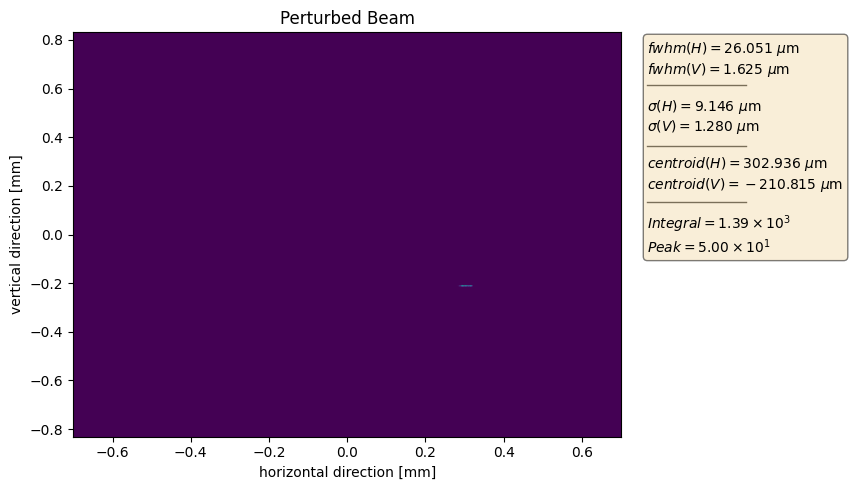

In [19]:
plot_distribution(Implementors.SHADOW, output_beam,  xrange=xrange, yrange=yrange, title="Perturbed Beam",
                      plot_mode=plot_mode, aspect_ratio=aspect_ratio, color_map=color_map, nbins_h=1024, nbins_v=1024)

In [20]:
centroid_init, *_ = opt_common.get_centroid_distance(photon_beam=output_beam, random_seed=DEFAULT_RANDOM_SEED, nbins_h=1024, nbins_v=1024)
sigma_init, *_ = opt_common.get_sigma(photon_beam=output_beam, nbins_h=1024, nbins_v=1024)
centroid_init, sigma_init

(0.36906264638066494, 0.009222447706765908)

In [21]:
move_motors_ranges = {
    "hb_1": [-100, 100],
    "hb_2": [-100, 100],
    "hb_pitch": [-0.02, 0.02],  # in mrad
    "hb_trans": [-30, 30],  # in mrad
    "vb_bender": [-500, 500],
    "vb_pitch": [-0.02, 0.02],
    "vb_trans": [-30, 30],
}

In [22]:
focusing_system = movers.move_motors(focusing_system, list(move_motors_ranges.keys()), initial_absolute_positions, movement='absolute')

0.36906264638066494 0.009222447706765908


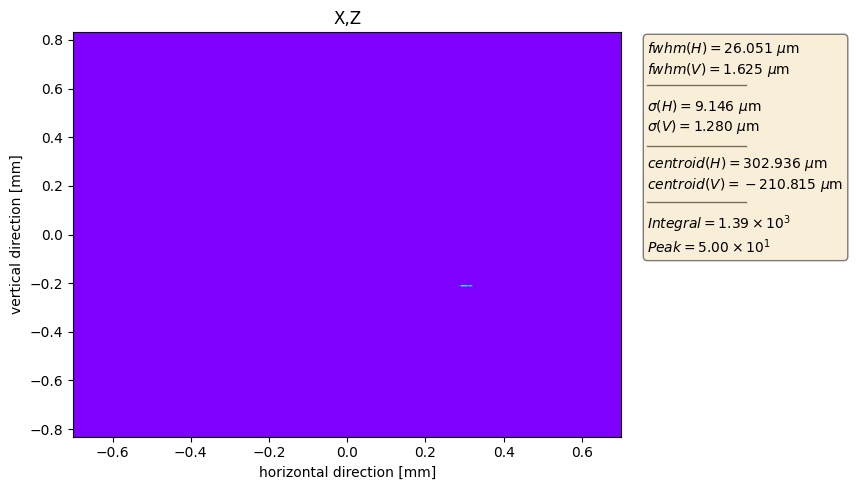

In [23]:
beam = opt_common.get_beam(focusing_system, random_seed=DEFAULT_RANDOM_SEED)
centroid, *_ = opt_common.get_centroid_distance(photon_beam=beam, random_seed=DEFAULT_RANDOM_SEED, nbins_h=1024, nbins_v=1024)
sigma, *_ = opt_common.get_sigma(photon_beam=beam, nbins_h=1024, nbins_v=1024)
print(centroid, sigma)


plot_shadow_beam_spatial_distribution(
    beam,
    xrange=xrange,
    yrange=yrange,
    nbins_h=1024,
    nbins_v=1024,
)

In [24]:
opt_trial = OptunaOptimizer(
    focusing_system,
    motor_types=list(move_motors_ranges.keys()),
    random_seed=DEFAULT_RANDOM_SEED,
    loss_parameters=["centroid", "sigma"],
    use_gaussian_fit=False,
    multi_objective_optimization=True,
    camera_xrange=xrange,
    camera_yrange=yrange,
    # Need to fix the number of camera bins.
    camera_nbins_h=1028, 
    camera_nbins_v=1024
)

In [25]:
constraints = {"sum_intensity": 1.3e3}
opt_trial.set_optimizer_options(
    motor_ranges=list(move_motors_ranges.values()),
    raise_prune_exception=True,
    use_discrete_space=True,
    sum_intensity_threshold=1e3,
    constraints=constraints,
    moo_thresholds={"centroid": 0.02, "sigma": 0.07},
    acquisition_function="qnehvi"
)

[I 2022-11-14 19:31:24,754] A new study created in memory with name: no-name-68640ac5-b43e-407a-b0b5-29433af38c62


In [33]:
opt_trial.trials(5)

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-69108/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-69108/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-14 19:32:38,136] Trial 10 finished with values: [0.274034400888535, 0.07886236739495188] and parameters: {'hb_1': 36.0, 'hb_2': 45.0, 'hb_pitch': -0.000789999999999999, 'hb_trans': 7.0, 'vb_bender': -157.0, 'vb_pitch': -0.0144, 'vb_trans': -20.5}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-69108/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-69108/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-14 19:32:38,435] Trial 11 finished with values: [0.1903636518145365, 0.06497006602104669] and parameters: {'hb_1': -72.0, 'hb_2': 42.0, 'hb_pitch': -0.0072499999999999995, 'hb_trans': -16.5, 'vb_bender': -188.0, 'vb_pitch': 0.0052, 'vb_trans': 16.0}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-69108/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-69108/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-14 19:32:38,747] Trial 12 pruned. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-69108/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-69108/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-14 19:32:39,057] Trial 13 finished with values: [0.3339556364859161, 0.10992021710936796] and parameters: {'hb_1': 94.0, 'hb_2': 26.0, 'hb_pitch': -0.000959999999999999, 'hb_trans': 1.0, 'vb_bender': -108.0, 'vb_pitch': -0.0046, 'vb_trans': -9.5}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-69108/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-69108/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-14 19:32:39,367] Trial 14 pruned. 


In [243]:
dill.dump( opt_trial.study, open(name_str, 'wb'))

TypeError: cannot pickle '_abc_data' object

In [165]:
opt_trial.study.enqueue_trial({mt: 0.0 for mt in opt_trial.motor_types})

In [166]:
opt_trial.trials(25, trial_motor_types=["hb_pitch", "hb_trans", "vb_pitch", "vb_trans"])

/Users/skandel/code/oasys/AI-ML_Control_System/aps/ai/autoalignment/beamline28IDB/optimization/optuna_botorch.py:463: ExperimentalWarning: PartialFixedSampler is experimental (supported from v2.4.0). The interface can change in the future.
  partial_sampler = optuna.samplers.PartialFixedSampler(fixed_params, self._base_sampler)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/trial/_trial.py:618: UserWarning: Fixed parameter 'hb_pitch' with value 0.0 is out of range for distribution FloatDistribution(high=0.01995, log=False, low=-0.02, step=0.00017).
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/trial/_trial.py:618: UserWarning: Fixed parameter 'vb_pitch' with value 0.0 is out of range for distribution FloatDistribution(high=0.0192, log=False, low=-0.02, step=0.0014).
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-4467/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-4467/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-14 17:49:24,067] Trial 25 finished with values: [0.3677248165096895, 0.009222433282730102] and parameters: {'hb_1': 0.0, 'hb_2': 0.0, 'hb_pitch': 0.0, 'hb_trans': 0.0, 'vb_bender': 0.0, 'vb_pitch': 0.0, 'vb_trans': 0.0}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(
[I 2022-11-14 17:49:25,371] Trial 26 finished with values: [0.3704746713796613, 0.018506815855267113] and parameters: {'hb_1': 0.0, 'hb_2': 0.0, 'hb_pitch': 0.010260000000000002, 'hb_trans': 28.5, 'vb_bender': 0.0, 'vb_pitch': -0.018600000000000002, 'vb_trans': -19.0}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(
[I 2022-11-14 17:49:26,704] Trial 27

In [167]:
opt_trial.study.best_trials

[FrozenTrial(number=24, values=[0.2190854050505102, 0.09471570995553434], datetime_start=datetime.datetime(2022, 11, 14, 17, 48, 41, 779032), datetime_complete=datetime.datetime(2022, 11, 14, 17, 48, 43, 177716), params={'hb_1': -88.0, 'hb_2': 59.0, 'hb_pitch': -0.001469999999999999, 'hb_trans': 6.0, 'vb_bender': -290.0, 'vb_pitch': 0.0023999999999999994, 'vb_trans': 14.5}, distributions={'hb_1': FloatDistribution(high=100.0, log=False, low=-100.0, step=1.0), 'hb_2': FloatDistribution(high=100.0, log=False, low=-100.0, step=1.0), 'hb_pitch': FloatDistribution(high=0.01995, log=False, low=-0.02, step=0.00017), 'hb_trans': FloatDistribution(high=30.0, log=False, low=-30.0, step=0.5), 'vb_bender': FloatDistribution(high=500.0, log=False, low=-500.0, step=1.0), 'vb_pitch': FloatDistribution(high=0.0192, log=False, low=-0.02, step=0.0014), 'vb_trans': FloatDistribution(high=30.0, log=False, low=-30.0, step=0.5)}, user_attrs={'sum_intensity_constraint': -1, 'dw': <aps.common.ml.data_structur

/var/folders/gn/ggsvq37x5sv5bb1j9chn8mmw0000gr/T/ipykernel_79926/1036378160.py:1: ExperimentalWarning: plot_pareto_front is experimental (supported from v2.8.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_pareto_front(opt_trial.study, include_dominated_trials=False)


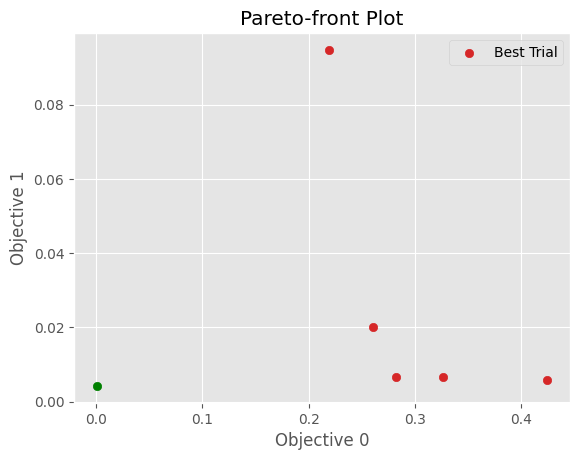

In [168]:
optuna.visualization.matplotlib.plot_pareto_front(opt_trial.study, include_dominated_trials=False)
#plt.xscale('log')
#plt.yscale('log')
plt.scatter(centroid_ground, sigma_ground, color='green')

In [169]:
for t in opt_trial.study.best_trials:
    params = t.params
    vals = t.values
    print(np.log(vals).sum(), t.user_attrs['dw'])

-3.875169048514196 h_sigma: 0.07090399344584188
h_fwhm: 0.18437743190660993
h_centroid: 0.12422654695649785
v_sigma: 0.06279880114948787
v_fwhm: 0.21612499999999835
v_centroid: 0.1804610199943776
integral_intensity: 1678.6093950501545
peak_intensity: 1.7653064143532113
gaussian_fit: {}

-6.269497570819668 h_sigma: 0.006538979356346279
h_fwhm: 0.016389105058365327
h_centroid: -0.2062061680746561
v_sigma: 0.0014735564053787972
v_fwhm: 0.0016249999999999876
v_centroid: 0.19300540424509754
integral_intensity: 1775.6200843044371
peak_intensity: 71.54614294955897
gaussian_fit: {}

-5.999167818409041 h_sigma: 0.0056871290201776625
h_fwhm: 0.009560311284046441
h_centroid: -0.25259923724192257
v_sigma: 0.0013248944727208424
v_fwhm: None
v_centroid: 0.3415880437419819
integral_intensity: 1309.0431959764896
peak_intensity: 89.32639023926372
gaussian_fit: {}

-6.153949575695358 h_sigma: 0.006400657676816733
h_fwhm: 0.016389105058365327
h_centroid: -0.2584654522601504
v_sigma: 0.0011648887264730477

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-4467/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-4467/Downstream_HKB_bender_profile.dat written to disk.
[0.2190854050505102, 0.09471570995553434]


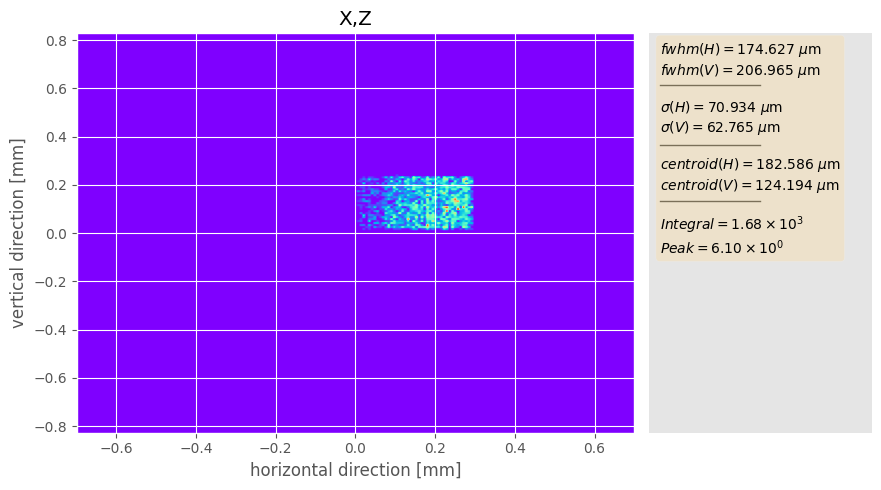

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-4467/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-4467/Downstream_HKB_bender_profile.dat written to disk.
[0.2824394976270968, 0.006702956027198424]


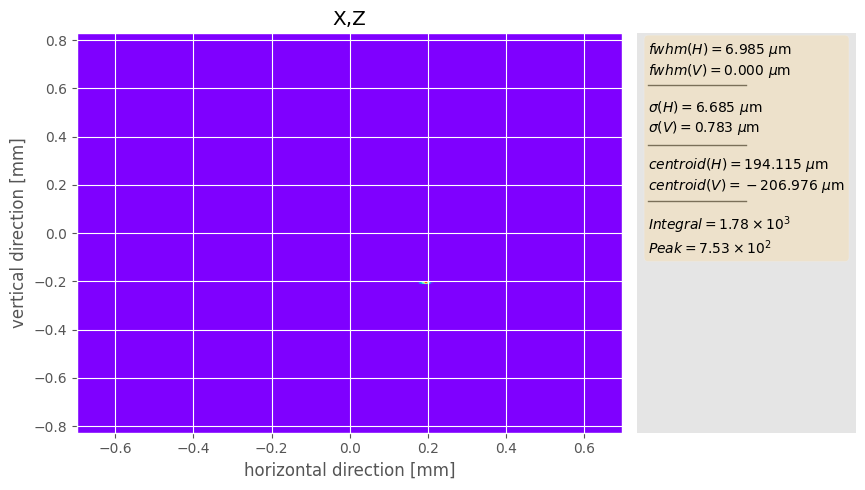

[0.42483969480578815, 0.005839416225616493]


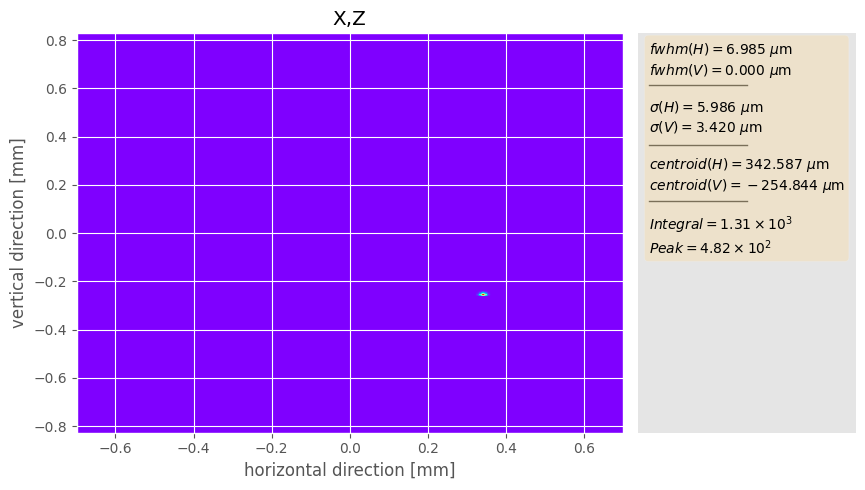

[0.3266428841572349, 0.006505796218823409]


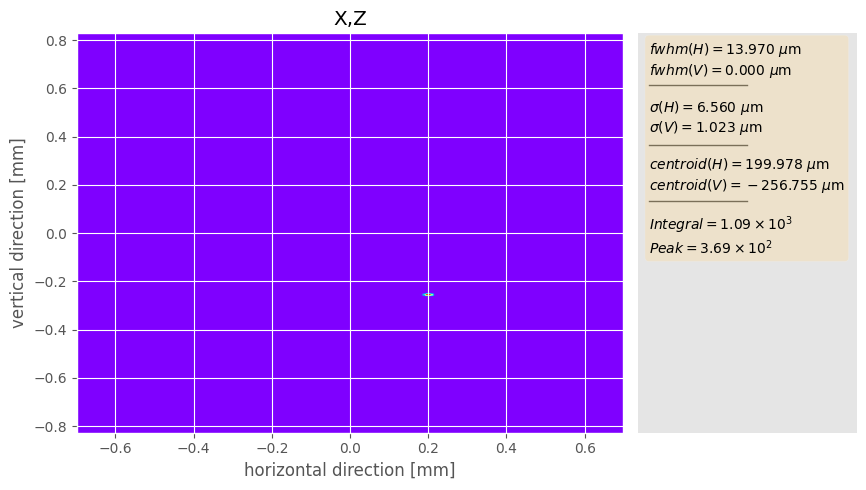

[0.2608677197082331, 0.019989014886829522]


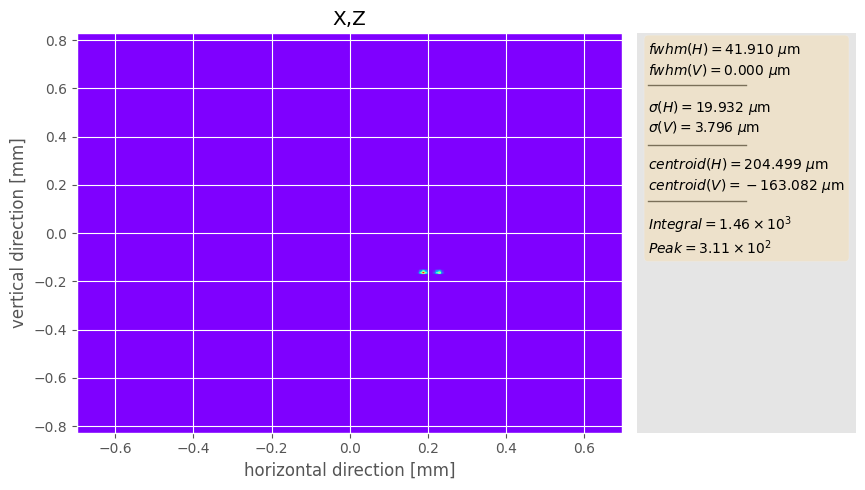

In [170]:
for t in opt_trial.study.best_trials:
    params = t.params
    vals = t.values
    current_params = []
    for mot in opt_trial.motor_types:
        current_params.append(params[mot])
    opt_trial._loss_fn_this(current_params)
    print(t.values)
    plot_shadow_beam_spatial_distribution(opt_trial.beam_state.photon_beam, xrange=opt_trial._camera_xrange, yrange=opt_trial._camera_yrange)

In [171]:
opt_trial.trials(175)

/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-4467/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-4467/Downstream_HKB_bender_profile.dat written to disk.


/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/oasys/util/oasys_util.py:283: RuntimeWarning: invalid value encountered in true_divide
  frequency = histogram/numpy.sum(histogram)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/oasys/util/oasys_util.py:292: RuntimeWarning: invalid value encountered in true_divide
  frequency = histogram/numpy.sum(histogram)
[I 2022-11-14 17:50:07,323] Trial 50 pruned. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-4467/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-4467/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-14 17:50:10,307] Trial 51 finished with values: [0.45890977774470154, 0.05294598080068394] and parameters: {'hb_1': 49.0, 'hb_2': -15.0, 'hb_pitch': 0.014850000000000006, 'hb_trans': -18.5, 'vb_bender': -76.0, 'vb_pitch': -0.0032000000000000015, 'vb_trans': 4.5}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-4467/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-4467/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-14 17:50:12,766] Trial 52 finished with values: [0.4551201962218906, 0.17867672087156966] and parameters: {'hb_1': 89.0, 'hb_2': 71.0, 'hb_pitch': 0.016720000000000002, 'hb_trans': 9.0, 'vb_bender': -439.0, 'vb_pitch': 0.0178, 'vb_trans': 23.5}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-4467/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-4467/Downstream_HKB_bender_profile.dat written to disk.


/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/oasys/util/oasys_util.py:283: RuntimeWarning: invalid value encountered in true_divide
  frequency = histogram/numpy.sum(histogram)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/oasys/util/oasys_util.py:292: RuntimeWarning: invalid value encountered in true_divide
  frequency = histogram/numpy.sum(histogram)
[I 2022-11-14 17:50:14,840] Trial 53 pruned. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-4467/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-4467/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-14 17:50:16,712] Trial 54 finished with values: [0.29595498226954475, 0.06738705942677403] and parameters: {'hb_1': 17.0, 'hb_2': -81.0, 'hb_pitch': -0.01881, 'hb_trans': -12.5, 'vb_bender': -60.0, 'vb_pitch': -0.006, 'vb_trans': 29.5}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(
[I 2022-11-14 17:50:18,859] Trial 55 finished with values: [0.3720952066777, 0.11986772888486369] and parameters: {'hb_1': -67.0, 'hb_2': -87.0, 'hb_pitch': 0.0027800000000000012, 'hb_trans': -7.0, 'vb_bender': -100.0, 'vb_pitch': -0.011600000000000001, 'vb_trans': -16.0}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-4467/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-4467/Downstream_HKB_bender_profile.dat written to disk.


/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-4467/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-4467/Downstream_HKB_bender_profile.dat written to disk.


/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/oasys/util/oasys_util.py:283: RuntimeWarning: invalid value encountered in true_divide
  frequency = histogram/numpy.sum(histogram)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/oasys/util/oasys_util.py:292: RuntimeWarning: invalid value encountered in true_divide
  frequency = histogram/numpy.sum(histogram)
[I 2022-11-14 17:50:20,931] Trial 56 pruned. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-4467/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-4467/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-14 17:50:23,203] Trial 57 finished with values: [0.4432474518772829, 0.04865323911176128] and parameters: {'hb_1': -42.0, 'hb_2': 0.0, 'hb_pitch': 0.00040000000000000105, 'hb_trans': 11.5, 'vb_bender': 157.0, 'vb_pitch': -0.0074, 'vb_trans': 3.0}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-4467/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-4467/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-14 17:50:25,144] Trial 58 finished with values: [0.21869569589875318, 0.06614528402577505] and parameters: {'hb_1': -48.0, 'hb_2': 14.0, 'hb_pitch': -0.0081, 'hb_trans': 23.5, 'vb_bender': -223.0, 'vb_pitch': -0.011600000000000001, 'vb_trans': 3.5}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-4467/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-4467/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-14 17:50:27,319] Trial 59 finished with values: [0.447243393375476, 0.07161963308536012] and parameters: {'hb_1': 57.0, 'hb_2': -15.0, 'hb_pitch': 0.012640000000000002, 'hb_trans': -26.5, 'vb_bender': -197.0, 'vb_pitch': -0.0102, 'vb_trans': 4.5}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-4467/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-4467/Downstream_HKB_bender_profile.dat written to disk.


/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/oasys/util/oasys_util.py:283: RuntimeWarning: invalid value encountered in true_divide
  frequency = histogram/numpy.sum(histogram)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/oasys/util/oasys_util.py:292: RuntimeWarning: invalid value encountered in true_divide
  frequency = histogram/numpy.sum(histogram)
[I 2022-11-14 17:50:29,474] Trial 60 pruned. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-4467/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-4467/Downstream_HKB_bender_profile.dat written to disk.


/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/oasys/util/oasys_util.py:283: RuntimeWarning: invalid value encountered in true_divide
  frequency = histogram/numpy.sum(histogram)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/oasys/util/oasys_util.py:292: RuntimeWarning: invalid value encountered in true_divide
  frequency = histogram/numpy.sum(histogram)
[I 2022-11-14 17:50:31,387] Trial 61 pruned. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-4467/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-4467/Downstream_HKB_bender_profile.dat written to disk.


/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/oasys/util/oasys_util.py:283: RuntimeWarning: invalid value encountered in true_divide
  frequency = histogram/numpy.sum(histogram)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/oasys/util/oasys_util.py:292: RuntimeWarning: invalid value encountered in true_divide
  frequency = histogram/numpy.sum(histogram)
[I 2022-11-14 17:50:34,505] Trial 62 pruned. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-4467/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-4467/Downstream_HKB_bender_profile.dat written to disk.


/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/oasys/util/oasys_util.py:283: RuntimeWarning: invalid value encountered in true_divide
  frequency = histogram/numpy.sum(histogram)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/oasys/util/oasys_util.py:292: RuntimeWarning: invalid value encountered in true_divide
  frequency = histogram/numpy.sum(histogram)
[I 2022-11-14 17:50:36,524] Trial 63 pruned. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-4467/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-4467/Downstream_HKB_bender_profile.dat written to disk.


/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/oasys/util/oasys_util.py:283: RuntimeWarning: invalid value encountered in true_divide
  frequency = histogram/numpy.sum(histogram)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/oasys/util/oasys_util.py:292: RuntimeWarning: invalid value encountered in true_divide
  frequency = histogram/numpy.sum(histogram)
[I 2022-11-14 17:50:38,452] Trial 64 pruned. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-4467/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-4467/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-14 17:50:40,565] Trial 65 finished with values: [0.26848243986861997, 0.0910663571614228] and parameters: {'hb_1': -69.0, 'hb_2': -35.0, 'hb_pitch': -0.01864, 'hb_trans': 8.0, 'vb_bender': -78.0, 'vb_pitch': 0.0178, 'vb_trans': -11.5}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-4467/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-4467/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-14 17:50:42,901] Trial 66 pruned. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-4467/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-4467/Downstream_HKB_bender_profile.dat written to disk.


/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/oasys/util/oasys_util.py:283: RuntimeWarning: invalid value encountered in true_divide
  frequency = histogram/numpy.sum(histogram)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/oasys/util/oasys_util.py:292: RuntimeWarning: invalid value encountered in true_divide
  frequency = histogram/numpy.sum(histogram)
[I 2022-11-14 17:50:45,037] Trial 67 pruned. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-4467/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-4467/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-14 17:50:47,119] Trial 68 finished with values: [0.3303184346634802, 0.11563385547165476] and parameters: {'hb_1': 17.0, 'hb_2': 67.0, 'hb_pitch': 0.0012500000000000011, 'hb_trans': 24.5, 'vb_bender': -363.0, 'vb_pitch': -0.00040000000000000105, 'vb_trans': 26.5}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-4467/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-4467/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-14 17:50:50,647] Trial 69 finished with values: [0.4429599809496933, 0.05333026543954693] and parameters: {'hb_1': -48.0, 'hb_2': -39.0, 'hb_pitch': 0.0063500000000000015, 'hb_trans': -15.5, 'vb_bender': 91.0, 'vb_pitch': -0.013000000000000001, 'vb_trans': 7.5}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-4467/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-4467/Downstream_HKB_bender_profile.dat written to disk.


/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/oasys/util/oasys_util.py:283: RuntimeWarning: invalid value encountered in true_divide
  frequency = histogram/numpy.sum(histogram)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/oasys/util/oasys_util.py:292: RuntimeWarning: invalid value encountered in true_divide
  frequency = histogram/numpy.sum(histogram)
[I 2022-11-14 17:50:53,053] Trial 70 pruned. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-4467/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-4467/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-14 17:50:55,379] Trial 71 finished with values: [0.4213278172813577, 0.1044782570374255] and parameters: {'hb_1': 37.0, 'hb_2': 64.0, 'hb_pitch': 0.018080000000000002, 'hb_trans': -4.0, 'vb_bender': -11.0, 'vb_pitch': -0.0017999999999999995, 'vb_trans': 12.0}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-4467/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-4467/Downstream_HKB_bender_profile.dat written to disk.


/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/oasys/util/oasys_util.py:283: RuntimeWarning: invalid value encountered in true_divide
  frequency = histogram/numpy.sum(histogram)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/oasys/util/oasys_util.py:292: RuntimeWarning: invalid value encountered in true_divide
  frequency = histogram/numpy.sum(histogram)
[I 2022-11-14 17:50:57,657] Trial 72 pruned. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-4467/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-4467/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-14 17:51:00,513] Trial 73 finished with values: [0.39846837435601756, 0.13325761616458923] and parameters: {'hb_1': 32.0, 'hb_2': 96.0, 'hb_pitch': -0.0065699999999999995, 'hb_trans': 15.0, 'vb_bender': -382.0, 'vb_pitch': -0.02, 'vb_trans': -23.5}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-4467/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-4467/Downstream_HKB_bender_profile.dat written to disk.


/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/oasys/util/oasys_util.py:283: RuntimeWarning: invalid value encountered in true_divide
  frequency = histogram/numpy.sum(histogram)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/oasys/util/oasys_util.py:292: RuntimeWarning: invalid value encountered in true_divide
  frequency = histogram/numpy.sum(histogram)
[I 2022-11-14 17:51:03,047] Trial 74 pruned. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-4467/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-4467/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-14 17:51:06,221] Trial 75 finished with values: [0.3618088290742035, 0.12240583688194404] and parameters: {'hb_1': -11.0, 'hb_2': 98.0, 'hb_pitch': 0.005500000000000001, 'hb_trans': -16.0, 'vb_bender': 14.0, 'vb_pitch': 0.012199999999999999, 'vb_trans': 20.0}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-4467/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-4467/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-14 17:51:08,771] Trial 76 finished with values: [0.4184659799246016, 0.08451655604332406] and parameters: {'hb_1': -2.0, 'hb_2': -33.0, 'hb_pitch': -0.002659999999999999, 'hb_trans': -3.0, 'vb_bender': -389.0, 'vb_pitch': -0.0032000000000000015, 'vb_trans': 7.0}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-4467/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-4467/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-14 17:51:11,112] Trial 77 finished with values: [0.3661813552629082, 0.10334546316381096] and parameters: {'hb_1': -66.0, 'hb_2': -20.0, 'hb_pitch': 0.009750000000000002, 'hb_trans': 14.0, 'vb_bender': -323.0, 'vb_pitch': 0.0023999999999999994, 'vb_trans': 7.0}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-4467/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-4467/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-14 17:51:13,358] Trial 78 finished with values: [0.37433536071254647, 0.03141091271996807] and parameters: {'hb_1': -16.0, 'hb_2': -39.0, 'hb_pitch': 0.002270000000000001, 'hb_trans': -16.5, 'vb_bender': -4.0, 'vb_pitch': -0.0172, 'vb_trans': 27.0}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-4467/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-4467/Downstream_HKB_bender_profile.dat written to disk.


/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/oasys/util/oasys_util.py:283: RuntimeWarning: invalid value encountered in true_divide
  frequency = histogram/numpy.sum(histogram)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/oasys/util/oasys_util.py:292: RuntimeWarning: invalid value encountered in true_divide
  frequency = histogram/numpy.sum(histogram)
[I 2022-11-14 17:51:15,934] Trial 79 pruned. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-4467/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-4467/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-14 17:51:18,430] Trial 80 finished with values: [0.3086722707693197, 0.10578272371066286] and parameters: {'hb_1': 80.0, 'hb_2': 24.0, 'hb_pitch': -0.01796, 'hb_trans': 19.5, 'vb_bender': -298.0, 'vb_pitch': -0.018600000000000002, 'vb_trans': 13.0}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-4467/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-4467/Downstream_HKB_bender_profile.dat written to disk.


/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/oasys/util/oasys_util.py:283: RuntimeWarning: invalid value encountered in true_divide
  frequency = histogram/numpy.sum(histogram)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/oasys/util/oasys_util.py:292: RuntimeWarning: invalid value encountered in true_divide
  frequency = histogram/numpy.sum(histogram)
[I 2022-11-14 17:51:21,688] Trial 81 pruned. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-4467/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-4467/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-14 17:51:24,292] Trial 82 finished with values: [0.43144984835810274, 0.11501096265060856] and parameters: {'hb_1': -2.0, 'hb_2': 55.0, 'hb_pitch': -0.001129999999999999, 'hb_trans': 4.0, 'vb_bender': -431.0, 'vb_pitch': -0.011600000000000001, 'vb_trans': 13.0}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-4467/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-4467/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-14 17:51:26,856] Trial 83 finished with values: [0.4852275423210482, 0.08207098987628507] and parameters: {'hb_1': -86.0, 'hb_2': -1.0, 'hb_pitch': 0.017060000000000002, 'hb_trans': -23.0, 'vb_bender': -347.0, 'vb_pitch': -0.02, 'vb_trans': 2.0}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-4467/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-4467/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-14 17:51:29,039] Trial 84 finished with values: [0.15587037581843344, 0.07594035885073995] and parameters: {'hb_1': -90.0, 'hb_2': 42.0, 'hb_pitch': -0.01099, 'hb_trans': 3.5, 'vb_bender': -189.0, 'vb_pitch': -0.011600000000000001, 'vb_trans': 4.0}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-4467/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-4467/Downstream_HKB_bender_profile.dat written to disk.


/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/oasys/util/oasys_util.py:283: RuntimeWarning: invalid value encountered in true_divide
  frequency = histogram/numpy.sum(histogram)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/oasys/util/oasys_util.py:292: RuntimeWarning: invalid value encountered in true_divide
  frequency = histogram/numpy.sum(histogram)
[I 2022-11-14 17:51:31,586] Trial 85 pruned. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-4467/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-4467/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-14 17:51:33,994] Trial 86 finished with values: [0.4363901962883196, 0.10000343193561177] and parameters: {'hb_1': 39.0, 'hb_2': -9.0, 'hb_pitch': 0.0038000000000000013, 'hb_trans': -0.5, 'vb_bender': -368.0, 'vb_pitch': -0.006, 'vb_trans': 30.0}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-4467/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-4467/Downstream_HKB_bender_profile.dat written to disk.


/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/oasys/util/oasys_util.py:283: RuntimeWarning: invalid value encountered in true_divide
  frequency = histogram/numpy.sum(histogram)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/oasys/util/oasys_util.py:292: RuntimeWarning: invalid value encountered in true_divide
  frequency = histogram/numpy.sum(histogram)
[I 2022-11-14 17:51:36,475] Trial 87 pruned. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-4467/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-4467/Downstream_HKB_bender_profile.dat written to disk.


/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/oasys/util/oasys_util.py:283: RuntimeWarning: invalid value encountered in true_divide
  frequency = histogram/numpy.sum(histogram)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/oasys/util/oasys_util.py:292: RuntimeWarning: invalid value encountered in true_divide
  frequency = histogram/numpy.sum(histogram)
[I 2022-11-14 17:51:39,267] Trial 88 pruned. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-4467/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-4467/Downstream_HKB_bender_profile.dat written to disk.


/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/oasys/util/oasys_util.py:283: RuntimeWarning: invalid value encountered in true_divide
  frequency = histogram/numpy.sum(histogram)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/oasys/util/oasys_util.py:292: RuntimeWarning: invalid value encountered in true_divide
  frequency = histogram/numpy.sum(histogram)
[I 2022-11-14 17:51:41,483] Trial 89 pruned. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-4467/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-4467/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-14 17:51:43,655] Trial 90 finished with values: [0.33541350544132026, 0.1053724461045849] and parameters: {'hb_1': 46.0, 'hb_2': 55.0, 'hb_pitch': 0.0073700000000000015, 'hb_trans': -11.0, 'vb_bender': -65.0, 'vb_pitch': -0.0144, 'vb_trans': 9.0}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-4467/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-4467/Downstream_HKB_bender_profile.dat written to disk.


/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/oasys/util/oasys_util.py:283: RuntimeWarning: invalid value encountered in true_divide
  frequency = histogram/numpy.sum(histogram)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/oasys/util/oasys_util.py:292: RuntimeWarning: invalid value encountered in true_divide
  frequency = histogram/numpy.sum(histogram)
[I 2022-11-14 17:51:45,781] Trial 91 pruned. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-4467/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-4467/Downstream_HKB_bender_profile.dat written to disk.


/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/oasys/util/oasys_util.py:283: RuntimeWarning: invalid value encountered in true_divide
  frequency = histogram/numpy.sum(histogram)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/oasys/util/oasys_util.py:292: RuntimeWarning: invalid value encountered in true_divide
  frequency = histogram/numpy.sum(histogram)
[I 2022-11-14 17:51:47,907] Trial 92 pruned. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-4467/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-4467/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-14 17:51:49,997] Trial 93 finished with values: [0.425611526256948, 0.08448988749770223] and parameters: {'hb_1': -92.0, 'hb_2': -45.0, 'hb_pitch': 0.011280000000000002, 'hb_trans': -19.5, 'vb_bender': -40.0, 'vb_pitch': 0.0023999999999999994, 'vb_trans': -12.0}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-4467/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-4467/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-14 17:51:52,475] Trial 94 finished with values: [0.4724374840856947, 0.11632044030064252] and parameters: {'hb_1': 16.0, 'hb_2': 64.0, 'hb_pitch': 0.009920000000000002, 'hb_trans': 16.5, 'vb_bender': -461.0, 'vb_pitch': -0.0017999999999999995, 'vb_trans': -3.0}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-4467/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-4467/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-14 17:51:54,629] Trial 95 finished with values: [0.42674680724319064, 0.08382845749436296] and parameters: {'hb_1': 37.0, 'hb_2': -100.0, 'hb_pitch': -0.001469999999999999, 'hb_trans': -6.0, 'vb_bender': -100.0, 'vb_pitch': 0.0052, 'vb_trans': -2.5}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-4467/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-4467/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-14 17:51:57,556] Trial 96 finished with values: [0.2538718562216905, 0.13468160129464948] and parameters: {'hb_1': 45.0, 'hb_2': 84.0, 'hb_pitch': -0.004359999999999999, 'hb_trans': 11.0, 'vb_bender': -331.0, 'vb_pitch': 0.013599999999999998, 'vb_trans': -2.0}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-4467/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-4467/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-14 17:52:02,275] Trial 97 finished with values: [0.5118316232212418, 0.10856717800469916] and parameters: {'hb_1': 68.0, 'hb_2': -36.0, 'hb_pitch': -0.00963, 'hb_trans': -29.5, 'vb_bender': -428.0, 'vb_pitch': -0.02, 'vb_trans': 7.5}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-4467/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-4467/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-14 17:52:04,461] Trial 98 finished with values: [0.28739790049551156, 0.11483244864703088] and parameters: {'hb_1': -57.0, 'hb_2': -80.0, 'hb_pitch': -0.01575, 'hb_trans': -4.5, 'vb_bender': -225.0, 'vb_pitch': -0.02, 'vb_trans': -9.5}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-4467/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-4467/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-14 17:52:06,642] Trial 99 finished with values: [0.4710530953402021, 0.08584009510422061] and parameters: {'hb_1': 1.0, 'hb_2': -68.0, 'hb_pitch': -0.01779, 'hb_trans': 26.0, 'vb_bender': 142.0, 'vb_pitch': 0.009399999999999999, 'vb_trans': 1.5}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-4467/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-4467/Downstream_HKB_bender_profile.dat written to disk.


/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/oasys/util/oasys_util.py:283: RuntimeWarning: invalid value encountered in true_divide
  frequency = histogram/numpy.sum(histogram)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/oasys/util/oasys_util.py:292: RuntimeWarning: invalid value encountered in true_divide
  frequency = histogram/numpy.sum(histogram)
[I 2022-11-14 17:52:08,869] Trial 100 pruned. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-4467/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-4467/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-14 17:52:11,085] Trial 101 finished with values: [0.48564984128428423, 0.048825926744166796] and parameters: {'hb_1': -49.0, 'hb_2': 40.0, 'hb_pitch': 0.018420000000000002, 'hb_trans': 22.0, 'vb_bender': 121.0, 'vb_pitch': -0.0046, 'vb_trans': -22.0}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-4467/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-4467/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-14 17:52:14,212] Trial 102 finished with values: [0.5042017722690546, 0.07144143105401528] and parameters: {'hb_1': -34.0, 'hb_2': 11.0, 'hb_pitch': 0.003970000000000001, 'hb_trans': -12.5, 'vb_bender': -443.0, 'vb_pitch': -0.013000000000000001, 'vb_trans': -20.5}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-4467/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-4467/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-14 17:52:18,196] Trial 103 finished with values: [0.29696244947279365, 0.1237771530155027] and parameters: {'hb_1': -51.0, 'hb_2': -95.0, 'hb_pitch': -0.01048, 'hb_trans': -4.5, 'vb_bender': -230.0, 'vb_pitch': 0.0164, 'vb_trans': -18.5}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-4467/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-4467/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-14 17:52:22,498] Trial 104 finished with values: [0.5123652641566641, 0.10602250505120386] and parameters: {'hb_1': -7.0, 'hb_2': -66.0, 'hb_pitch': 0.009920000000000002, 'hb_trans': -6.0, 'vb_bender': -464.0, 'vb_pitch': 0.0164, 'vb_trans': -4.5}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-4467/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-4467/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-14 17:52:25,528] Trial 105 finished with values: [0.2362585687800594, 0.062006610469265054] and parameters: {'hb_1': 3.0, 'hb_2': 5.0, 'hb_pitch': -0.0077599999999999995, 'hb_trans': 27.0, 'vb_bender': -246.0, 'vb_pitch': 0.006599999999999998, 'vb_trans': 29.5}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-4467/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-4467/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-14 17:52:28,860] Trial 106 finished with values: [0.5380184946255309, 0.0624864159730475] and parameters: {'hb_1': 78.0, 'hb_2': -58.0, 'hb_pitch': 0.019780000000000002, 'hb_trans': 17.0, 'vb_bender': -70.0, 'vb_pitch': 0.0052, 'vb_trans': -20.0}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-4467/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-4467/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-14 17:52:31,496] Trial 107 finished with values: [0.17406272292647565, 0.0819118060495109] and parameters: {'hb_1': -93.0, 'hb_2': 17.0, 'hb_pitch': -0.01031, 'hb_trans': -3.5, 'vb_bender': -217.0, 'vb_pitch': 0.014999999999999996, 'vb_trans': 20.0}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-4467/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-4467/Downstream_HKB_bender_profile.dat written to disk.


/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/oasys/util/oasys_util.py:283: RuntimeWarning: invalid value encountered in true_divide
  frequency = histogram/numpy.sum(histogram)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/oasys/util/oasys_util.py:292: RuntimeWarning: invalid value encountered in true_divide
  frequency = histogram/numpy.sum(histogram)
[I 2022-11-14 17:52:33,627] Trial 108 pruned. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-4467/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-4467/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-14 17:52:35,685] Trial 109 finished with values: [0.516442867140068, 0.06449342067826463] and parameters: {'hb_1': 39.0, 'hb_2': 15.0, 'hb_pitch': 0.013149999999999998, 'hb_trans': -13.0, 'vb_bender': 110.0, 'vb_pitch': -0.0046, 'vb_trans': -9.0}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-4467/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-4467/Downstream_HKB_bender_profile.dat written to disk.


/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/oasys/util/oasys_util.py:283: RuntimeWarning: invalid value encountered in true_divide
  frequency = histogram/numpy.sum(histogram)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/oasys/util/oasys_util.py:292: RuntimeWarning: invalid value encountered in true_divide
  frequency = histogram/numpy.sum(histogram)
[I 2022-11-14 17:52:38,352] Trial 110 pruned. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-4467/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-4467/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-14 17:52:40,999] Trial 111 finished with values: [0.38365333171239074, 0.05271536169763985] and parameters: {'hb_1': -75.0, 'hb_2': 19.0, 'hb_pitch': 0.012469999999999998, 'hb_trans': -1.5, 'vb_bender': -54.0, 'vb_pitch': 0.012199999999999999, 'vb_trans': -14.0}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-4467/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-4467/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-14 17:52:43,692] Trial 112 finished with values: [0.2015134502595638, 0.0890791645968389] and parameters: {'hb_1': -95.0, 'hb_2': 67.0, 'hb_pitch': -0.0036799999999999992, 'hb_trans': -14.0, 'vb_bender': -237.0, 'vb_pitch': -0.006, 'vb_trans': 13.0}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-4467/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-4467/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-14 17:52:47,225] Trial 113 finished with values: [0.31507287413622953, 0.08804093953883198] and parameters: {'hb_1': 31.0, 'hb_2': -87.0, 'hb_pitch': -0.01031, 'hb_trans': 26.5, 'vb_bender': -86.0, 'vb_pitch': -0.0158, 'vb_trans': -26.5}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-4467/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-4467/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-14 17:52:50,275] Trial 114 finished with values: [0.42766000100747015, 0.06140805641493996] and parameters: {'hb_1': -49.0, 'hb_2': -46.0, 'hb_pitch': 0.007880000000000002, 'hb_trans': -12.0, 'vb_bender': -9.0, 'vb_pitch': 0.006599999999999998, 'vb_trans': 28.5}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-4467/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-4467/Downstream_HKB_bender_profile.dat written to disk.


/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/oasys/util/oasys_util.py:283: RuntimeWarning: invalid value encountered in true_divide
  frequency = histogram/numpy.sum(histogram)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/oasys/util/oasys_util.py:292: RuntimeWarning: invalid value encountered in true_divide
  frequency = histogram/numpy.sum(histogram)
[I 2022-11-14 17:52:52,961] Trial 115 pruned. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-4467/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-4467/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-14 17:52:55,627] Trial 116 finished with values: [0.3704907478795925, 0.14291527232157913] and parameters: {'hb_1': -68.0, 'hb_2': 99.0, 'hb_pitch': 0.01927, 'hb_trans': -2.0, 'vb_bender': -416.0, 'vb_pitch': 0.0108, 'vb_trans': 28.5}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-4467/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-4467/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-14 17:52:58,341] Trial 117 finished with values: [0.48360206104779513, 0.11202633431672532] and parameters: {'hb_1': 69.0, 'hb_2': 21.0, 'hb_pitch': -0.002659999999999999, 'hb_trans': 18.5, 'vb_bender': -452.0, 'vb_pitch': -0.0088, 'vb_trans': -4.5}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-4467/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-4467/Downstream_HKB_bender_profile.dat written to disk.


/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/oasys/util/oasys_util.py:283: RuntimeWarning: invalid value encountered in true_divide
  frequency = histogram/numpy.sum(histogram)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/oasys/util/oasys_util.py:292: RuntimeWarning: invalid value encountered in true_divide
  frequency = histogram/numpy.sum(histogram)
[I 2022-11-14 17:53:01,305] Trial 118 pruned. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-4467/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-4467/Downstream_HKB_bender_profile.dat written to disk.


/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/oasys/util/oasys_util.py:283: RuntimeWarning: invalid value encountered in true_divide
  frequency = histogram/numpy.sum(histogram)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/oasys/util/oasys_util.py:292: RuntimeWarning: invalid value encountered in true_divide
  frequency = histogram/numpy.sum(histogram)
[I 2022-11-14 17:53:04,076] Trial 119 pruned. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-4467/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-4467/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-14 17:53:07,091] Trial 120 finished with values: [0.31307531263723576, 0.06501033352727043] and parameters: {'hb_1': -84.0, 'hb_2': 47.0, 'hb_pitch': 0.015360000000000002, 'hb_trans': -5.5, 'vb_bender': -152.0, 'vb_pitch': -0.018600000000000002, 'vb_trans': -10.5}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-4467/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-4467/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-14 17:53:09,664] Trial 121 finished with values: [0.4457018406811897, 0.10576831542640004] and parameters: {'hb_1': 84.0, 'hb_2': 11.0, 'hb_pitch': 0.010430000000000002, 'hb_trans': -14.0, 'vb_bender': -322.0, 'vb_pitch': 0.0010000000000000009, 'vb_trans': -17.5}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-4467/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-4467/Downstream_HKB_bender_profile.dat written to disk.


/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/oasys/util/oasys_util.py:283: RuntimeWarning: invalid value encountered in true_divide
  frequency = histogram/numpy.sum(histogram)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/oasys/util/oasys_util.py:292: RuntimeWarning: invalid value encountered in true_divide
  frequency = histogram/numpy.sum(histogram)
[I 2022-11-14 17:53:13,010] Trial 122 pruned. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-4467/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-4467/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-14 17:53:15,791] Trial 123 finished with values: [0.5272731144875124, 0.09960973045396214] and parameters: {'hb_1': 7.0, 'hb_2': -84.0, 'hb_pitch': 0.00023000000000000104, 'hb_trans': -1.5, 'vb_bender': -457.0, 'vb_pitch': 0.0010000000000000009, 'vb_trans': -27.5}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-4467/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-4467/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-14 17:53:18,532] Trial 124 finished with values: [0.26015327478703637, 0.0342619489416484] and parameters: {'hb_1': -7.0, 'hb_2': 36.0, 'hb_pitch': -0.00997, 'hb_trans': 17.5, 'vb_bender': -47.0, 'vb_pitch': 0.0052, 'vb_trans': 1.5}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-4467/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-4467/Downstream_HKB_bender_profile.dat written to disk.


/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/oasys/util/oasys_util.py:283: RuntimeWarning: invalid value encountered in true_divide
  frequency = histogram/numpy.sum(histogram)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/oasys/util/oasys_util.py:292: RuntimeWarning: invalid value encountered in true_divide
  frequency = histogram/numpy.sum(histogram)
[I 2022-11-14 17:53:22,794] Trial 125 pruned. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-4467/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-4467/Downstream_HKB_bender_profile.dat written to disk.


/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/oasys/util/oasys_util.py:283: RuntimeWarning: invalid value encountered in true_divide
  frequency = histogram/numpy.sum(histogram)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/oasys/util/oasys_util.py:292: RuntimeWarning: invalid value encountered in true_divide
  frequency = histogram/numpy.sum(histogram)
[I 2022-11-14 17:53:25,780] Trial 126 pruned. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-4467/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-4467/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-14 17:53:29,259] Trial 127 finished with values: [0.34134727907520807, 0.0797267534369267] and parameters: {'hb_1': -76.0, 'hb_2': -43.0, 'hb_pitch': 0.002270000000000001, 'hb_trans': -26.0, 'vb_bender': -232.0, 'vb_pitch': 0.0192, 'vb_trans': 9.5}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-4467/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-4467/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-14 17:53:33,265] Trial 128 finished with values: [0.2402075043352928, 0.1037332671718033] and parameters: {'hb_1': 13.0, 'hb_2': 74.0, 'hb_pitch': -0.0069099999999999995, 'hb_trans': 6.0, 'vb_bender': -229.0, 'vb_pitch': -0.0172, 'vb_trans': 16.0}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-4467/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-4467/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-14 17:53:36,291] Trial 129 finished with values: [0.3949135671052509, 0.05987949059104285] and parameters: {'hb_1': 54.0, 'hb_2': 17.0, 'hb_pitch': 0.014680000000000002, 'hb_trans': 25.5, 'vb_bender': -146.0, 'vb_pitch': -0.0032000000000000015, 'vb_trans': -7.5}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-4467/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-4467/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-14 17:53:39,824] Trial 130 finished with values: [0.19198045751779477, 0.13646002202420224] and parameters: {'hb_1': -91.0, 'hb_2': -44.0, 'hb_pitch': -0.01252, 'hb_trans': 23.0, 'vb_bender': -175.0, 'vb_pitch': -0.0158, 'vb_trans': -2.0}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-4467/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-4467/Downstream_HKB_bender_profile.dat written to disk.


/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/oasys/util/oasys_util.py:283: RuntimeWarning: invalid value encountered in true_divide
  frequency = histogram/numpy.sum(histogram)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/oasys/util/oasys_util.py:292: RuntimeWarning: invalid value encountered in true_divide
  frequency = histogram/numpy.sum(histogram)
[I 2022-11-14 17:53:42,809] Trial 131 pruned. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-4467/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-4467/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-14 17:53:45,961] Trial 132 finished with values: [0.5308703860286212, 0.07171172070238054] and parameters: {'hb_1': 67.0, 'hb_2': -69.0, 'hb_pitch': 0.01927, 'hb_trans': -1.5, 'vb_bender': -164.0, 'vb_pitch': 0.0178, 'vb_trans': 29.5}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-4467/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-4467/Downstream_HKB_bender_profile.dat written to disk.


/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/oasys/util/oasys_util.py:283: RuntimeWarning: invalid value encountered in true_divide
  frequency = histogram/numpy.sum(histogram)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/oasys/util/oasys_util.py:292: RuntimeWarning: invalid value encountered in true_divide
  frequency = histogram/numpy.sum(histogram)
[I 2022-11-14 17:53:49,240] Trial 133 pruned. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-4467/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-4467/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-14 17:53:53,420] Trial 134 finished with values: [0.23852187558003454, 0.13969417132044398] and parameters: {'hb_1': -96.0, 'hb_2': -48.0, 'hb_pitch': -0.004189999999999999, 'hb_trans': 20.0, 'vb_bender': -198.0, 'vb_pitch': -0.006, 'vb_trans': -24.0}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-4467/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-4467/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-14 17:53:56,941] Trial 135 finished with values: [0.29719322825806727, 0.08752760567038907] and parameters: {'hb_1': 12.0, 'hb_2': 32.0, 'hb_pitch': -0.002489999999999999, 'hb_trans': -13.5, 'vb_bender': -275.0, 'vb_pitch': -0.00040000000000000105, 'vb_trans': 23.0}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-4467/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-4467/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-14 17:53:59,706] Trial 136 pruned. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-4467/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-4467/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-14 17:54:02,545] Trial 137 finished with values: [0.3953024522959145, 0.017012214969175436] and parameters: {'hb_1': 17.0, 'hb_2': -9.0, 'hb_pitch': -0.00929, 'hb_trans': 11.0, 'vb_bender': 106.0, 'vb_pitch': -0.0144, 'vb_trans': -26.5}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(
[I 2022-11-14 17:54:05,413] Trial 138 finished with values: [0.4518144726084391, 0.029769852512324245] and parameters: {'hb_1': 2.0, 'hb_2': -9.0, 'hb_pitch': 0.0036300000000000013, 'hb_trans': -20.5, 'vb_bender': 114.0, 'vb_pitch': -0.0074, 'vb_trans': 15.5}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-4467/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-4467/Downstream_HKB_bender_profile.dat written to disk.


/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-4467/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-4467/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-14 17:54:08,355] Trial 139 finished with values: [0.364997832872789, 0.05362807732281919] and parameters: {'hb_1': 61.0, 'hb_2': -34.0, 'hb_pitch': -0.01677, 'hb_trans': -25.0, 'vb_bender': 54.0, 'vb_pitch': -0.0102, 'vb_trans': -8.5}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-4467/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-4467/Downstream_HKB_bender_profile.dat written to disk.


/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/oasys/util/oasys_util.py:283: RuntimeWarning: invalid value encountered in true_divide
  frequency = histogram/numpy.sum(histogram)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/oasys/util/oasys_util.py:292: RuntimeWarning: invalid value encountered in true_divide
  frequency = histogram/numpy.sum(histogram)
[I 2022-11-14 17:54:11,388] Trial 140 pruned. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-4467/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-4467/Downstream_HKB_bender_profile.dat written to disk.


/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/oasys/util/oasys_util.py:283: RuntimeWarning: invalid value encountered in true_divide
  frequency = histogram/numpy.sum(histogram)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/oasys/util/oasys_util.py:292: RuntimeWarning: invalid value encountered in true_divide
  frequency = histogram/numpy.sum(histogram)
[I 2022-11-14 17:54:14,537] Trial 141 pruned. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-4467/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-4467/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-14 17:54:17,586] Trial 142 finished with values: [0.25212043692569513, 0.16361354278282406] and parameters: {'hb_1': -68.0, 'hb_2': -94.0, 'hb_pitch': -0.01252, 'hb_trans': 28.5, 'vb_bender': -138.0, 'vb_pitch': 0.0108, 'vb_trans': -9.0}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-4467/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-4467/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-14 17:54:20,290] Trial 143 finished with values: [0.3951659721837118, 0.12427996241067175] and parameters: {'hb_1': -100.0, 'hb_2': 95.0, 'hb_pitch': -0.0069099999999999995, 'hb_trans': -23.5, 'vb_bender': -481.0, 'vb_pitch': 0.0052, 'vb_trans': -22.0}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-4467/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-4467/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-14 17:54:23,725] Trial 144 finished with values: [0.44273637795754667, 0.17296643635094158] and parameters: {'hb_1': 100.0, 'hb_2': 64.0, 'hb_pitch': -0.004529999999999999, 'hb_trans': -3.0, 'vb_bender': -419.0, 'vb_pitch': -0.013000000000000001, 'vb_trans': 10.5}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-4467/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-4467/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-14 17:54:26,419] Trial 145 finished with values: [0.2890314070937596, 0.10517874281223132] and parameters: {'hb_1': -24.0, 'hb_2': -74.0, 'hb_pitch': -0.0132, 'hb_trans': 20.0, 'vb_bender': -233.0, 'vb_pitch': -0.018600000000000002, 'vb_trans': -26.5}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-4467/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-4467/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-14 17:54:29,442] Trial 146 finished with values: [0.4316213311785276, 0.04632554468578749] and parameters: {'hb_1': 50.0, 'hb_2': -51.0, 'hb_pitch': 0.008220000000000002, 'hb_trans': 12.5, 'vb_bender': -25.0, 'vb_pitch': -0.018600000000000002, 'vb_trans': 0.0}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-4467/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-4467/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-14 17:54:32,691] Trial 147 pruned. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-4467/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-4467/Downstream_HKB_bender_profile.dat written to disk.


/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/oasys/util/oasys_util.py:283: RuntimeWarning: invalid value encountered in true_divide
  frequency = histogram/numpy.sum(histogram)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/oasys/util/oasys_util.py:292: RuntimeWarning: invalid value encountered in true_divide
  frequency = histogram/numpy.sum(histogram)
[I 2022-11-14 17:54:37,290] Trial 148 pruned. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-4467/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-4467/Downstream_HKB_bender_profile.dat written to disk.


/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/oasys/util/oasys_util.py:283: RuntimeWarning: invalid value encountered in true_divide
  frequency = histogram/numpy.sum(histogram)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/oasys/util/oasys_util.py:292: RuntimeWarning: invalid value encountered in true_divide
  frequency = histogram/numpy.sum(histogram)
[I 2022-11-14 17:54:41,494] Trial 149 pruned. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-4467/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-4467/Downstream_HKB_bender_profile.dat written to disk.


/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/oasys/util/oasys_util.py:283: RuntimeWarning: invalid value encountered in true_divide
  frequency = histogram/numpy.sum(histogram)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/oasys/util/oasys_util.py:292: RuntimeWarning: invalid value encountered in true_divide
  frequency = histogram/numpy.sum(histogram)
[I 2022-11-14 17:54:45,296] Trial 150 pruned. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-4467/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-4467/Downstream_HKB_bender_profile.dat written to disk.


/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/oasys/util/oasys_util.py:283: RuntimeWarning: invalid value encountered in true_divide
  frequency = histogram/numpy.sum(histogram)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/oasys/util/oasys_util.py:292: RuntimeWarning: invalid value encountered in true_divide
  frequency = histogram/numpy.sum(histogram)
[I 2022-11-14 17:54:49,228] Trial 151 pruned. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-4467/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-4467/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-14 17:54:53,086] Trial 152 pruned. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-4467/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-4467/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-14 17:54:57,023] Trial 153 finished with values: [0.42689619306408033, 0.06560870060280802] and parameters: {'hb_1': 31.0, 'hb_2': 5.0, 'hb_pitch': 0.011960000000000002, 'hb_trans': 6.0, 'vb_bender': -276.0, 'vb_pitch': -0.0144, 'vb_trans': 6.5}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-4467/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-4467/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-14 17:55:00,602] Trial 154 finished with values: [0.4040004791542623, 0.08915830784383377] and parameters: {'hb_1': -37.0, 'hb_2': -39.0, 'hb_pitch': 0.0038000000000000013, 'hb_trans': -29.5, 'vb_bender': -331.0, 'vb_pitch': 0.0023999999999999994, 'vb_trans': 28.5}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-4467/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-4467/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-14 17:55:04,878] Trial 155 pruned. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-4467/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-4467/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-14 17:55:07,988] Trial 156 finished with values: [0.31466405150467197, 0.0784639561546936] and parameters: {'hb_1': -92.0, 'hb_2': 27.0, 'hb_pitch': 0.012469999999999998, 'hb_trans': -13.5, 'vb_bender': -234.0, 'vb_pitch': 0.0178, 'vb_trans': 27.0}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-4467/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-4467/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-14 17:55:10,884] Trial 157 finished with values: [0.35443118752913405, 0.06091390003188893] and parameters: {'hb_1': 51.0, 'hb_2': 16.0, 'hb_pitch': -0.002149999999999999, 'hb_trans': 6.0, 'vb_bender': -7.0, 'vb_pitch': 0.0010000000000000009, 'vb_trans': 21.0}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-4467/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-4467/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-14 17:55:13,926] Trial 158 finished with values: [0.2495291184011515, 0.04769534113684802] and parameters: {'hb_1': 59.0, 'hb_2': -34.0, 'hb_pitch': -0.01983, 'hb_trans': 21.0, 'vb_bender': -109.0, 'vb_pitch': 0.003799999999999998, 'vb_trans': 6.5}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-4467/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-4467/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-14 17:55:17,069] Trial 159 pruned. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-4467/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-4467/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-14 17:55:20,218] Trial 160 finished with values: [0.5210357966209932, 0.08359523084099436] and parameters: {'hb_1': 29.0, 'hb_2': -49.0, 'hb_pitch': 0.004480000000000001, 'hb_trans': 10.5, 'vb_bender': -397.0, 'vb_pitch': -0.018600000000000002, 'vb_trans': -5.5}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-4467/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-4467/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-14 17:55:23,574] Trial 161 finished with values: [0.1973469240836624, 0.03911713057147425] and parameters: {'hb_1': -35.0, 'hb_2': 31.0, 'hb_pitch': -0.01303, 'hb_trans': 20.5, 'vb_bender': -121.0, 'vb_pitch': 0.009399999999999999, 'vb_trans': -23.0}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-4467/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-4467/Downstream_HKB_bender_profile.dat written to disk.


/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/oasys/util/oasys_util.py:283: RuntimeWarning: invalid value encountered in true_divide
  frequency = histogram/numpy.sum(histogram)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/oasys/util/oasys_util.py:292: RuntimeWarning: invalid value encountered in true_divide
  frequency = histogram/numpy.sum(histogram)
[I 2022-11-14 17:55:27,487] Trial 162 pruned. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-4467/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-4467/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-14 17:55:30,894] Trial 163 finished with values: [0.3488941616377464, 0.08933898042822248] and parameters: {'hb_1': -96.0, 'hb_2': 86.0, 'hb_pitch': -0.01218, 'hb_trans': 5.5, 'vb_bender': 97.0, 'vb_pitch': 0.0108, 'vb_trans': 25.0}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-4467/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-4467/Downstream_HKB_bender_profile.dat written to disk.


/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/oasys/util/oasys_util.py:283: RuntimeWarning: invalid value encountered in true_divide
  frequency = histogram/numpy.sum(histogram)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/oasys/util/oasys_util.py:292: RuntimeWarning: invalid value encountered in true_divide
  frequency = histogram/numpy.sum(histogram)
[I 2022-11-14 17:55:35,659] Trial 164 pruned. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-4467/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-4467/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-14 17:55:39,235] Trial 165 finished with values: [0.31542005486922553, 0.08087235415009873] and parameters: {'hb_1': -62.0, 'hb_2': -41.0, 'hb_pitch': -0.004869999999999999, 'hb_trans': -23.0, 'vb_bender': -308.0, 'vb_pitch': 0.012199999999999999, 'vb_trans': 0.0}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-4467/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-4467/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-14 17:55:42,256] Trial 166 finished with values: [0.4772867907409436, 0.12093869355995926] and parameters: {'hb_1': -67.0, 'hb_2': -89.0, 'hb_pitch': -0.005379999999999999, 'hb_trans': -10.5, 'vb_bender': 154.0, 'vb_pitch': -0.0017999999999999995, 'vb_trans': 17.5}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-4467/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-4467/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-14 17:55:45,275] Trial 167 finished with values: [0.3893223378463048, 0.10402246875677551] and parameters: {'hb_1': -21.0, 'hb_2': -74.0, 'hb_pitch': 0.009410000000000002, 'hb_trans': 23.5, 'vb_bender': -157.0, 'vb_pitch': -0.0074, 'vb_trans': 2.0}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-4467/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-4467/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-14 17:55:48,369] Trial 168 finished with values: [0.43640963845758346, 0.08252293615961191] and parameters: {'hb_1': 17.0, 'hb_2': -77.0, 'hb_pitch': 0.0031200000000000012, 'hb_trans': -17.0, 'vb_bender': -348.0, 'vb_pitch': 0.0164, 'vb_trans': -12.0}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-4467/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-4467/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-14 17:55:51,783] Trial 169 finished with values: [0.3108892092988801, 0.07095883499670412] and parameters: {'hb_1': -62.0, 'hb_2': 14.0, 'hb_pitch': 0.014509999999999999, 'hb_trans': 30.0, 'vb_bender': -118.0, 'vb_pitch': -0.0158, 'vb_trans': 0.5}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-4467/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-4467/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-14 17:55:55,026] Trial 170 finished with values: [0.3810996690900343, 0.0738621625808841] and parameters: {'hb_1': 62.0, 'hb_2': 26.0, 'hb_pitch': -0.0115, 'hb_trans': 16.0, 'vb_bender': 90.0, 'vb_pitch': -0.0074, 'vb_trans': -15.0}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-4467/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-4467/Downstream_HKB_bender_profile.dat written to disk.


/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/oasys/util/oasys_util.py:283: RuntimeWarning: invalid value encountered in true_divide
  frequency = histogram/numpy.sum(histogram)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/oasys/util/oasys_util.py:292: RuntimeWarning: invalid value encountered in true_divide
  frequency = histogram/numpy.sum(histogram)
[I 2022-11-14 17:55:58,171] Trial 171 pruned. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-4467/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-4467/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-14 17:56:01,313] Trial 172 finished with values: [0.37796137224378, 0.026013407772802873] and parameters: {'hb_1': 4.0, 'hb_2': -32.0, 'hb_pitch': -0.002999999999999999, 'hb_trans': 1.5, 'vb_bender': 0.0, 'vb_pitch': 0.0010000000000000009, 'vb_trans': 5.0}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-4467/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-4467/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-14 17:56:06,035] Trial 173 finished with values: [0.32024884677949067, 0.14260695571637638] and parameters: {'hb_1': 32.0, 'hb_2': 88.0, 'hb_pitch': -0.01133, 'hb_trans': 5.5, 'vb_bender': -435.0, 'vb_pitch': 0.0108, 'vb_trans': -5.5}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-4467/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-4467/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-14 17:56:09,384] Trial 174 finished with values: [0.4809974424013517, 0.1188302577231257] and parameters: {'hb_1': -92.0, 'hb_2': -10.0, 'hb_pitch': 0.004480000000000001, 'hb_trans': -27.5, 'vb_bender': -481.0, 'vb_pitch': 0.0010000000000000009, 'vb_trans': 12.0}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-4467/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-4467/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-14 17:56:12,828] Trial 175 finished with values: [0.5106799205317256, 0.0695791889429999] and parameters: {'hb_1': 56.0, 'hb_2': -80.0, 'hb_pitch': 0.01723, 'hb_trans': 4.5, 'vb_bender': -144.0, 'vb_pitch': -0.0158, 'vb_trans': -8.5}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-4467/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-4467/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-14 17:56:15,975] Trial 176 finished with values: [0.582554440114369, 0.058515563213193365] and parameters: {'hb_1': 57.0, 'hb_2': -74.0, 'hb_pitch': 0.01859, 'hb_trans': -17.0, 'vb_bender': 23.0, 'vb_pitch': 0.008, 'vb_trans': 26.0}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-4467/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-4467/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-14 17:56:19,543] Trial 177 finished with values: [0.26209234663365183, 0.07701942014403658] and parameters: {'hb_1': -57.0, 'hb_2': 68.0, 'hb_pitch': 0.012469999999999998, 'hb_trans': 24.0, 'vb_bender': -212.0, 'vb_pitch': 0.012199999999999999, 'vb_trans': 11.0}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-4467/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-4467/Downstream_HKB_bender_profile.dat written to disk.


/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/oasys/util/oasys_util.py:283: RuntimeWarning: invalid value encountered in true_divide
  frequency = histogram/numpy.sum(histogram)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/oasys/util/oasys_util.py:292: RuntimeWarning: invalid value encountered in true_divide
  frequency = histogram/numpy.sum(histogram)
[I 2022-11-14 17:56:22,584] Trial 178 pruned. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-4467/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-4467/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-14 17:56:26,411] Trial 179 finished with values: [0.4530004753211516, 0.09880231977672899] and parameters: {'hb_1': 57.0, 'hb_2': -41.0, 'hb_pitch': -0.01218, 'hb_trans': 25.5, 'vb_bender': -401.0, 'vb_pitch': -0.02, 'vb_trans': 12.0}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-4467/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-4467/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-14 17:56:30,213] Trial 180 finished with values: [0.26352137600853354, 0.15599671652690242] and parameters: {'hb_1': 46.0, 'hb_2': 97.0, 'hb_pitch': -0.005719999999999999, 'hb_trans': -22.0, 'vb_bender': -121.0, 'vb_pitch': 0.0192, 'vb_trans': -9.0}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-4467/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-4467/Downstream_HKB_bender_profile.dat written to disk.


/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/oasys/util/oasys_util.py:283: RuntimeWarning: invalid value encountered in true_divide
  frequency = histogram/numpy.sum(histogram)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/oasys/util/oasys_util.py:292: RuntimeWarning: invalid value encountered in true_divide
  frequency = histogram/numpy.sum(histogram)
[I 2022-11-14 17:56:33,938] Trial 181 pruned. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-4467/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-4467/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-14 17:56:37,276] Trial 182 pruned. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-4467/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-4467/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-14 17:56:40,603] Trial 183 finished with values: [0.2569039033333083, 0.0670712628020379] and parameters: {'hb_1': -5.0, 'hb_2': -47.0, 'hb_pitch': -0.01116, 'hb_trans': 16.0, 'vb_bender': -193.0, 'vb_pitch': 0.003799999999999998, 'vb_trans': -0.5}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-4467/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-4467/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-14 17:56:44,602] Trial 184 finished with values: [0.2771788050857875, 0.06459902750993161] and parameters: {'hb_1': -25.0, 'hb_2': 54.0, 'hb_pitch': -0.005379999999999999, 'hb_trans': -9.5, 'vb_bender': -104.0, 'vb_pitch': 0.0178, 'vb_trans': -16.5}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-4467/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-4467/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-14 17:56:47,730] Trial 185 finished with values: [0.3279919826205387, 0.02148422113894214] and parameters: {'hb_1': 12.0, 'hb_2': -6.0, 'hb_pitch': 0.0019300000000000012, 'hb_trans': 14.5, 'vb_bender': -81.0, 'vb_pitch': -0.0017999999999999995, 'vb_trans': 26.0}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-4467/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-4467/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-14 17:56:51,636] Trial 186 finished with values: [0.33437714061360735, 0.12107908801031678] and parameters: {'hb_1': -53.0, 'hb_2': -75.0, 'hb_pitch': -0.01405, 'hb_trans': 16.0, 'vb_bender': 61.0, 'vb_pitch': -0.0046, 'vb_trans': 15.0}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-4467/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-4467/Downstream_HKB_bender_profile.dat written to disk.


/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/oasys/util/oasys_util.py:283: RuntimeWarning: invalid value encountered in true_divide
  frequency = histogram/numpy.sum(histogram)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/oasys/util/oasys_util.py:292: RuntimeWarning: invalid value encountered in true_divide
  frequency = histogram/numpy.sum(histogram)
[I 2022-11-14 17:56:55,154] Trial 187 pruned. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-4467/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-4467/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-14 17:56:58,592] Trial 188 finished with values: [0.3384188373744165, 0.14770879034319542] and parameters: {'hb_1': 34.0, 'hb_2': 83.0, 'hb_pitch': 0.0058400000000000014, 'hb_trans': -7.0, 'vb_bender': -397.0, 'vb_pitch': 0.0178, 'vb_trans': 5.0}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-4467/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-4467/Downstream_HKB_bender_profile.dat written to disk.


/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/oasys/util/oasys_util.py:283: RuntimeWarning: invalid value encountered in true_divide
  frequency = histogram/numpy.sum(histogram)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/oasys/util/oasys_util.py:292: RuntimeWarning: invalid value encountered in true_divide
  frequency = histogram/numpy.sum(histogram)
[I 2022-11-14 17:57:01,913] Trial 189 pruned. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-4467/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-4467/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-14 17:57:05,277] Trial 190 pruned. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-4467/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-4467/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-14 17:57:08,638] Trial 191 finished with values: [0.40726994119668125, 0.1770311512549922] and parameters: {'hb_1': -90.0, 'hb_2': -91.0, 'hb_pitch': 0.018930000000000006, 'hb_trans': 27.0, 'vb_bender': -201.0, 'vb_pitch': 0.0052, 'vb_trans': -22.0}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-4467/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-4467/Downstream_HKB_bender_profile.dat written to disk.


/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/oasys/util/oasys_util.py:283: RuntimeWarning: invalid value encountered in true_divide
  frequency = histogram/numpy.sum(histogram)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/oasys/util/oasys_util.py:292: RuntimeWarning: invalid value encountered in true_divide
  frequency = histogram/numpy.sum(histogram)
[I 2022-11-14 17:57:12,309] Trial 192 pruned. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-4467/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-4467/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-14 17:57:16,514] Trial 193 finished with values: [0.3611161592503254, 0.0775756735729973] and parameters: {'hb_1': -14.0, 'hb_2': -86.0, 'hb_pitch': -0.0074199999999999995, 'hb_trans': -23.0, 'vb_bender': -102.0, 'vb_pitch': -0.00040000000000000105, 'vb_trans': -17.0}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-4467/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-4467/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-14 17:57:20,258] Trial 194 finished with values: [0.5372241213615522, 0.050502524134017665] and parameters: {'hb_1': 55.0, 'hb_2': -51.0, 'hb_pitch': 0.014170000000000006, 'hb_trans': -24.5, 'vb_bender': -58.0, 'vb_pitch': 0.0192, 'vb_trans': -12.0}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-4467/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-4467/Downstream_HKB_bender_profile.dat written to disk.


/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/oasys/util/oasys_util.py:283: RuntimeWarning: invalid value encountered in true_divide
  frequency = histogram/numpy.sum(histogram)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/oasys/util/oasys_util.py:292: RuntimeWarning: invalid value encountered in true_divide
  frequency = histogram/numpy.sum(histogram)
[I 2022-11-14 17:57:24,164] Trial 195 pruned. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-4467/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-4467/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-14 17:57:28,032] Trial 196 finished with values: [0.2619023197538435, 0.17319046798955515] and parameters: {'hb_1': -99.0, 'hb_2': -69.0, 'hb_pitch': -0.002489999999999999, 'hb_trans': 23.5, 'vb_bender': -269.0, 'vb_pitch': 0.013599999999999998, 'vb_trans': 25.0}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-4467/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-4467/Downstream_HKB_bender_profile.dat written to disk.


/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/oasys/util/oasys_util.py:283: RuntimeWarning: invalid value encountered in true_divide
  frequency = histogram/numpy.sum(histogram)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/oasys/util/oasys_util.py:292: RuntimeWarning: invalid value encountered in true_divide
  frequency = histogram/numpy.sum(histogram)
[I 2022-11-14 17:57:31,632] Trial 197 pruned. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-4467/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-4467/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-14 17:57:35,229] Trial 198 finished with values: [0.2501363529810553, 0.026463617128554523] and parameters: {'hb_1': 6.0, 'hb_2': 12.0, 'hb_pitch': -0.00997, 'hb_trans': -2.5, 'vb_bender': -13.0, 'vb_pitch': -0.02, 'vb_trans': 21.5}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-4467/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-4467/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-14 17:57:39,884] Trial 199 finished with values: [0.469256966123785, 0.06497321232816688] and parameters: {'hb_1': 20.0, 'hb_2': 21.0, 'hb_pitch': 0.009070000000000002, 'hb_trans': -25.0, 'vb_bender': 132.0, 'vb_pitch': -0.02, 'vb_trans': -18.5}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-4467/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-4467/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-14 17:57:44,279] Trial 200 finished with values: [0.22064514125249313, 0.07150079133192225] and parameters: {'hb_1': -90.0, 'hb_2': 19.0, 'hb_pitch': -0.01269, 'hb_trans': -26.0, 'vb_bender': -316.0, 'vb_pitch': 0.009399999999999999, 'vb_trans': -6.5}. 


KeyboardInterrupt: 

In [172]:
opt_trial.study.best_trials

[FrozenTrial(number=29, values=[0.2824394976270968, 0.006702956027198424], datetime_start=datetime.datetime(2022, 11, 14, 17, 49, 27, 958737), datetime_complete=datetime.datetime(2022, 11, 14, 17, 49, 29, 260774), params={'hb_1': 0.0, 'hb_2': 0.0, 'hb_pitch': -0.01626, 'hb_trans': 12.0, 'vb_bender': 0.0, 'vb_pitch': 0.003799999999999998, 'vb_trans': 21.5}, distributions={'hb_1': FloatDistribution(high=100.0, log=False, low=-100.0, step=1.0), 'hb_2': FloatDistribution(high=100.0, log=False, low=-100.0, step=1.0), 'hb_pitch': FloatDistribution(high=0.01995, log=False, low=-0.02, step=0.00017), 'hb_trans': FloatDistribution(high=30.0, log=False, low=-30.0, step=0.5), 'vb_bender': FloatDistribution(high=500.0, log=False, low=-500.0, step=1.0), 'vb_pitch': FloatDistribution(high=0.0192, log=False, low=-0.02, step=0.0014), 'vb_trans': FloatDistribution(high=30.0, log=False, low=-30.0, step=0.5)}, user_attrs={'sum_intensity_constraint': -1, 'dw': <aps.common.ml.data_structures.DictionaryWrapp

/var/folders/gn/ggsvq37x5sv5bb1j9chn8mmw0000gr/T/ipykernel_79926/1036378160.py:1: ExperimentalWarning: plot_pareto_front is experimental (supported from v2.8.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_pareto_front(opt_trial.study, include_dominated_trials=False)


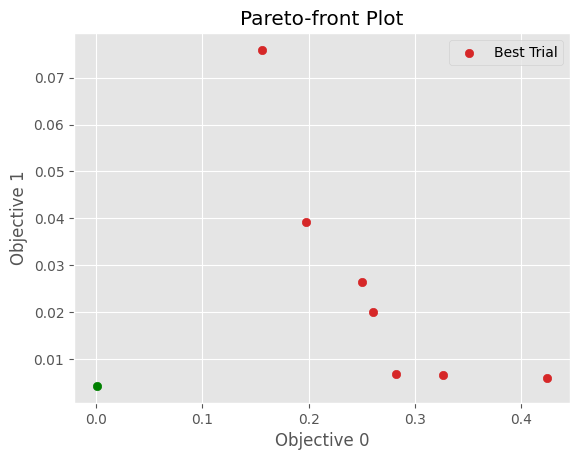

In [173]:
optuna.visualization.matplotlib.plot_pareto_front(opt_trial.study, include_dominated_trials=False)
#plt.xscale('log')
#plt.yscale('log')
plt.scatter(centroid_ground, sigma_ground, color='green')

In [174]:
for t in opt_trial.study.best_trials:
    params = t.params
    vals = t.values
    print(np.sum(np.array(vals)**2)**0.5)

0.2825190249157557
0.42487982426155657
0.32670766620175545
0.26163242899518235
0.1733854439108394
0.2011863771467357
0.25153234009603975


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-4467/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-4467/Downstream_HKB_bender_profile.dat written to disk.


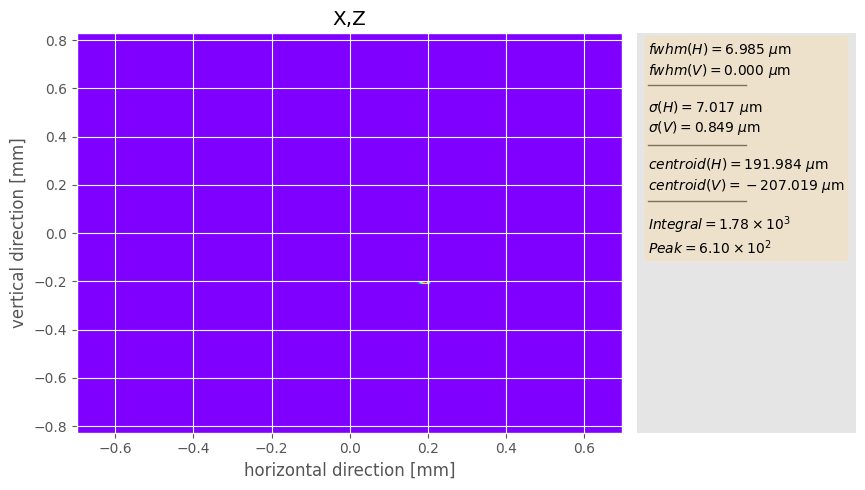

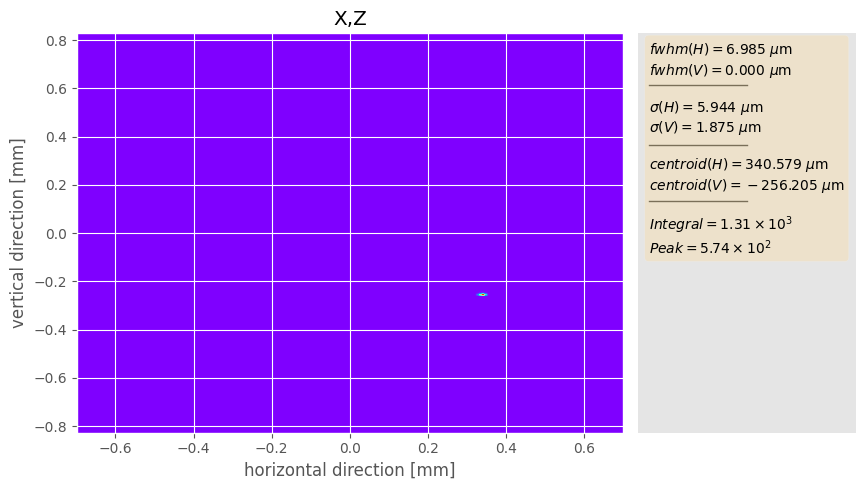

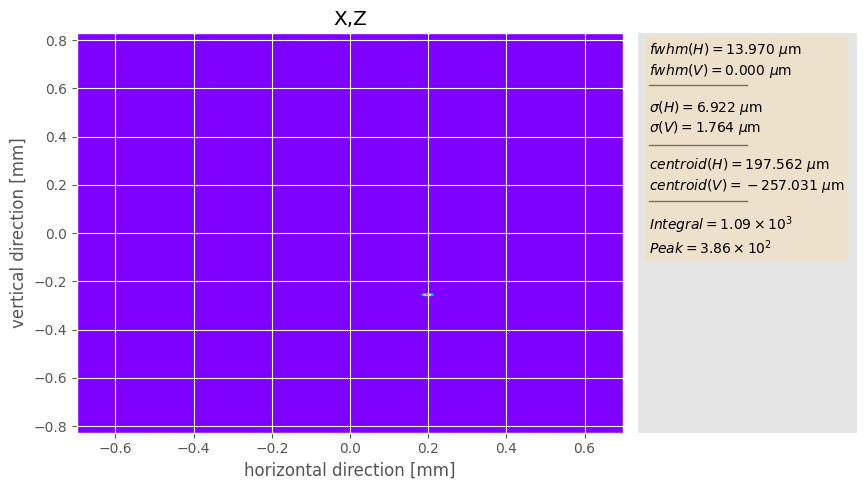

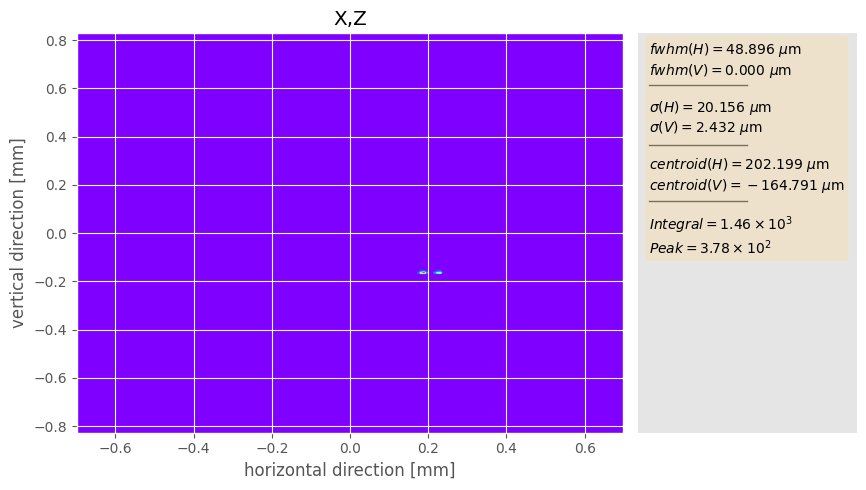

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-4467/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-4467/Downstream_HKB_bender_profile.dat written to disk.


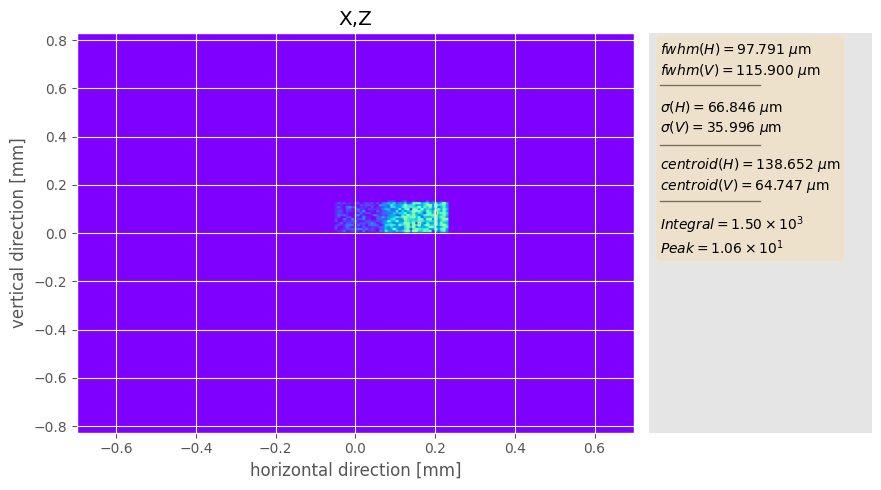

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-4467/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-4467/Downstream_HKB_bender_profile.dat written to disk.


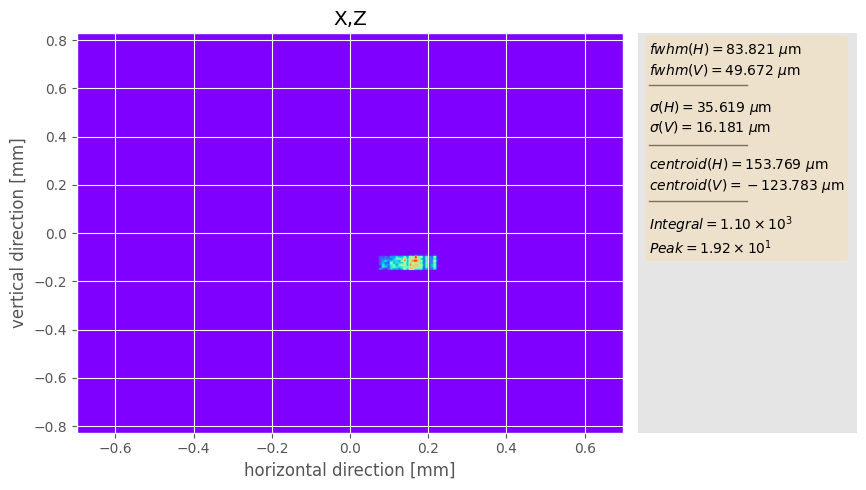

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-4467/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-4467/Downstream_HKB_bender_profile.dat written to disk.


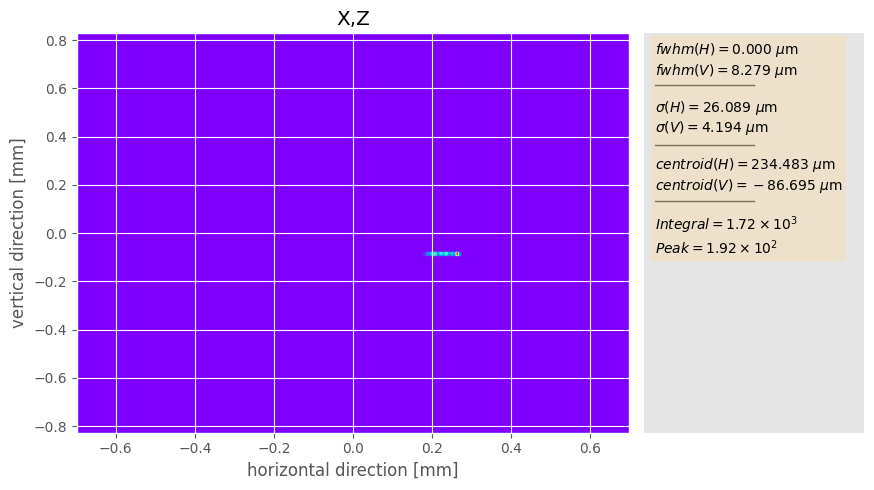

In [175]:
for t in opt_trial.study.best_trials:
    params = t.params
    vals = t.values
    current_params = []
    for mot in opt_trial.motor_types:
        current_params.append(params[mot])
    opt_trial._loss_fn_this(current_params)
    plot_shadow_beam_spatial_distribution(opt_trial.beam_state.photon_beam, xrange=opt_trial._camera_xrange, yrange=opt_trial._camera_yrange)

In [176]:
rms_metric = []
for t in opt_trial.study.best_trials:
    vals = t.values
    rms_metric.append(np.sum(np.array(vals)**2)**0.5)

In [177]:
optimal_params = opt_trial.study.best_trials[np.argmin(rms_metric)].params

In [178]:
optimal_params

{'hb_1': -90.0,
 'hb_2': 42.0,
 'hb_pitch': -0.01099,
 'hb_trans': 3.5,
 'vb_bender': -189.0,
 'vb_pitch': -0.011600000000000001,
 'vb_trans': 4.0}

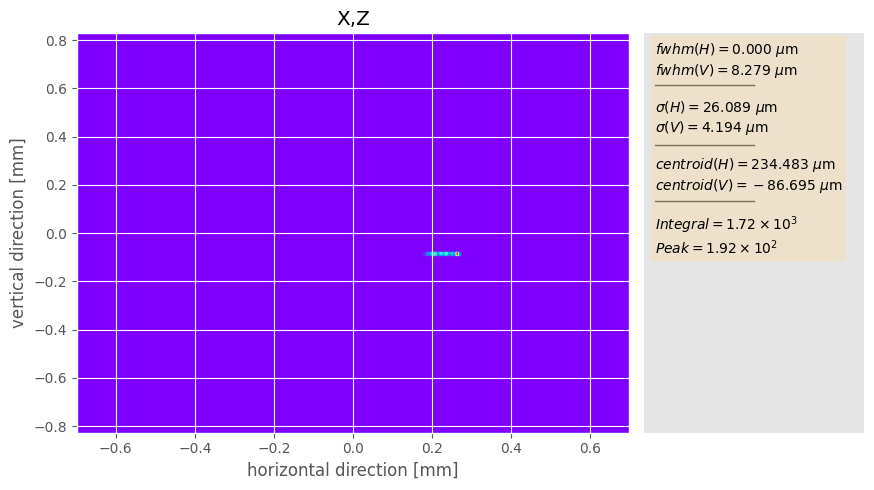

In [179]:
opt_trial._loss_fn_this(current_params)
plot_shadow_beam_spatial_distribution(opt_trial.beam_state.photon_beam, xrange=opt_trial._camera_xrange, yrange=opt_trial._camera_yrange)

### Rerunning the optimization from the best structure

In [180]:
opt_trial = OptunaOptimizer(
    focusing_system,
    motor_types=list(move_motors_ranges.keys()),
    random_seed=DEFAULT_RANDOM_SEED,
    loss_parameters=["centroid", "sigma"],
    use_gaussian_fit=False,
    multi_objective_optimization=True,
    camera_xrange=xrange,
    camera_yrange=yrange,
    # Need to fix the number of camera bins.
    camera_nbins_h=1028, 
    camera_nbins_v=1024
)

In [181]:
constraints = {"sum_intensity": 1.3e3}
opt_trial.set_optimizer_options(
    motor_ranges=list(move_motors_ranges.values()),
    raise_prune_exception=True,
    use_discrete_space=True,
    sum_intensity_threshold=1e3,
    constraints=constraints,
    moo_thresholds={"centroid": 0.02, "sigma": 0.07},
)

[I 2022-11-14 17:59:00,572] A new study created in memory with name: no-name-1474135b-8ad0-40fa-a869-8a9d91735008


In [182]:
opt_trial.trials(20)

/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/trial/_trial.py:618: UserWarning: Fixed parameter 'hb_pitch' with value 0.0 is out of range for distribution FloatDistribution(high=0.01995, log=False, low=-0.02, step=0.00017).
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/trial/_trial.py:618: UserWarning: Fixed parameter 'vb_pitch' with value 0.0 is out of range for distribution FloatDistribution(high=0.0192, log=False, low=-0.02, step=0.0014).
  warnings.warn(
[I 2022-11-14 17:59:03,089] Trial 0 finished with values: [0.2501360187577498, 0.026463165898803598] and parameters: {'hb_1': 0.0, 'hb_2': 0.0, 'hb_pitch': 0.0, 'hb_trans': 0.0, 'vb_bender': 0.0, 'vb_pitch': 0.0, 'vb_trans': 0.0}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-4467/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-4467/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-14 17:59:03,383] Trial 1 finished with values: [0.3720484955790002, 0.09742731589848223] and parameters: {'hb_1': -2.0, 'hb_2': -98.0, 'hb_pitch': -0.01677, 'hb_trans': -11.5, 'vb_bender': -292.0, 'vb_pitch': -0.011600000000000001, 'vb_trans': -15.0}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-4467/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-4467/Downstream_HKB_bender_profile.dat written to disk.


/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/oasys/util/oasys_util.py:283: RuntimeWarning: invalid value encountered in true_divide
  frequency = histogram/numpy.sum(histogram)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/oasys/util/oasys_util.py:292: RuntimeWarning: invalid value encountered in true_divide
  frequency = histogram/numpy.sum(histogram)
[I 2022-11-14 17:59:03,684] Trial 2 pruned. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-4467/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-4467/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-14 17:59:03,989] Trial 3 finished with values: [0.3334227001747114, 0.09828814712734744] and parameters: {'hb_1': -79.0, 'hb_2': -39.0, 'hb_pitch': -0.004359999999999999, 'hb_trans': -10.5, 'vb_bender': -302.0, 'vb_pitch': -0.0017999999999999995, 'vb_trans': 3.0}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-4467/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-4467/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-14 17:59:04,289] Trial 4 finished with values: [0.38165276168562284, 0.16193562558948682] and parameters: {'hb_1': 73.0, 'hb_2': 76.0, 'hb_pitch': -0.002489999999999999, 'hb_trans': 17.5, 'vb_bender': -371.0, 'vb_pitch': 0.0023999999999999994, 'vb_trans': -27.0}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-4467/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-4467/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-14 17:59:04,593] Trial 5 pruned. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-4467/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-4467/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-14 17:59:04,901] Trial 6 finished with values: [0.22155796017562754, 0.09252401713432867] and parameters: {'hb_1': 60.0, 'hb_2': 40.0, 'hb_pitch': -0.01031, 'hb_trans': 30.0, 'vb_bender': 94.0, 'vb_pitch': -0.0144, 'vb_trans': -30.0}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-4467/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-4467/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-14 17:59:05,213] Trial 7 finished with values: [0.3447713625197171, 0.08306278965465153] and parameters: {'hb_1': -23.0, 'hb_2': -21.0, 'hb_pitch': -0.01116, 'hb_trans': -13.5, 'vb_bender': -402.0, 'vb_pitch': 0.0192, 'vb_trans': -19.0}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-4467/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-4467/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-14 17:59:05,521] Trial 8 pruned. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-4467/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-4467/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-14 17:59:05,827] Trial 9 pruned. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-4467/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-4467/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-14 17:59:06,131] Trial 10 finished with values: [0.4038012611541922, 0.1137450089219023] and parameters: {'hb_1': -8.0, 'hb_2': -49.0, 'hb_pitch': 0.009920000000000002, 'hb_trans': 11.5, 'vb_bender': -365.0, 'vb_pitch': 0.0178, 'vb_trans': 22.5}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-4467/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-4467/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-14 17:59:06,430] Trial 11 finished with values: [0.26323079168739466, 0.10201246894583882] and parameters: {'hb_1': 85.0, 'hb_2': -9.0, 'hb_pitch': -0.0070799999999999995, 'hb_trans': 3.0, 'vb_bender': -222.0, 'vb_pitch': 0.014999999999999996, 'vb_trans': 1.5}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-4467/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-4467/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-14 17:59:06,728] Trial 12 finished with values: [0.2696306738655857, 0.0579139974296182] and parameters: {'hb_1': -60.0, 'hb_2': 27.0, 'hb_pitch': 0.015700000000000002, 'hb_trans': 28.0, 'vb_bender': -85.0, 'vb_pitch': -0.02, 'vb_trans': 18.0}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-4467/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-4467/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-14 17:59:07,029] Trial 13 finished with values: [0.31934882151118077, 0.06060702439785922] and parameters: {'hb_1': 14.0, 'hb_2': -45.0, 'hb_pitch': -0.002319999999999999, 'hb_trans': 27.0, 'vb_bender': -195.0, 'vb_pitch': -0.0158, 'vb_trans': 2.5}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-4467/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-4467/Downstream_HKB_bender_profile.dat written to disk.


/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/oasys/util/oasys_util.py:283: RuntimeWarning: invalid value encountered in true_divide
  frequency = histogram/numpy.sum(histogram)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/oasys/util/oasys_util.py:292: RuntimeWarning: invalid value encountered in true_divide
  frequency = histogram/numpy.sum(histogram)
[I 2022-11-14 17:59:08,330] Trial 14 pruned. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-4467/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-4467/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-14 17:59:09,548] Trial 15 finished with values: [0.38789092686695575, 0.15539510805654846] and parameters: {'hb_1': 85.0, 'hb_2': 36.0, 'hb_pitch': 0.002440000000000001, 'hb_trans': -13.5, 'vb_bender': -372.0, 'vb_pitch': 0.012199999999999999, 'vb_trans': -8.0}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-4467/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-4467/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-14 17:59:10,824] Trial 16 finished with values: [0.3000352732218778, 0.09351880400387357] and parameters: {'hb_1': -11.0, 'hb_2': 45.0, 'hb_pitch': -0.006059999999999999, 'hb_trans': -7.5, 'vb_bender': -273.0, 'vb_pitch': -0.0088, 'vb_trans': -15.0}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-4467/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-4467/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-14 17:59:12,161] Trial 17 finished with values: [0.3828430294427567, 0.08886784521943729] and parameters: {'hb_1': 82.0, 'hb_2': -54.0, 'hb_pitch': -0.0065699999999999995, 'hb_trans': 10.0, 'vb_bender': -315.0, 'vb_pitch': 0.003799999999999998, 'vb_trans': -23.0}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-4467/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-4467/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-14 17:59:13,457] Trial 18 finished with values: [0.2629867027763404, 0.10818936457802117] and parameters: {'hb_1': -32.0, 'hb_2': -91.0, 'hb_pitch': -0.0065699999999999995, 'hb_trans': 16.5, 'vb_bender': -116.0, 'vb_pitch': -0.011600000000000001, 'vb_trans': 29.0}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-4467/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-4467/Downstream_HKB_bender_profile.dat written to disk.


/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/oasys/util/oasys_util.py:283: RuntimeWarning: invalid value encountered in true_divide
  frequency = histogram/numpy.sum(histogram)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/oasys/util/oasys_util.py:292: RuntimeWarning: invalid value encountered in true_divide
  frequency = histogram/numpy.sum(histogram)
[I 2022-11-14 17:59:14,795] Trial 19 pruned. 


In [183]:
opt_trial.study.enqueue_trial({mt: 0.0 for mt in opt_trial.motor_types})

In [184]:
opt_trial.trials(25, trial_motor_types=["hb_pitch", "hb_trans", "vb_pitch", "vb_trans"])

/Users/skandel/code/oasys/AI-ML_Control_System/aps/ai/autoalignment/beamline28IDB/optimization/optuna_botorch.py:463: ExperimentalWarning: PartialFixedSampler is experimental (supported from v2.4.0). The interface can change in the future.
  partial_sampler = optuna.samplers.PartialFixedSampler(fixed_params, self._base_sampler)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/trial/_trial.py:618: UserWarning: Fixed parameter 'hb_pitch' with value 0.0 is out of range for distribution FloatDistribution(high=0.01995, log=False, low=-0.02, step=0.00017).
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/trial/_trial.py:618: UserWarning: Fixed parameter 'vb_pitch' with value 0.0 is out of range for distribution FloatDistribution(high=0.0192, log=False, low=-0.02, step=0.0014).
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-4467/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-4467/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-14 17:59:16,137] Trial 20 finished with values: [0.2514136159128351, 0.026499336118941084] and parameters: {'hb_1': 0.0, 'hb_2': 0.0, 'hb_pitch': 0.0, 'hb_trans': 0.0, 'vb_bender': 0.0, 'vb_pitch': 0.0, 'vb_trans': 0.0}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(
[I 2022-11-14 17:59:17,425] Trial 21 finished with values: [0.23542002511671095, 0.020137986443438723] and parameters: {'hb_1': 0.0, 'hb_2': 0.0, 'hb_pitch': -0.00861, 'hb_trans': 8.0, 'vb_bender': 0.0, 'vb_pitch': 0.012199999999999999, 'vb_trans': -14.0}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(
[I 2022-11-14 17:59:18,698] Trial 22 finished wit

In [185]:
opt_trial.study.best_trials

[FrozenTrial(number=23, values=[0.2780797061892412, 0.013899013438954744], datetime_start=datetime.datetime(2022, 11, 14, 17, 59, 18, 699491), datetime_complete=datetime.datetime(2022, 11, 14, 17, 59, 19, 890827), params={'hb_1': 0.0, 'hb_2': 0.0, 'hb_pitch': 0.010260000000000002, 'hb_trans': 28.5, 'vb_bender': 0.0, 'vb_pitch': -0.018600000000000002, 'vb_trans': -19.0}, distributions={'hb_1': FloatDistribution(high=100.0, log=False, low=-100.0, step=1.0), 'hb_2': FloatDistribution(high=100.0, log=False, low=-100.0, step=1.0), 'hb_pitch': FloatDistribution(high=0.01995, log=False, low=-0.02, step=0.00017), 'hb_trans': FloatDistribution(high=30.0, log=False, low=-30.0, step=0.5), 'vb_bender': FloatDistribution(high=500.0, log=False, low=-500.0, step=1.0), 'vb_pitch': FloatDistribution(high=0.0192, log=False, low=-0.02, step=0.0014), 'vb_trans': FloatDistribution(high=30.0, log=False, low=-30.0, step=0.5)}, user_attrs={'sum_intensity_constraint': -1, 'dw': <aps.common.ml.data_structures.D

/var/folders/gn/ggsvq37x5sv5bb1j9chn8mmw0000gr/T/ipykernel_79926/1036378160.py:1: ExperimentalWarning: plot_pareto_front is experimental (supported from v2.8.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_pareto_front(opt_trial.study, include_dominated_trials=False)


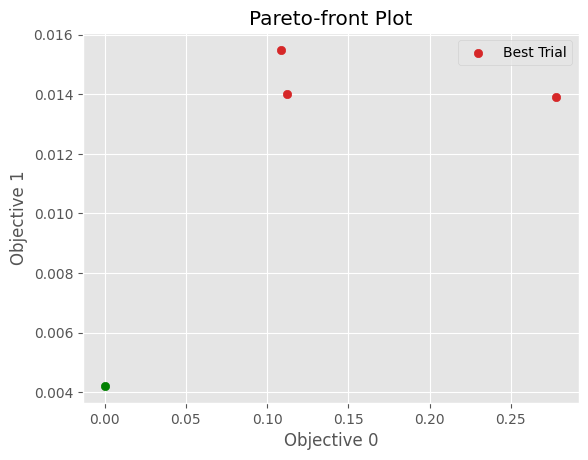

In [186]:
optuna.visualization.matplotlib.plot_pareto_front(opt_trial.study, include_dominated_trials=False)
#plt.xscale('log')
#plt.yscale('log')
plt.scatter(centroid_ground, sigma_ground, color='green')

In [187]:
for t in opt_trial.study.best_trials:
    params = t.params
    vals = t.values
    print(np.log(vals).sum(), t.user_attrs['dw'])

-5.555784910453998 h_sigma: 0.013569634030560444
h_fwhm: 0.004097276264591332
h_centroid: -0.02093731281663842
v_sigma: 0.0030079240104930356
v_fwhm: 0.008124999999999938
v_centroid: 0.27729037474516305
integral_intensity: 1557.5023784541363
peak_intensity: 25.88393019090961
gaussian_fit: {}

-6.453811886674227 h_sigma: 0.013382491894237672
h_fwhm: 0.004097276264591332
h_centroid: -0.050711047699010095
v_sigma: 0.004085041606579042
v_fwhm: 0.011374999999999913
v_centroid: 0.10045420734374672
integral_intensity: 2021.7918588423263
peak_intensity: 25.898945495761225
gaussian_fit: {}

-6.386340119038154 h_sigma: 0.014939106497787687
h_fwhm: 0.004097276264591332
h_centroid: 0.003934086981410685
v_sigma: 0.0040768643372186
v_fwhm: 0.0129999999999999
v_centroid: 0.10870285802690442
integral_intensity: 2082.7281091743675
peak_intensity: 30.31352058740999
gaussian_fit: {}



[0.2780797061892412, 0.013899013438954744]


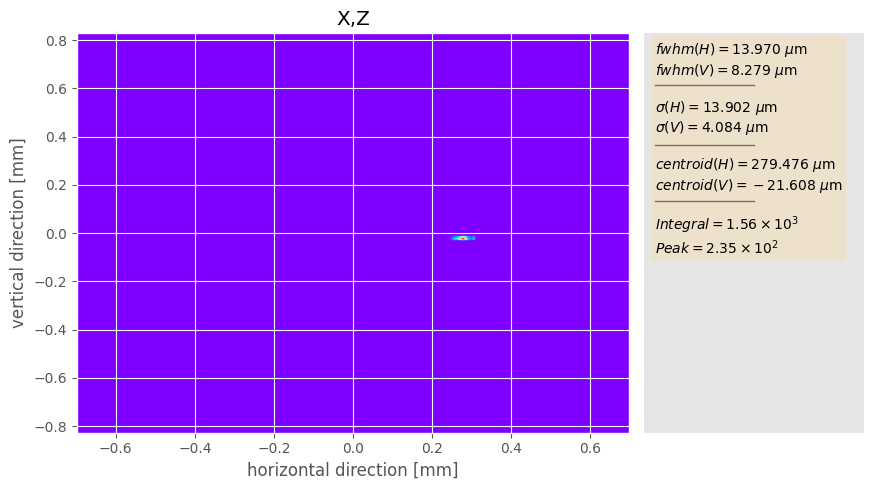

[0.11252847698157002, 0.013992092560686514]


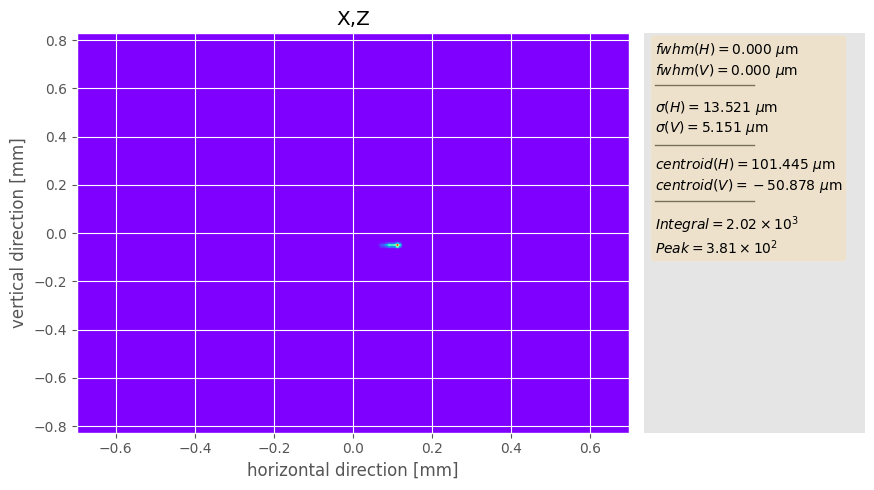

[0.10877402439734703, 0.015485403636209394]


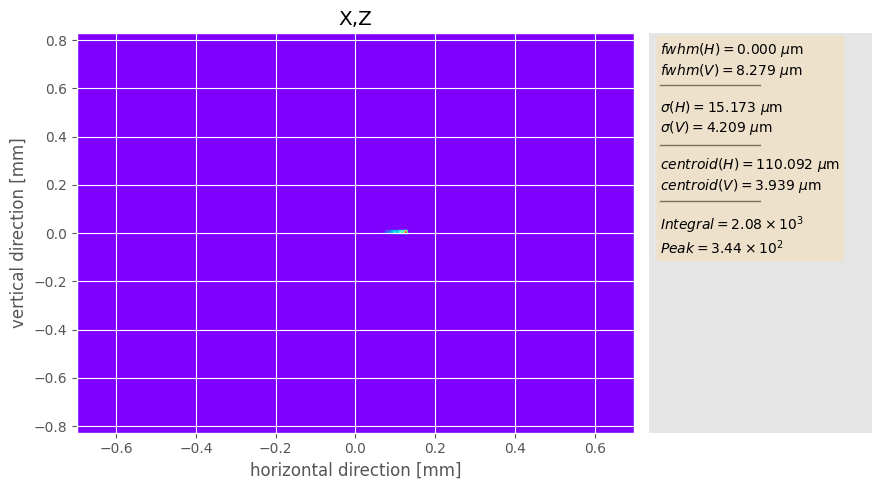

In [188]:
for t in opt_trial.study.best_trials:
    params = t.params
    vals = t.values
    current_params = []
    for mot in opt_trial.motor_types:
        current_params.append(params[mot])
    opt_trial._loss_fn_this(current_params)
    print(t.values)
    plot_shadow_beam_spatial_distribution(opt_trial.beam_state.photon_beam, xrange=opt_trial._camera_xrange, yrange=opt_trial._camera_yrange)

In [189]:
opt_trial.trials(75)

/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-4467/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-4467/Downstream_HKB_bender_profile.dat written to disk.


/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/oasys/util/oasys_util.py:283: RuntimeWarning: invalid value encountered in true_divide
  frequency = histogram/numpy.sum(histogram)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/oasys/util/oasys_util.py:292: RuntimeWarning: invalid value encountered in true_divide
  frequency = histogram/numpy.sum(histogram)
[I 2022-11-14 18:56:35,258] Trial 45 pruned. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-4467/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-4467/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-14 18:56:38,231] Trial 46 finished with values: [0.35814762220128665, 0.03218612523650111] and parameters: {'hb_1': -8.0, 'hb_2': -53.0, 'hb_pitch': 0.008730000000000002, 'hb_trans': -27.5, 'vb_bender': -54.0, 'vb_pitch': -0.011600000000000001, 'vb_trans': 12.0}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-4467/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-4467/Downstream_HKB_bender_profile.dat written to disk.


/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/oasys/util/oasys_util.py:283: RuntimeWarning: invalid value encountered in true_divide
  frequency = histogram/numpy.sum(histogram)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/oasys/util/oasys_util.py:292: RuntimeWarning: invalid value encountered in true_divide
  frequency = histogram/numpy.sum(histogram)
[I 2022-11-14 18:56:40,430] Trial 47 pruned. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-4467/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-4467/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-14 18:56:43,126] Trial 48 finished with values: [0.3790140026745765, 0.06716823162051837] and parameters: {'hb_1': 49.0, 'hb_2': -15.0, 'hb_pitch': 0.014850000000000006, 'hb_trans': -18.5, 'vb_bender': -76.0, 'vb_pitch': -0.0032000000000000015, 'vb_trans': 4.5}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-4467/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-4467/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-14 18:56:45,814] Trial 49 finished with values: [0.45483576985893437, 0.20623882542628333] and parameters: {'hb_1': 89.0, 'hb_2': 71.0, 'hb_pitch': 0.016720000000000002, 'hb_trans': 9.0, 'vb_bender': -439.0, 'vb_pitch': 0.0178, 'vb_trans': 23.5}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-4467/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-4467/Downstream_HKB_bender_profile.dat written to disk.


/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/oasys/util/oasys_util.py:283: RuntimeWarning: invalid value encountered in true_divide
  frequency = histogram/numpy.sum(histogram)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/oasys/util/oasys_util.py:292: RuntimeWarning: invalid value encountered in true_divide
  frequency = histogram/numpy.sum(histogram)
[I 2022-11-14 18:56:48,247] Trial 50 pruned. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-4467/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-4467/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-14 18:56:50,255] Trial 51 finished with values: [0.06040924698744567, 0.058734317000719204] and parameters: {'hb_1': -67.0, 'hb_2': 35.0, 'hb_pitch': -0.02, 'hb_trans': 28.0, 'vb_bender': 27.0, 'vb_pitch': -0.0172, 'vb_trans': -19.0}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-4467/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-4467/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-14 18:56:52,154] Trial 52 finished with values: [0.20726489181396232, 0.038526004557634164] and parameters: {'hb_1': -41.0, 'hb_2': 7.0, 'hb_pitch': -0.01694, 'hb_trans': 2.5, 'vb_bender': 150.0, 'vb_pitch': -0.013000000000000001, 'vb_trans': 5.5}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-4467/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-4467/Downstream_HKB_bender_profile.dat written to disk.


/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/oasys/util/oasys_util.py:283: RuntimeWarning: invalid value encountered in true_divide
  frequency = histogram/numpy.sum(histogram)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/oasys/util/oasys_util.py:292: RuntimeWarning: invalid value encountered in true_divide
  frequency = histogram/numpy.sum(histogram)
[I 2022-11-14 18:56:53,864] Trial 53 pruned. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-4467/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-4467/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-14 18:56:55,569] Trial 54 finished with values: [0.03981491590327275, 0.11624403346209554] and parameters: {'hb_1': -98.0, 'hb_2': 99.0, 'hb_pitch': -0.01898, 'hb_trans': -23.0, 'vb_bender': 32.0, 'vb_pitch': -0.0158, 'vb_trans': 11.5}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-4467/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-4467/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-14 18:56:57,296] Trial 55 finished with values: [0.049722930856727084, 0.08892786208241317] and parameters: {'hb_1': -47.0, 'hb_2': 92.0, 'hb_pitch': -0.01779, 'hb_trans': 30.0, 'vb_bender': -21.0, 'vb_pitch': -0.0088, 'vb_trans': -29.0}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-4467/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-4467/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-14 18:56:59,634] Trial 56 finished with values: [0.034633568859501744, 0.05431176484968838] and parameters: {'hb_1': -49.0, 'hb_2': 48.0, 'hb_pitch': -0.02, 'hb_trans': 30.0, 'vb_bender': -29.0, 'vb_pitch': -0.0158, 'vb_trans': 17.5}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-4467/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-4467/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-14 18:57:01,404] Trial 57 finished with values: [0.03169535625676262, 0.0847949415412403] and parameters: {'hb_1': -51.0, 'hb_2': 83.0, 'hb_pitch': -0.01932, 'hb_trans': 19.5, 'vb_bender': -32.0, 'vb_pitch': -0.0172, 'vb_trans': 8.5}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-4467/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-4467/Downstream_HKB_bender_profile.dat written to disk.


/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/oasys/util/oasys_util.py:283: RuntimeWarning: invalid value encountered in true_divide
  frequency = histogram/numpy.sum(histogram)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/oasys/util/oasys_util.py:292: RuntimeWarning: invalid value encountered in true_divide
  frequency = histogram/numpy.sum(histogram)
[I 2022-11-14 18:57:03,393] Trial 58 pruned. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-4467/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-4467/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-14 18:57:05,385] Trial 59 finished with values: [0.08188544096989568, 0.053132151829543596] and parameters: {'hb_1': -89.0, 'hb_2': 28.0, 'hb_pitch': -0.01864, 'hb_trans': -19.0, 'vb_bender': -44.0, 'vb_pitch': -0.018600000000000002, 'vb_trans': 4.0}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-4467/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-4467/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-14 18:57:07,524] Trial 60 finished with values: [0.037501896965579325, 0.08480575692796599] and parameters: {'hb_1': -100.0, 'hb_2': 36.0, 'hb_pitch': -0.02, 'hb_trans': 21.0, 'vb_bender': -69.0, 'vb_pitch': 0.009399999999999999, 'vb_trans': 25.0}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-4467/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-4467/Downstream_HKB_bender_profile.dat written to disk.


/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/oasys/util/oasys_util.py:283: RuntimeWarning: invalid value encountered in true_divide
  frequency = histogram/numpy.sum(histogram)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/oasys/util/oasys_util.py:292: RuntimeWarning: invalid value encountered in true_divide
  frequency = histogram/numpy.sum(histogram)
[I 2022-11-14 18:57:09,402] Trial 61 pruned. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-4467/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-4467/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-14 18:57:11,372] Trial 62 finished with values: [0.024198339503398322, 0.06959647208011838] and parameters: {'hb_1': -82.0, 'hb_2': 41.0, 'hb_pitch': -0.01779, 'hb_trans': 25.5, 'vb_bender': 12.0, 'vb_pitch': -0.0172, 'vb_trans': 9.5}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-4467/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-4467/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-14 18:57:13,601] Trial 63 finished with values: [0.029618134498536276, 0.0593073292332564] and parameters: {'hb_1': -70.0, 'hb_2': 41.0, 'hb_pitch': -0.02, 'hb_trans': 20.0, 'vb_bender': -6.0, 'vb_pitch': -0.0088, 'vb_trans': 21.0}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-4467/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-4467/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-14 18:57:15,733] Trial 64 finished with values: [0.07108458585657552, 0.05637790184922924] and parameters: {'hb_1': -56.0, 'hb_2': 49.0, 'hb_pitch': -0.01898, 'hb_trans': 24.5, 'vb_bender': -4.0, 'vb_pitch': -0.00040000000000000105, 'vb_trans': 16.0}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-4467/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-4467/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-14 18:57:17,754] Trial 65 finished with values: [0.025203601325334037, 0.11248088442165642] and parameters: {'hb_1': -64.0, 'hb_2': 83.0, 'hb_pitch': -0.01983, 'hb_trans': -26.0, 'vb_bender': -118.0, 'vb_pitch': 0.006599999999999998, 'vb_trans': 5.0}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-4467/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-4467/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-14 18:57:20,204] Trial 66 finished with values: [0.06175669483952924, 0.07796724084301813] and parameters: {'hb_1': -96.0, 'hb_2': 2.0, 'hb_pitch': -0.01898, 'hb_trans': 10.0, 'vb_bender': -47.0, 'vb_pitch': -0.013000000000000001, 'vb_trans': 9.0}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-4467/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-4467/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-14 18:57:22,565] Trial 67 finished with values: [0.029279929091696216, 0.06289164786121523] and parameters: {'hb_1': -75.0, 'hb_2': 41.0, 'hb_pitch': -0.02, 'hb_trans': 21.0, 'vb_bender': -6.0, 'vb_pitch': -0.018600000000000002, 'vb_trans': 25.0}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-4467/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-4467/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-14 18:57:24,370] Trial 68 finished with values: [0.05605016278135046, 0.06304743913420698] and parameters: {'hb_1': -62.0, 'hb_2': 50.0, 'hb_pitch': -0.01337, 'hb_trans': 22.5, 'vb_bender': -85.0, 'vb_pitch': -0.0017999999999999995, 'vb_trans': -1.0}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-4467/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-4467/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-14 18:57:26,657] Trial 69 finished with values: [0.11971712259038492, 0.10428148697355143] and parameters: {'hb_1': -90.0, 'hb_2': 95.0, 'hb_pitch': -0.01983, 'hb_trans': 29.0, 'vb_bender': -145.0, 'vb_pitch': -0.0074, 'vb_trans': 8.0}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-4467/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-4467/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-14 18:57:29,035] Trial 70 finished with values: [0.04493512626802354, 0.059505862710572295] and parameters: {'hb_1': -72.0, 'hb_2': 39.0, 'hb_pitch': -0.02, 'hb_trans': -6.0, 'vb_bender': -82.0, 'vb_pitch': 0.0023999999999999994, 'vb_trans': 13.5}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-4467/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-4467/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-14 18:57:31,028] Trial 71 finished with values: [0.09306434802112204, 0.06220841362490305] and parameters: {'hb_1': -93.0, 'hb_2': 39.0, 'hb_pitch': -0.01439, 'hb_trans': -7.5, 'vb_bender': -38.0, 'vb_pitch': 0.003799999999999998, 'vb_trans': 1.5}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-4467/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-4467/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-14 18:57:33,344] Trial 72 finished with values: [0.08544824047968386, 0.06361983139974918] and parameters: {'hb_1': -64.0, 'hb_2': 43.0, 'hb_pitch': -0.01813, 'hb_trans': 18.0, 'vb_bender': -93.0, 'vb_pitch': -0.0102, 'vb_trans': 29.5}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-4467/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-4467/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-14 18:57:35,569] Trial 73 finished with values: [0.44449163823883486, 0.10261348913410409] and parameters: {'hb_1': -2.0, 'hb_2': -33.0, 'hb_pitch': -0.002659999999999999, 'hb_trans': -3.0, 'vb_bender': -389.0, 'vb_pitch': -0.0032000000000000015, 'vb_trans': 7.0}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-4467/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-4467/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-14 18:57:37,776] Trial 74 finished with values: [0.07156754478295427, 0.07586257128056553] and parameters: {'hb_1': -73.0, 'hb_2': 64.0, 'hb_pitch': -0.01456, 'hb_trans': 16.0, 'vb_bender': -106.0, 'vb_pitch': 0.0192, 'vb_trans': -9.0}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-4467/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-4467/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-14 18:57:39,865] Trial 75 finished with values: [0.29467770012399735, 0.0182544756108454] and parameters: {'hb_1': -16.0, 'hb_2': -39.0, 'hb_pitch': 0.002270000000000001, 'hb_trans': -16.5, 'vb_bender': -4.0, 'vb_pitch': -0.0172, 'vb_trans': 27.0}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-4467/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-4467/Downstream_HKB_bender_profile.dat written to disk.


/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/oasys/util/oasys_util.py:283: RuntimeWarning: invalid value encountered in true_divide
  frequency = histogram/numpy.sum(histogram)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/oasys/util/oasys_util.py:292: RuntimeWarning: invalid value encountered in true_divide
  frequency = histogram/numpy.sum(histogram)
[I 2022-11-14 18:57:42,083] Trial 76 pruned. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-4467/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-4467/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-14 18:57:44,228] Trial 77 finished with values: [0.03748748885060736, 0.0710434758821525] and parameters: {'hb_1': -100.0, 'hb_2': 41.0, 'hb_pitch': -0.01813, 'hb_trans': -4.0, 'vb_bender': -129.0, 'vb_pitch': 0.009399999999999999, 'vb_trans': -20.5}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-4467/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-4467/Downstream_HKB_bender_profile.dat written to disk.


/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/oasys/util/oasys_util.py:283: RuntimeWarning: invalid value encountered in true_divide
  frequency = histogram/numpy.sum(histogram)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/oasys/util/oasys_util.py:292: RuntimeWarning: invalid value encountered in true_divide
  frequency = histogram/numpy.sum(histogram)
[I 2022-11-14 18:57:46,478] Trial 78 pruned. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-4467/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-4467/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-14 18:57:48,569] Trial 79 finished with values: [0.0731812901767431, 0.05634574181539438] and parameters: {'hb_1': -53.0, 'hb_2': 36.0, 'hb_pitch': -0.01881, 'hb_trans': -10.0, 'vb_bender': -107.0, 'vb_pitch': 0.009399999999999999, 'vb_trans': -25.0}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-4467/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-4467/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-14 18:57:50,640] Trial 80 finished with values: [0.5062969430073107, 0.0950150446026569] and parameters: {'hb_1': -86.0, 'hb_2': -1.0, 'hb_pitch': 0.017060000000000002, 'hb_trans': -23.0, 'vb_bender': -347.0, 'vb_pitch': -0.02, 'vb_trans': 2.0}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-4467/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-4467/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-14 18:57:52,966] Trial 81 finished with values: [0.1916658591989892, 0.07998084493009933] and parameters: {'hb_1': -90.0, 'hb_2': 42.0, 'hb_pitch': -0.01099, 'hb_trans': 3.5, 'vb_bender': -189.0, 'vb_pitch': -0.011600000000000001, 'vb_trans': 4.0}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-4467/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-4467/Downstream_HKB_bender_profile.dat written to disk.


/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/oasys/util/oasys_util.py:283: RuntimeWarning: invalid value encountered in true_divide
  frequency = histogram/numpy.sum(histogram)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/oasys/util/oasys_util.py:292: RuntimeWarning: invalid value encountered in true_divide
  frequency = histogram/numpy.sum(histogram)
[I 2022-11-14 18:57:55,183] Trial 82 pruned. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-4467/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-4467/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-14 18:57:57,514] Trial 83 finished with values: [0.04114040983328865, 0.06265330393482985] and parameters: {'hb_1': -72.0, 'hb_2': 50.0, 'hb_pitch': -0.01847, 'hb_trans': -2.5, 'vb_bender': -14.0, 'vb_pitch': -0.0158, 'vb_trans': 5.5}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-4467/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-4467/Downstream_HKB_bender_profile.dat written to disk.


/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/oasys/util/oasys_util.py:283: RuntimeWarning: invalid value encountered in true_divide
  frequency = histogram/numpy.sum(histogram)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/oasys/util/oasys_util.py:292: RuntimeWarning: invalid value encountered in true_divide
  frequency = histogram/numpy.sum(histogram)
[I 2022-11-14 18:58:00,039] Trial 84 pruned. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-4467/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-4467/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-14 18:58:02,298] Trial 85 finished with values: [0.06358703147879975, 0.06236034922584066] and parameters: {'hb_1': -84.0, 'hb_2': 27.0, 'hb_pitch': -0.02, 'hb_trans': -21.0, 'vb_bender': -137.0, 'vb_pitch': 0.0164, 'vb_trans': 13.5}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-4467/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-4467/Downstream_HKB_bender_profile.dat written to disk.


/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/oasys/util/oasys_util.py:283: RuntimeWarning: invalid value encountered in true_divide
  frequency = histogram/numpy.sum(histogram)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/oasys/util/oasys_util.py:292: RuntimeWarning: invalid value encountered in true_divide
  frequency = histogram/numpy.sum(histogram)
[I 2022-11-14 18:58:04,472] Trial 86 pruned. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-4467/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-4467/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-14 18:58:07,309] Trial 87 finished with values: [0.2681268469687476, 0.12252399723356026] and parameters: {'hb_1': 46.0, 'hb_2': 55.0, 'hb_pitch': 0.0073700000000000015, 'hb_trans': -11.0, 'vb_bender': -65.0, 'vb_pitch': -0.0144, 'vb_trans': 9.0}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-4467/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-4467/Downstream_HKB_bender_profile.dat written to disk.


/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/oasys/util/oasys_util.py:283: RuntimeWarning: invalid value encountered in true_divide
  frequency = histogram/numpy.sum(histogram)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/oasys/util/oasys_util.py:292: RuntimeWarning: invalid value encountered in true_divide
  frequency = histogram/numpy.sum(histogram)
[I 2022-11-14 18:58:09,684] Trial 88 pruned. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-4467/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-4467/Downstream_HKB_bender_profile.dat written to disk.


/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/oasys/util/oasys_util.py:283: RuntimeWarning: invalid value encountered in true_divide
  frequency = histogram/numpy.sum(histogram)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/oasys/util/oasys_util.py:292: RuntimeWarning: invalid value encountered in true_divide
  frequency = histogram/numpy.sum(histogram)
[I 2022-11-14 18:58:12,091] Trial 89 pruned. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-4467/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-4467/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-14 18:58:15,057] Trial 90 finished with values: [0.3270838140956761, 0.06821191551520528] and parameters: {'hb_1': -92.0, 'hb_2': -45.0, 'hb_pitch': 0.011280000000000002, 'hb_trans': -19.5, 'vb_bender': -40.0, 'vb_pitch': 0.0023999999999999994, 'vb_trans': -12.0}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-4467/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-4467/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-14 18:58:17,596] Trial 91 finished with values: [0.05208356232212075, 0.06103065691141003] and parameters: {'hb_1': -49.0, 'hb_2': 41.0, 'hb_pitch': -0.01949, 'hb_trans': 21.0, 'vb_bender': -129.0, 'vb_pitch': 0.0052, 'vb_trans': 15.5}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-4467/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-4467/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-14 18:58:21,169] Trial 92 finished with values: [0.34620274404674845, 0.07384013375964067] and parameters: {'hb_1': 37.0, 'hb_2': -100.0, 'hb_pitch': -0.001469999999999999, 'hb_trans': -6.0, 'vb_bender': -100.0, 'vb_pitch': 0.0052, 'vb_trans': -2.5}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-4467/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-4467/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-14 18:58:23,965] Trial 93 finished with values: [0.2729165660136679, 0.15854269067264667] and parameters: {'hb_1': 45.0, 'hb_2': 84.0, 'hb_pitch': -0.004359999999999999, 'hb_trans': 11.0, 'vb_bender': -331.0, 'vb_pitch': 0.013599999999999998, 'vb_trans': -2.0}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-4467/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-4467/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-14 18:58:26,369] Trial 94 finished with values: [0.520181929652035, 0.13433534870426017] and parameters: {'hb_1': 81.0, 'hb_2': -76.0, 'hb_pitch': -0.00997, 'hb_trans': -13.0, 'vb_bender': -384.0, 'vb_pitch': -0.02, 'vb_trans': 26.5}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-4467/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-4467/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-14 18:58:28,520] Trial 95 finished with values: [0.31361507260865784, 0.1037899446989137] and parameters: {'hb_1': -57.0, 'hb_2': -80.0, 'hb_pitch': -0.01575, 'hb_trans': -4.5, 'vb_bender': -225.0, 'vb_pitch': -0.02, 'vb_trans': -9.5}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-4467/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-4467/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-14 18:58:31,322] Trial 96 finished with values: [0.3534309088212429, 0.11140472229804181] and parameters: {'hb_1': -69.0, 'hb_2': -76.0, 'hb_pitch': 0.0015900000000000011, 'hb_trans': -14.0, 'vb_bender': -243.0, 'vb_pitch': -0.0017999999999999995, 'vb_trans': 26.0}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-4467/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-4467/Downstream_HKB_bender_profile.dat written to disk.


/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/oasys/util/oasys_util.py:283: RuntimeWarning: invalid value encountered in true_divide
  frequency = histogram/numpy.sum(histogram)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/oasys/util/oasys_util.py:292: RuntimeWarning: invalid value encountered in true_divide
  frequency = histogram/numpy.sum(histogram)
[I 2022-11-14 18:58:33,725] Trial 97 pruned. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-4467/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-4467/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-14 18:58:35,842] Trial 98 finished with values: [0.3488493867759197, 0.0516684680609232] and parameters: {'hb_1': -49.0, 'hb_2': 40.0, 'hb_pitch': 0.018420000000000002, 'hb_trans': 22.0, 'vb_bender': 121.0, 'vb_pitch': -0.0046, 'vb_trans': -22.0}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-4467/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-4467/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-14 18:58:37,829] Trial 99 finished with values: [0.5459099185809618, 0.09706500843094219] and parameters: {'hb_1': -34.0, 'hb_2': 11.0, 'hb_pitch': 0.003970000000000001, 'hb_trans': -12.5, 'vb_bender': -443.0, 'vb_pitch': -0.013000000000000001, 'vb_trans': -20.5}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-4467/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-4467/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-14 18:58:40,567] Trial 100 finished with values: [0.2534325999556612, 0.11153113740587992] and parameters: {'hb_1': -51.0, 'hb_2': -95.0, 'hb_pitch': -0.01048, 'hb_trans': -4.5, 'vb_bender': -230.0, 'vb_pitch': 0.0164, 'vb_trans': -18.5}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-4467/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-4467/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-14 18:58:43,297] Trial 101 finished with values: [0.03142324441766902, 0.05907014266167712] and parameters: {'hb_1': -51.0, 'hb_2': 56.0, 'hb_pitch': -0.01728, 'hb_trans': 29.5, 'vb_bender': -11.0, 'vb_pitch': -0.011600000000000001, 'vb_trans': 4.0}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-4467/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-4467/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-14 18:58:45,716] Trial 102 finished with values: [0.23171756816208305, 0.07706755321124996] and parameters: {'hb_1': 3.0, 'hb_2': 5.0, 'hb_pitch': -0.0077599999999999995, 'hb_trans': 27.0, 'vb_bender': -246.0, 'vb_pitch': 0.006599999999999998, 'vb_trans': 29.5}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-4467/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-4467/Downstream_HKB_bender_profile.dat written to disk.


/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/oasys/util/oasys_util.py:283: RuntimeWarning: invalid value encountered in true_divide
  frequency = histogram/numpy.sum(histogram)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/oasys/util/oasys_util.py:292: RuntimeWarning: invalid value encountered in true_divide
  frequency = histogram/numpy.sum(histogram)
[I 2022-11-14 18:58:48,219] Trial 103 pruned. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-4467/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-4467/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-14 18:58:51,307] Trial 104 finished with values: [0.142141366552087, 0.0841676190349545] and parameters: {'hb_1': -93.0, 'hb_2': 17.0, 'hb_pitch': -0.01031, 'hb_trans': -3.5, 'vb_bender': -217.0, 'vb_pitch': 0.014999999999999996, 'vb_trans': 20.0}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-4467/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-4467/Downstream_HKB_bender_profile.dat written to disk.


/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/oasys/util/oasys_util.py:283: RuntimeWarning: invalid value encountered in true_divide
  frequency = histogram/numpy.sum(histogram)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/oasys/util/oasys_util.py:292: RuntimeWarning: invalid value encountered in true_divide
  frequency = histogram/numpy.sum(histogram)
[I 2022-11-14 18:58:54,185] Trial 105 pruned. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-4467/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-4467/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-14 18:58:56,658] Trial 106 finished with values: [0.3848369328945861, 0.08042692945775877] and parameters: {'hb_1': 39.0, 'hb_2': 15.0, 'hb_pitch': 0.013149999999999998, 'hb_trans': -13.0, 'vb_bender': 110.0, 'vb_pitch': -0.0046, 'vb_trans': -9.0}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-4467/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-4467/Downstream_HKB_bender_profile.dat written to disk.


/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/oasys/util/oasys_util.py:283: RuntimeWarning: invalid value encountered in true_divide
  frequency = histogram/numpy.sum(histogram)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/oasys/util/oasys_util.py:292: RuntimeWarning: invalid value encountered in true_divide
  frequency = histogram/numpy.sum(histogram)
[I 2022-11-14 18:58:59,847] Trial 107 pruned. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-4467/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-4467/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-14 18:59:02,309] Trial 108 finished with values: [0.2717630288551144, 0.048621447473641284] and parameters: {'hb_1': -75.0, 'hb_2': 19.0, 'hb_pitch': 0.012469999999999998, 'hb_trans': -1.5, 'vb_bender': -54.0, 'vb_pitch': 0.012199999999999999, 'vb_trans': -14.0}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-4467/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-4467/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-14 18:59:05,173] Trial 109 finished with values: [0.2328817548172683, 0.10415001187170626] and parameters: {'hb_1': -95.0, 'hb_2': 67.0, 'hb_pitch': -0.0036799999999999992, 'hb_trans': -14.0, 'vb_bender': -237.0, 'vb_pitch': -0.006, 'vb_trans': 13.0}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-4467/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-4467/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-14 18:59:07,762] Trial 110 finished with values: [0.12179479020743858, 0.08014814136602412] and parameters: {'hb_1': -41.0, 'hb_2': 71.0, 'hb_pitch': -0.01643, 'hb_trans': 9.0, 'vb_bender': 72.0, 'vb_pitch': -0.0032000000000000015, 'vb_trans': 30.0}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-4467/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-4467/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-14 18:59:10,410] Trial 111 finished with values: [0.32211120899649676, 0.04451431682755484] and parameters: {'hb_1': -49.0, 'hb_2': -46.0, 'hb_pitch': 0.007880000000000002, 'hb_trans': -12.0, 'vb_bender': -9.0, 'vb_pitch': 0.006599999999999998, 'vb_trans': 28.5}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-4467/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-4467/Downstream_HKB_bender_profile.dat written to disk.


/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/oasys/util/oasys_util.py:283: RuntimeWarning: invalid value encountered in true_divide
  frequency = histogram/numpy.sum(histogram)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/oasys/util/oasys_util.py:292: RuntimeWarning: invalid value encountered in true_divide
  frequency = histogram/numpy.sum(histogram)
[I 2022-11-14 18:59:13,099] Trial 112 pruned. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-4467/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-4467/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-14 18:59:16,441] Trial 113 finished with values: [0.39335269432154935, 0.16929518960870488] and parameters: {'hb_1': -68.0, 'hb_2': 99.0, 'hb_pitch': 0.01927, 'hb_trans': -2.0, 'vb_bender': -416.0, 'vb_pitch': 0.0108, 'vb_trans': 28.5}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-4467/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-4467/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-14 18:59:20,008] Trial 114 finished with values: [0.5246680877127898, 0.14056632451787093] and parameters: {'hb_1': 69.0, 'hb_2': 21.0, 'hb_pitch': -0.002659999999999999, 'hb_trans': 18.5, 'vb_bender': -452.0, 'vb_pitch': -0.0088, 'vb_trans': -4.5}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-4467/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-4467/Downstream_HKB_bender_profile.dat written to disk.


/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/oasys/util/oasys_util.py:283: RuntimeWarning: invalid value encountered in true_divide
  frequency = histogram/numpy.sum(histogram)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/oasys/util/oasys_util.py:292: RuntimeWarning: invalid value encountered in true_divide
  frequency = histogram/numpy.sum(histogram)
[I 2022-11-14 18:59:23,175] Trial 115 pruned. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-4467/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-4467/Downstream_HKB_bender_profile.dat written to disk.


/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/oasys/util/oasys_util.py:283: RuntimeWarning: invalid value encountered in true_divide
  frequency = histogram/numpy.sum(histogram)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/oasys/util/oasys_util.py:292: RuntimeWarning: invalid value encountered in true_divide
  frequency = histogram/numpy.sum(histogram)
[I 2022-11-14 18:59:26,491] Trial 116 pruned. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-4467/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-4467/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-14 18:59:28,980] Trial 117 finished with values: [0.29232698722543726, 0.07256553680347266] and parameters: {'hb_1': -84.0, 'hb_2': 47.0, 'hb_pitch': 0.015360000000000002, 'hb_trans': -5.5, 'vb_bender': -152.0, 'vb_pitch': -0.018600000000000002, 'vb_trans': -10.5}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(
[I 2022-11-14 18:59:31,486] Trial 118 finished with values: [0.43729279996769466, 0.12669525454443978] and parameters: {'hb_1': 84.0, 'hb_2': 11.0, 'hb_pitch': 0.010430000000000002, 'hb_trans': -14.0, 'vb_bender': -322.0, 'vb_pitch': 0.0010000000000000009, 'vb_trans': -17.5}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-4467/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-4467/Downstream_HKB_bender_profile.dat written to disk.


/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-4467/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-4467/Downstream_HKB_bender_profile.dat written to disk.


/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/oasys/util/oasys_util.py:283: RuntimeWarning: invalid value encountered in true_divide
  frequency = histogram/numpy.sum(histogram)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/oasys/util/oasys_util.py:292: RuntimeWarning: invalid value encountered in true_divide
  frequency = histogram/numpy.sum(histogram)
[I 2022-11-14 18:59:33,994] Trial 119 pruned. 


In [190]:
opt_trial.study.best_trials

[FrozenTrial(number=23, values=[0.2780797061892412, 0.013899013438954744], datetime_start=datetime.datetime(2022, 11, 14, 17, 59, 18, 699491), datetime_complete=datetime.datetime(2022, 11, 14, 17, 59, 19, 890827), params={'hb_1': 0.0, 'hb_2': 0.0, 'hb_pitch': 0.010260000000000002, 'hb_trans': 28.5, 'vb_bender': 0.0, 'vb_pitch': -0.018600000000000002, 'vb_trans': -19.0}, distributions={'hb_1': FloatDistribution(high=100.0, log=False, low=-100.0, step=1.0), 'hb_2': FloatDistribution(high=100.0, log=False, low=-100.0, step=1.0), 'hb_pitch': FloatDistribution(high=0.01995, log=False, low=-0.02, step=0.00017), 'hb_trans': FloatDistribution(high=30.0, log=False, low=-30.0, step=0.5), 'vb_bender': FloatDistribution(high=500.0, log=False, low=-500.0, step=1.0), 'vb_pitch': FloatDistribution(high=0.0192, log=False, low=-0.02, step=0.0014), 'vb_trans': FloatDistribution(high=30.0, log=False, low=-30.0, step=0.5)}, user_attrs={'sum_intensity_constraint': -1, 'dw': <aps.common.ml.data_structures.D

/var/folders/gn/ggsvq37x5sv5bb1j9chn8mmw0000gr/T/ipykernel_79926/1036378160.py:1: ExperimentalWarning: plot_pareto_front is experimental (supported from v2.8.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_pareto_front(opt_trial.study, include_dominated_trials=False)


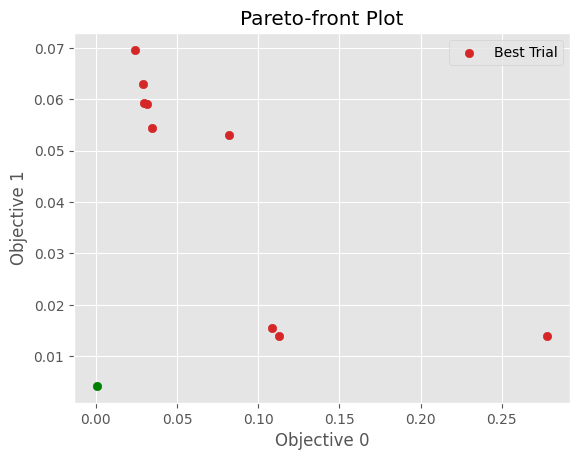

In [191]:
optuna.visualization.matplotlib.plot_pareto_front(opt_trial.study, include_dominated_trials=False)
#plt.xscale('log')
#plt.yscale('log')
plt.scatter(centroid_ground, sigma_ground, color='green')

In [192]:
for t in opt_trial.study.best_trials:
    params = t.params
    vals = t.values
    print(np.sum(np.array(vals)**2)**0.5)

0.2784268406042617
0.11339504744925394
0.10987077004085744
0.06441468693577339
0.09761276044079453
0.07368329906240914
0.06629172793007626
0.06937343597021742
0.06690816126455318


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-4467/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-4467/Downstream_HKB_bender_profile.dat written to disk.


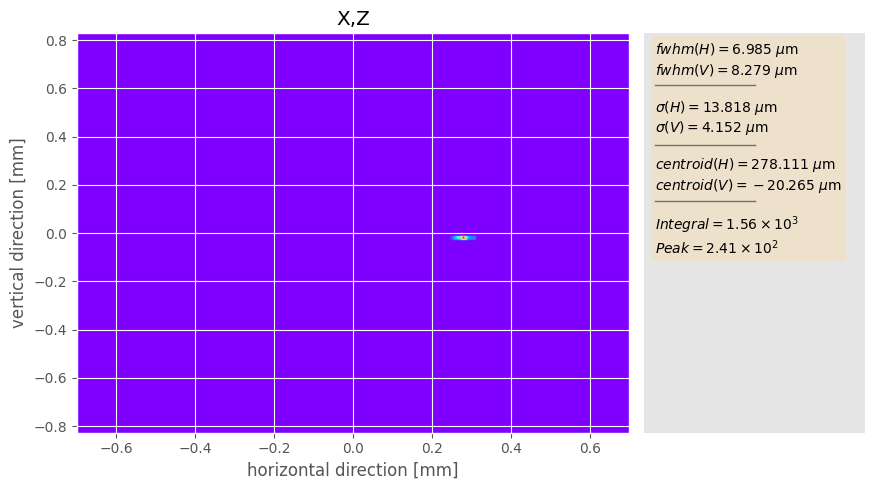

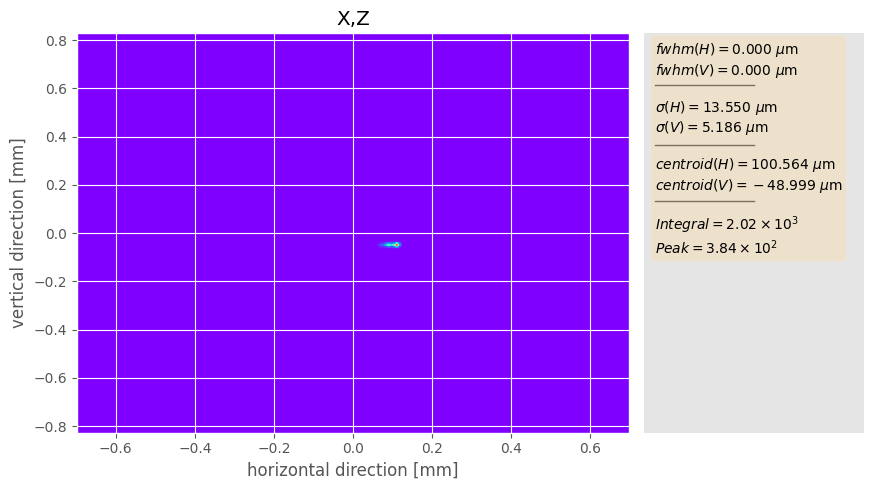

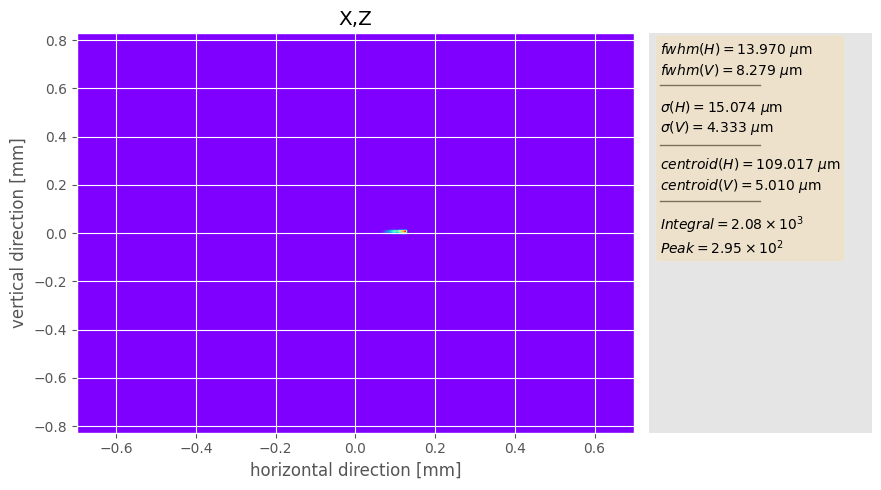

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-4467/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-4467/Downstream_HKB_bender_profile.dat written to disk.


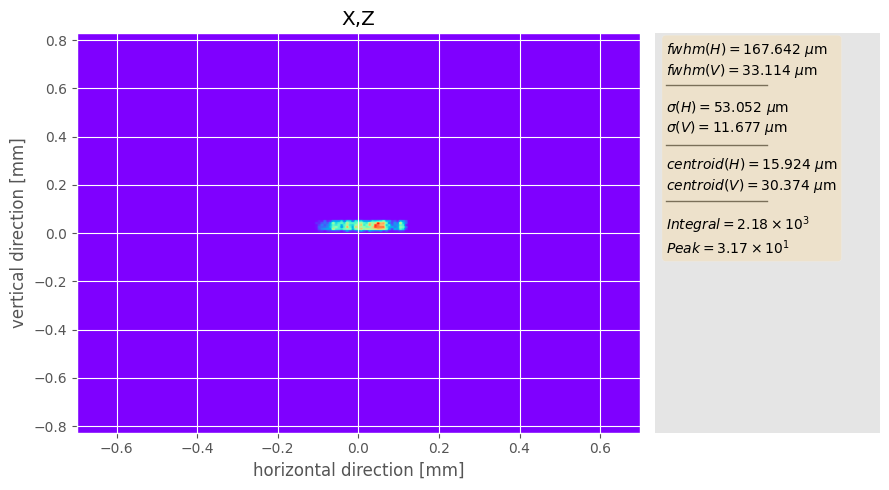

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-4467/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-4467/Downstream_HKB_bender_profile.dat written to disk.


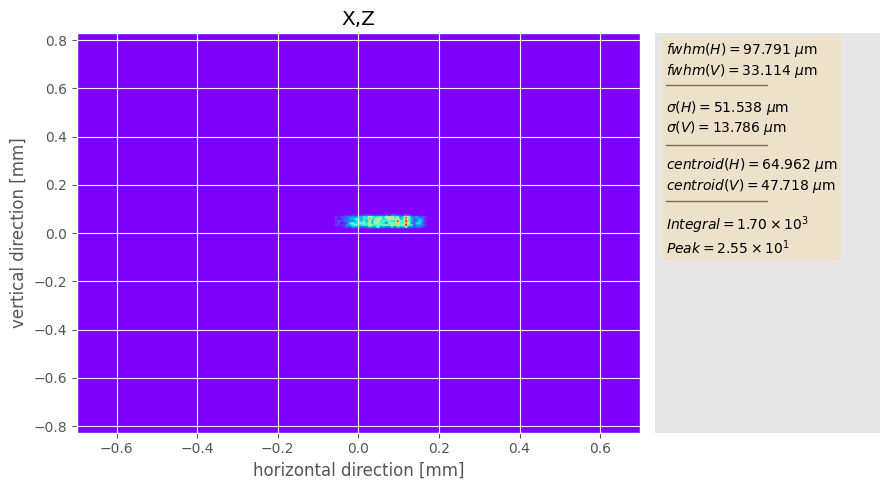

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-4467/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-4467/Downstream_HKB_bender_profile.dat written to disk.


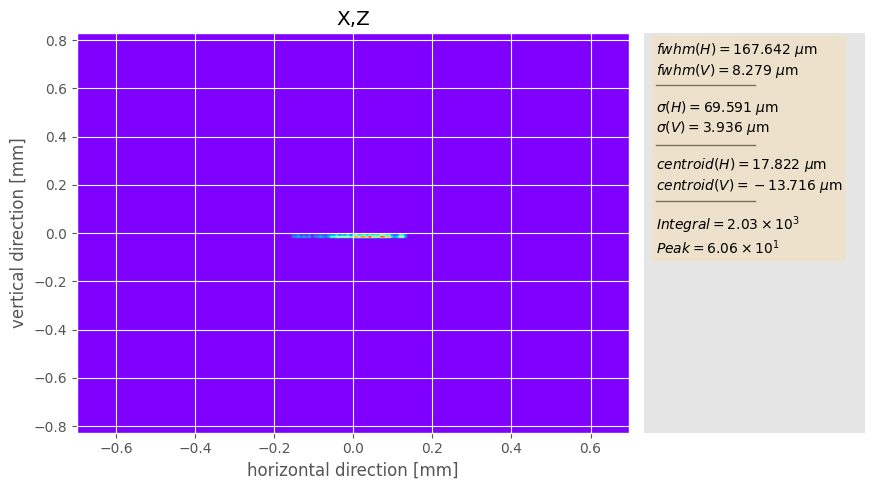

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-4467/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-4467/Downstream_HKB_bender_profile.dat written to disk.


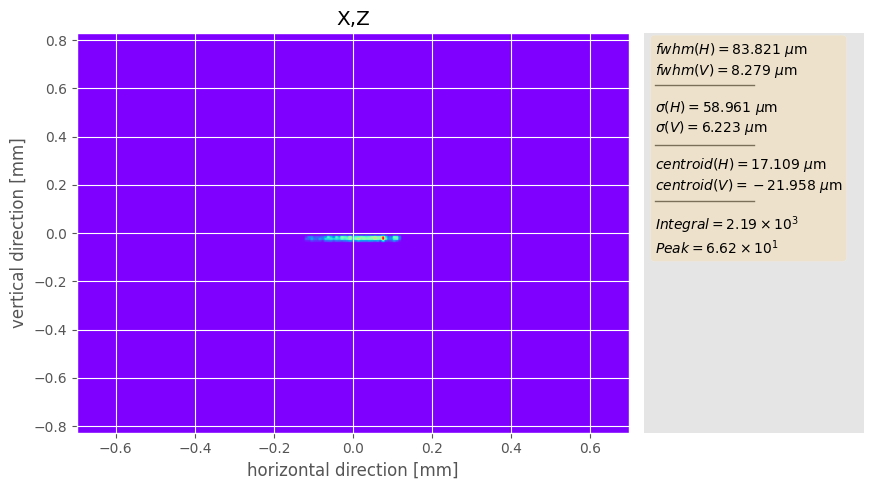

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-4467/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-4467/Downstream_HKB_bender_profile.dat written to disk.


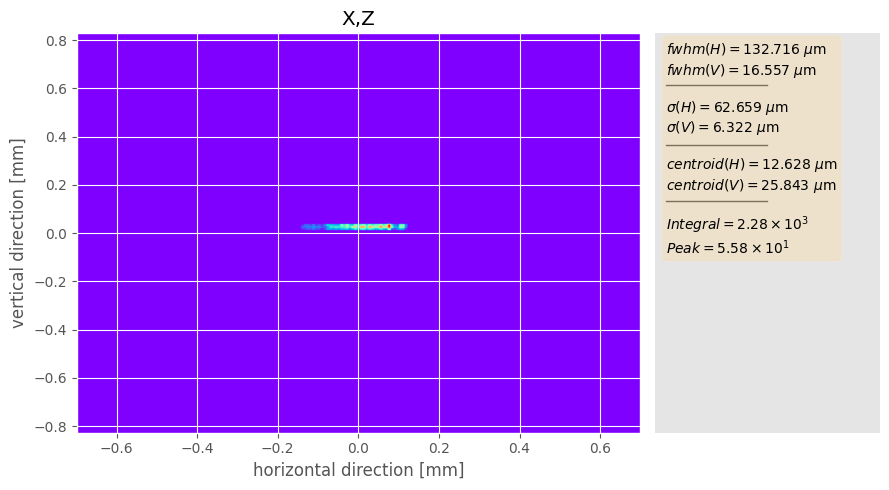

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-4467/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-4467/Downstream_HKB_bender_profile.dat written to disk.


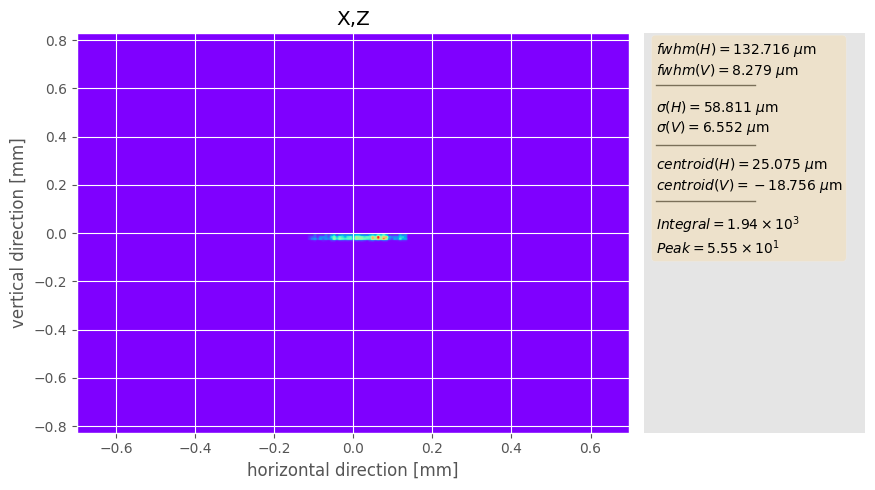

In [193]:
for t in opt_trial.study.best_trials:
    params = t.params
    vals = t.values
    current_params = []
    for mot in opt_trial.motor_types:
        current_params.append(params[mot])
    opt_trial._loss_fn_this(current_params)
    plot_shadow_beam_spatial_distribution(opt_trial.beam_state.photon_beam, xrange=opt_trial._camera_xrange, yrange=opt_trial._camera_yrange)

In [194]:
rms_metric = []
for t in opt_trial.study.best_trials:
    vals = t.values
    rms_metric.append(np.sum(np.array(vals)**2)**0.5)

In [195]:
optimal_params = opt_trial.study.best_trials[np.argmin(rms_metric)].params

In [196]:
optimal_params

{'hb_1': -49.0,
 'hb_2': 48.0,
 'hb_pitch': -0.02,
 'hb_trans': 30.0,
 'vb_bender': -29.0,
 'vb_pitch': -0.0158,
 'vb_trans': 17.5}

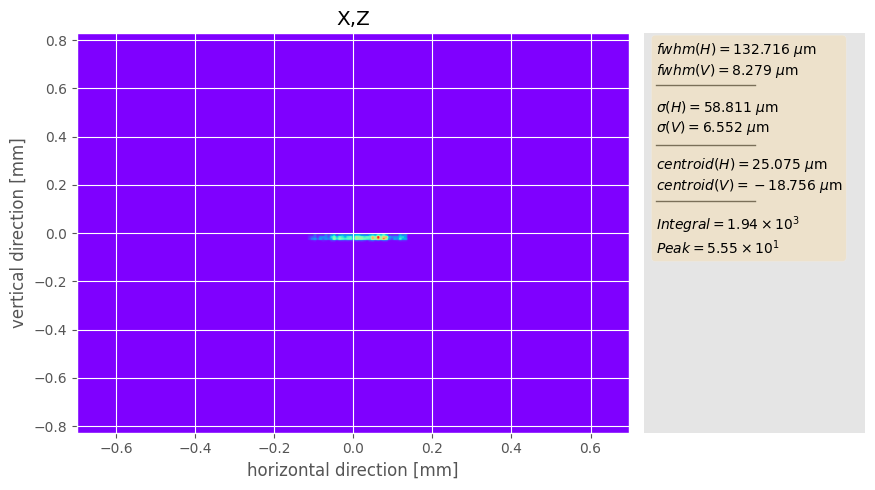

In [197]:
opt_trial._loss_fn_this(current_params)
plot_shadow_beam_spatial_distribution(opt_trial.beam_state.photon_beam, xrange=opt_trial._camera_xrange, yrange=opt_trial._camera_yrange)

In [199]:
import joblib

In [231]:
joblib.dump(opt_trial.study, 'study_' + name_str + '.pkl')

PicklingError: Can't pickle <function OptunaOptimizer.set_optimizer_options.<locals>.acquisition_function at 0x7f83ba2f6820>: it's not found as aps.ai.autoalignment.beamline28IDB.optimization.optuna_botorch.OptunaOptimizer.set_optimizer_options.<locals>.acquisition_function

In [200]:
import datetime

In [230]:
name_str = datetime.datetime.strftime(datetime.datetime.now(),"%Y:%m:%d:%H:%M")

### Rerunning the optimization from the best structure

In [106]:
opt_trial = OptunaOptimizer(
    focusing_system,
    motor_types=list(move_motors_ranges.keys()),
    random_seed=DEFAULT_RANDOM_SEED,
    loss_parameters=["centroid", "sigma"],
    use_gaussian_fit=False,
    multi_objective_optimization=True,
    camera_xrange=xrange,
    camera_yrange=yrange,
    # Need to fix the number of camera bins.
    camera_nbins_h=1028, 
    camera_nbins_v=1024
)

In [107]:
constraints = {"sum_intensity": 1.3e3}
opt_trial.set_optimizer_options(
    motor_ranges=list(move_motors_ranges.values()),
    raise_prune_exception=True,
    use_discrete_space=True,
    sum_intensity_threshold=1e3,
    constraints=constraints,
    moo_thresholds={"centroid": 0.02, "sigma": 0.07},
)

[I 2022-11-14 16:58:48,416] A new study created in memory with name: no-name-3d7f424c-bcc1-4d4f-99b0-4cae2d54cb68


In [109]:
opt_trial.trials(25, trial_motor_types=["hb_pitch", "hb_trans", "vb_pitch", "vb_trans"])

/Users/skandel/code/oasys/AI-ML_Control_System/aps/ai/autoalignment/beamline28IDB/optimization/optuna_botorch.py:463: ExperimentalWarning: PartialFixedSampler is experimental (supported from v2.4.0). The interface can change in the future.
  partial_sampler = optuna.samplers.PartialFixedSampler(fixed_params, self._base_sampler)
[I 2022-11-14 16:59:16,851] Trial 25 finished with values: [0.4808243078501081, 0.030326424484337894] and parameters: {'hb_1': 0.0, 'hb_2': 0.0, 'hb_pitch': 0.0061800000000000015, 'hb_trans': 22.5, 'vb_bender': 0.0, 'vb_pitch': 0.0178, 'vb_trans': 9.0}. 
[I 2022-11-14 16:59:18,441] Trial 26 finished with values: [0.5187497238254319, 0.027826281167673265] and parameters: {'hb_1': 0.0, 'hb_2': 0.0, 'hb_pitch': 0.013660000000000002, 'hb_trans': 12.5, 'vb_bender': 0.0, 'vb_pitch': 0.0192, 'vb_trans': 22.5}. 
[I 2022-11-14 16:59:20,181] Trial 27 finished with values: [0.5054621451923859, 0.03557260871613217] and parameters: {'hb_1': 0.0, 'hb_2': 0.0, 'hb_pitch': 0.01

In [110]:
opt_trial.study.best_trials

[FrozenTrial(number=3, values=[0.30122287334917647, 0.03532505762280745], datetime_start=datetime.datetime(2022, 11, 14, 16, 58, 49, 431794), datetime_complete=datetime.datetime(2022, 11, 14, 16, 58, 49, 557840), params={'hb_1': 0.0, 'hb_2': 0.0, 'hb_pitch': -0.0183, 'hb_trans': 30.0, 'vb_bender': 0.0, 'vb_pitch': -0.00040000000000000105, 'vb_trans': 16.5}, distributions={'hb_1': FloatDistribution(high=100.0, log=False, low=-100.0, step=1.0), 'hb_2': FloatDistribution(high=100.0, log=False, low=-100.0, step=1.0), 'hb_pitch': FloatDistribution(high=0.01995, log=False, low=-0.02, step=0.00017), 'hb_trans': FloatDistribution(high=30.0, log=False, low=-30.0, step=0.5), 'vb_bender': FloatDistribution(high=500.0, log=False, low=-500.0, step=1.0), 'vb_pitch': FloatDistribution(high=0.0192, log=False, low=-0.02, step=0.0014), 'vb_trans': FloatDistribution(high=30.0, log=False, low=-30.0, step=0.5)}, user_attrs={'sum_intensity_constraint': -1, 'dw': <aps.common.ml.data_structures.DictionaryWrap

/var/folders/gn/ggsvq37x5sv5bb1j9chn8mmw0000gr/T/ipykernel_79926/1036378160.py:1: ExperimentalWarning: plot_pareto_front is experimental (supported from v2.8.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_pareto_front(opt_trial.study, include_dominated_trials=False)


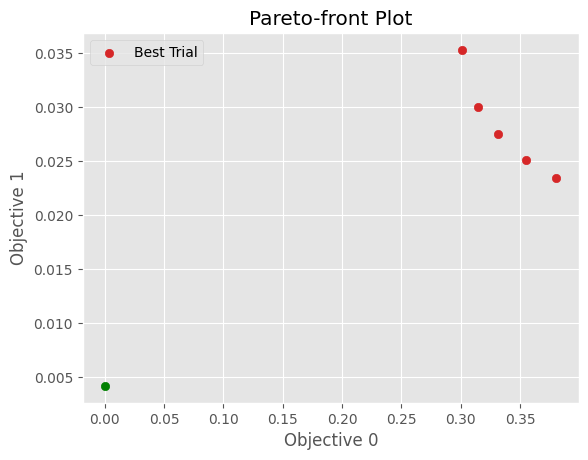

In [111]:
optuna.visualization.matplotlib.plot_pareto_front(opt_trial.study, include_dominated_trials=False)
#plt.xscale('log')
#plt.yscale('log')
plt.scatter(centroid_ground, sigma_ground, color='green')

In [112]:
for t in opt_trial.study.best_trials:
    params = t.params
    vals = t.values
    print(np.log(vals).sum(), t.user_attrs['dw'])

-4.543067564399414 h_sigma: 0.030198598852970472
h_fwhm: 0.06828793774318886
h_centroid: -0.21686835005803468
v_sigma: 0.01832769280002362
v_fwhm: 0.06174999999999953
v_centroid: 0.20905343377194197
integral_intensity: 2807.821049309863
peak_intensity: 4.698245123476403
gaussian_fit: {}

-4.718408702414385 h_sigma: 0.02046627497390449
h_fwhm: 0.04097276264591332
h_centroid: -0.2669757746032281
v_sigma: 0.014585771524133349
v_fwhm: 0.04874999999999963
v_centroid: 0.23444024750211545
integral_intensity: 2147.873560623818
peak_intensity: 6.475263306918848
gaussian_fit: {}

-4.69666808956135 h_sigma: 0.020156240928917893
h_fwhm: 0.04097276264591332
h_centroid: -0.22990755479112254
v_sigma: 0.01877591771683808
v_fwhm: 0.06174999999999953
v_centroid: 0.2385156158028888
integral_intensity: 2839.782243201361
peak_intensity: 6.048253849892256
gaussian_fit: {}

-4.716887909867319 h_sigma: 0.018791677221012573
h_fwhm: 0.05053307392995976
h_centroid: -0.2907692415029062
v_sigma: 0.0141271262828008

[0.30122287334917647, 0.03532505762280745]


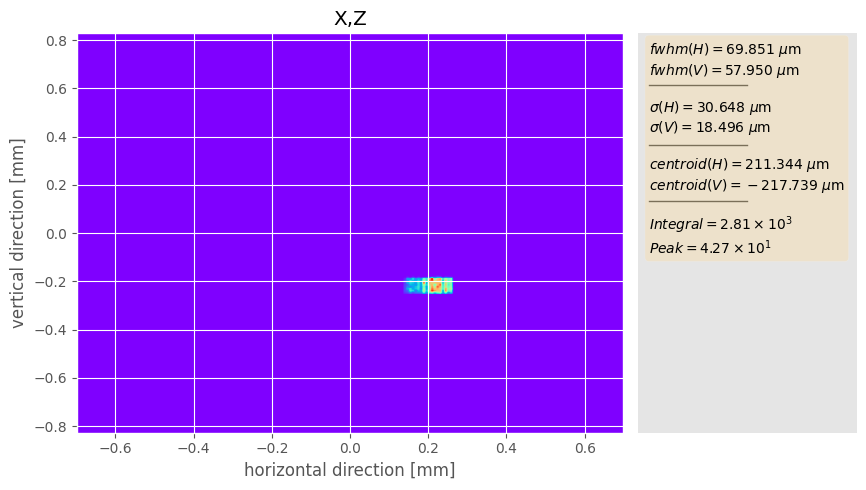

[0.35530028690369336, 0.02513191481486615]


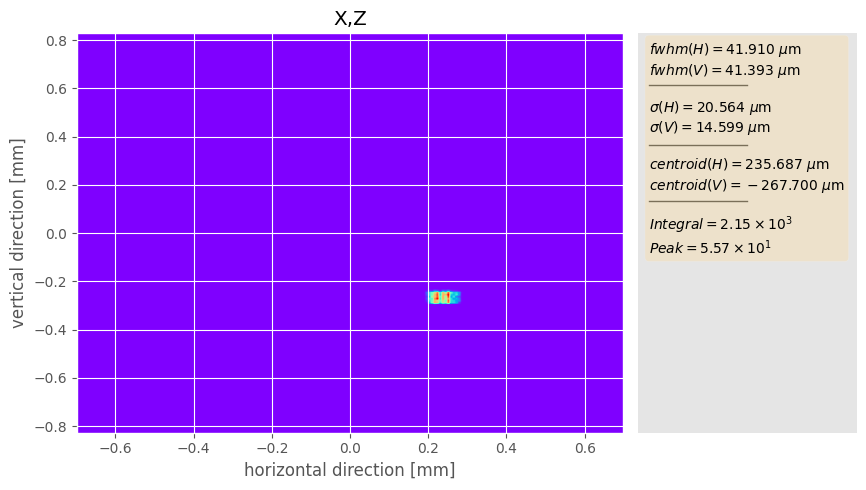

[0.33128112341614674, 0.027546490420633604]


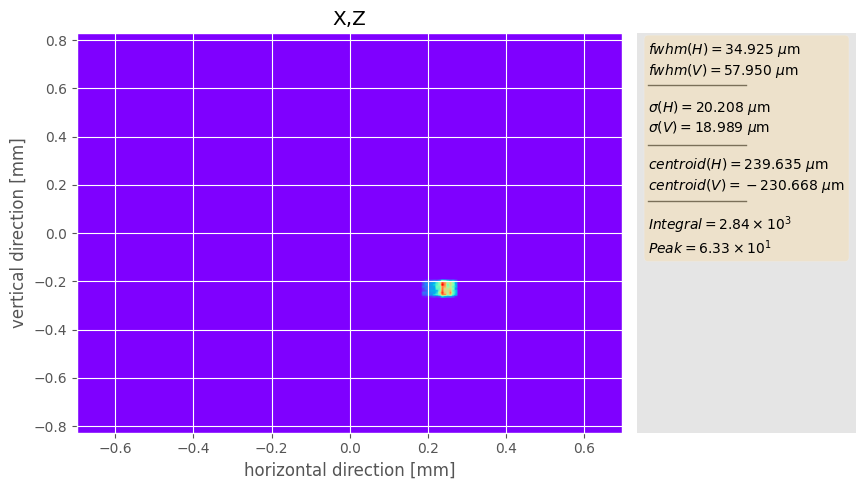

[0.38039584531077686, 0.023509632702127102]


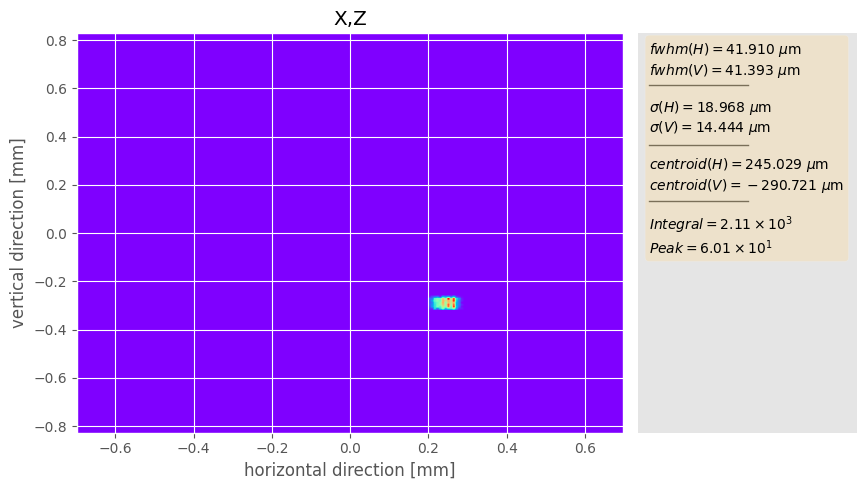

[0.31413520828883906, 0.030058146040237828]


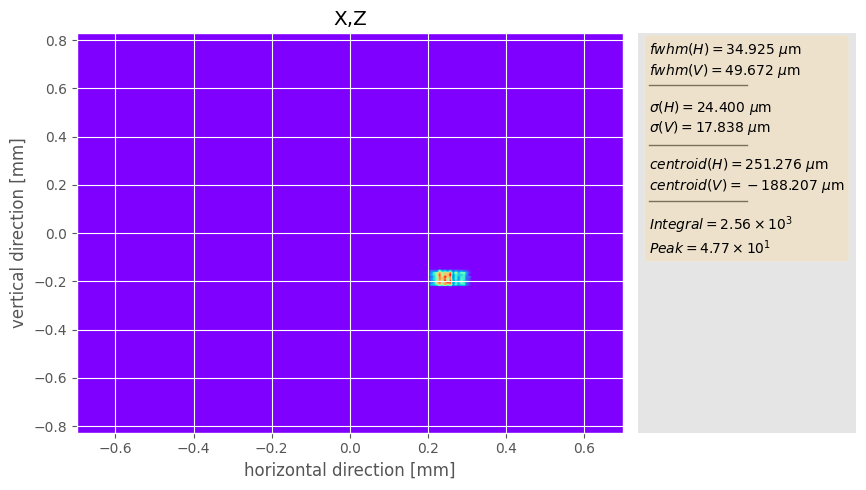

In [113]:
for t in opt_trial.study.best_trials:
    params = t.params
    vals = t.values
    current_params = []
    for mot in opt_trial.motor_types:
        current_params.append(params[mot])
    opt_trial._loss_fn_this(current_params)
    print(t.values)
    plot_shadow_beam_spatial_distribution(opt_trial.beam_state.photon_beam, xrange=opt_trial._camera_xrange, yrange=opt_trial._camera_yrange)

In [114]:
opt_trial.trials(75)

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-4467/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-4467/Downstream_HKB_bender_profile.dat written to disk.


/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/oasys/util/oasys_util.py:283: RuntimeWarning: invalid value encountered in true_divide
  frequency = histogram/numpy.sum(histogram)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/oasys/util/oasys_util.py:292: RuntimeWarning: invalid value encountered in true_divide
  frequency = histogram/numpy.sum(histogram)
[I 2022-11-14 17:00:22,068] Trial 50 pruned. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-4467/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-4467/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-14 17:00:24,916] Trial 51 finished with values: [0.23521537807748044, 0.0696873262222831] and parameters: {'hb_1': -48.0, 'hb_2': 14.0, 'hb_pitch': -0.0081, 'hb_trans': 23.5, 'vb_bender': -223.0, 'vb_pitch': -0.011600000000000001, 'vb_trans': 3.5}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-4467/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-4467/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-14 17:00:27,839] Trial 52 finished with values: [0.4958510539680668, 0.08386576584367769] and parameters: {'hb_1': 57.0, 'hb_2': -15.0, 'hb_pitch': 0.012640000000000002, 'hb_trans': -26.5, 'vb_bender': -197.0, 'vb_pitch': -0.0102, 'vb_trans': 4.5}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-4467/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-4467/Downstream_HKB_bender_profile.dat written to disk.


/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/oasys/util/oasys_util.py:283: RuntimeWarning: invalid value encountered in true_divide
  frequency = histogram/numpy.sum(histogram)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/oasys/util/oasys_util.py:292: RuntimeWarning: invalid value encountered in true_divide
  frequency = histogram/numpy.sum(histogram)
[I 2022-11-14 17:00:30,290] Trial 53 pruned. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-4467/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-4467/Downstream_HKB_bender_profile.dat written to disk.


/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/oasys/util/oasys_util.py:283: RuntimeWarning: invalid value encountered in true_divide
  frequency = histogram/numpy.sum(histogram)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/oasys/util/oasys_util.py:292: RuntimeWarning: invalid value encountered in true_divide
  frequency = histogram/numpy.sum(histogram)
[I 2022-11-14 17:00:32,456] Trial 54 pruned. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-4467/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-4467/Downstream_HKB_bender_profile.dat written to disk.


/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/oasys/util/oasys_util.py:283: RuntimeWarning: invalid value encountered in true_divide
  frequency = histogram/numpy.sum(histogram)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/oasys/util/oasys_util.py:292: RuntimeWarning: invalid value encountered in true_divide
  frequency = histogram/numpy.sum(histogram)
[I 2022-11-14 17:00:34,638] Trial 55 pruned. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-4467/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-4467/Downstream_HKB_bender_profile.dat written to disk.


/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/oasys/util/oasys_util.py:283: RuntimeWarning: invalid value encountered in true_divide
  frequency = histogram/numpy.sum(histogram)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/oasys/util/oasys_util.py:292: RuntimeWarning: invalid value encountered in true_divide
  frequency = histogram/numpy.sum(histogram)
[I 2022-11-14 17:00:36,901] Trial 56 pruned. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-4467/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-4467/Downstream_HKB_bender_profile.dat written to disk.


/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/oasys/util/oasys_util.py:283: RuntimeWarning: invalid value encountered in true_divide
  frequency = histogram/numpy.sum(histogram)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/oasys/util/oasys_util.py:292: RuntimeWarning: invalid value encountered in true_divide
  frequency = histogram/numpy.sum(histogram)
[I 2022-11-14 17:00:39,052] Trial 57 pruned. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-4467/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-4467/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-14 17:00:41,257] Trial 58 finished with values: [0.3290066753724557, 0.08966585489178372] and parameters: {'hb_1': -69.0, 'hb_2': -35.0, 'hb_pitch': -0.01864, 'hb_trans': 8.0, 'vb_bender': -78.0, 'vb_pitch': 0.0178, 'vb_trans': -11.5}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-4467/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-4467/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-14 17:00:42,986] Trial 59 finished with values: [0.4855769062526005, 0.07017923232739244] and parameters: {'hb_1': -43.0, 'hb_2': -69.0, 'hb_pitch': 0.008560000000000002, 'hb_trans': -27.0, 'vb_bender': -139.0, 'vb_pitch': 0.008, 'vb_trans': -28.5}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-4467/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-4467/Downstream_HKB_bender_profile.dat written to disk.


/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/oasys/util/oasys_util.py:283: RuntimeWarning: invalid value encountered in true_divide
  frequency = histogram/numpy.sum(histogram)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/oasys/util/oasys_util.py:292: RuntimeWarning: invalid value encountered in true_divide
  frequency = histogram/numpy.sum(histogram)
[I 2022-11-14 17:00:45,120] Trial 60 pruned. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-4467/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-4467/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-14 17:00:47,232] Trial 61 finished with values: [0.3166593967012947, 0.13355823080141954] and parameters: {'hb_1': 17.0, 'hb_2': 67.0, 'hb_pitch': 0.0012500000000000011, 'hb_trans': 24.5, 'vb_bender': -363.0, 'vb_pitch': -0.00040000000000000105, 'vb_trans': 26.5}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-4467/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-4467/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-14 17:00:50,151] Trial 62 finished with values: [0.47684998298317344, 0.06750442430938] and parameters: {'hb_1': -48.0, 'hb_2': -39.0, 'hb_pitch': 0.0063500000000000015, 'hb_trans': -15.5, 'vb_bender': 91.0, 'vb_pitch': -0.013000000000000001, 'vb_trans': 7.5}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-4467/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-4467/Downstream_HKB_bender_profile.dat written to disk.


/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/oasys/util/oasys_util.py:283: RuntimeWarning: invalid value encountered in true_divide
  frequency = histogram/numpy.sum(histogram)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/oasys/util/oasys_util.py:292: RuntimeWarning: invalid value encountered in true_divide
  frequency = histogram/numpy.sum(histogram)
[I 2022-11-14 17:00:52,695] Trial 63 pruned. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-4467/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-4467/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-14 17:00:55,209] Trial 64 finished with values: [0.48016511764115677, 0.11242135229437424] and parameters: {'hb_1': 37.0, 'hb_2': 64.0, 'hb_pitch': 0.018080000000000002, 'hb_trans': -4.0, 'vb_bender': -11.0, 'vb_pitch': -0.0017999999999999995, 'vb_trans': 12.0}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-4467/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-4467/Downstream_HKB_bender_profile.dat written to disk.


/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/oasys/util/oasys_util.py:283: RuntimeWarning: invalid value encountered in true_divide
  frequency = histogram/numpy.sum(histogram)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/oasys/util/oasys_util.py:292: RuntimeWarning: invalid value encountered in true_divide
  frequency = histogram/numpy.sum(histogram)
[I 2022-11-14 17:00:57,847] Trial 65 pruned. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-4467/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-4467/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-14 17:00:59,974] Trial 66 finished with values: [0.33226920763439943, 0.15071775067786505] and parameters: {'hb_1': 32.0, 'hb_2': 96.0, 'hb_pitch': -0.0065699999999999995, 'hb_trans': 15.0, 'vb_bender': -382.0, 'vb_pitch': -0.02, 'vb_trans': -23.5}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-4467/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-4467/Downstream_HKB_bender_profile.dat written to disk.


/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/oasys/util/oasys_util.py:283: RuntimeWarning: invalid value encountered in true_divide
  frequency = histogram/numpy.sum(histogram)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/oasys/util/oasys_util.py:292: RuntimeWarning: invalid value encountered in true_divide
  frequency = histogram/numpy.sum(histogram)
[I 2022-11-14 17:01:01,922] Trial 67 pruned. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-4467/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-4467/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-14 17:01:03,850] Trial 68 finished with values: [0.41390573723848023, 0.12522557571161982] and parameters: {'hb_1': -11.0, 'hb_2': 98.0, 'hb_pitch': 0.005500000000000001, 'hb_trans': -16.0, 'vb_bender': 14.0, 'vb_pitch': 0.012199999999999999, 'vb_trans': 20.0}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-4467/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-4467/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-14 17:01:06,136] Trial 69 finished with values: [0.3961243848070096, 0.1079364055929987] and parameters: {'hb_1': -2.0, 'hb_2': -33.0, 'hb_pitch': -0.002659999999999999, 'hb_trans': -3.0, 'vb_bender': -389.0, 'vb_pitch': -0.0032000000000000015, 'vb_trans': 7.0}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-4467/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-4467/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-14 17:01:08,036] Trial 70 finished with values: [0.3740005220298581, 0.11319839676652005] and parameters: {'hb_1': -66.0, 'hb_2': -20.0, 'hb_pitch': 0.009750000000000002, 'hb_trans': 14.0, 'vb_bender': -323.0, 'vb_pitch': 0.0023999999999999994, 'vb_trans': 7.0}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-4467/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-4467/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-14 17:01:10,280] Trial 71 finished with values: [0.4190778444357466, 0.03435122746251735] and parameters: {'hb_1': -16.0, 'hb_2': -39.0, 'hb_pitch': 0.002270000000000001, 'hb_trans': -16.5, 'vb_bender': -4.0, 'vb_pitch': -0.0172, 'vb_trans': 27.0}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-4467/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-4467/Downstream_HKB_bender_profile.dat written to disk.


/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/oasys/util/oasys_util.py:283: RuntimeWarning: invalid value encountered in true_divide
  frequency = histogram/numpy.sum(histogram)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/oasys/util/oasys_util.py:292: RuntimeWarning: invalid value encountered in true_divide
  frequency = histogram/numpy.sum(histogram)
[I 2022-11-14 17:01:12,832] Trial 72 pruned. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-4467/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-4467/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-14 17:01:15,391] Trial 73 finished with values: [0.29254326252566387, 0.12091355331200078] and parameters: {'hb_1': 80.0, 'hb_2': 24.0, 'hb_pitch': -0.01796, 'hb_trans': 19.5, 'vb_bender': -298.0, 'vb_pitch': -0.018600000000000002, 'vb_trans': 13.0}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-4467/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-4467/Downstream_HKB_bender_profile.dat written to disk.


/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/oasys/util/oasys_util.py:283: RuntimeWarning: invalid value encountered in true_divide
  frequency = histogram/numpy.sum(histogram)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/oasys/util/oasys_util.py:292: RuntimeWarning: invalid value encountered in true_divide
  frequency = histogram/numpy.sum(histogram)
[I 2022-11-14 17:01:17,441] Trial 74 pruned. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-4467/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-4467/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-14 17:01:19,475] Trial 75 finished with values: [0.37639391805059297, 0.14030894521427265] and parameters: {'hb_1': -2.0, 'hb_2': 55.0, 'hb_pitch': -0.001129999999999999, 'hb_trans': 4.0, 'vb_bender': -431.0, 'vb_pitch': -0.011600000000000001, 'vb_trans': 13.0}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-4467/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-4467/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-14 17:01:21,860] Trial 76 finished with values: [0.46155578285800164, 0.10210343852966261] and parameters: {'hb_1': -86.0, 'hb_2': -1.0, 'hb_pitch': 0.017060000000000002, 'hb_trans': -23.0, 'vb_bender': -347.0, 'vb_pitch': -0.02, 'vb_trans': 2.0}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-4467/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-4467/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-14 17:01:24,016] Trial 77 finished with values: [0.17948293510067131, 0.077884672033207] and parameters: {'hb_1': -90.0, 'hb_2': 42.0, 'hb_pitch': -0.01099, 'hb_trans': 3.5, 'vb_bender': -189.0, 'vb_pitch': -0.011600000000000001, 'vb_trans': 4.0}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-4467/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-4467/Downstream_HKB_bender_profile.dat written to disk.


/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/oasys/util/oasys_util.py:283: RuntimeWarning: invalid value encountered in true_divide
  frequency = histogram/numpy.sum(histogram)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/oasys/util/oasys_util.py:292: RuntimeWarning: invalid value encountered in true_divide
  frequency = histogram/numpy.sum(histogram)
[I 2022-11-14 17:01:26,871] Trial 78 pruned. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-4467/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-4467/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-14 17:01:29,107] Trial 79 finished with values: [0.43229872057492447, 0.11977789966620132] and parameters: {'hb_1': 39.0, 'hb_2': -9.0, 'hb_pitch': 0.0038000000000000013, 'hb_trans': -0.5, 'vb_bender': -368.0, 'vb_pitch': -0.006, 'vb_trans': 30.0}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-4467/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-4467/Downstream_HKB_bender_profile.dat written to disk.


/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/oasys/util/oasys_util.py:283: RuntimeWarning: invalid value encountered in true_divide
  frequency = histogram/numpy.sum(histogram)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/oasys/util/oasys_util.py:292: RuntimeWarning: invalid value encountered in true_divide
  frequency = histogram/numpy.sum(histogram)
[I 2022-11-14 17:01:31,282] Trial 80 pruned. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-4467/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-4467/Downstream_HKB_bender_profile.dat written to disk.


/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/oasys/util/oasys_util.py:283: RuntimeWarning: invalid value encountered in true_divide
  frequency = histogram/numpy.sum(histogram)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/oasys/util/oasys_util.py:292: RuntimeWarning: invalid value encountered in true_divide
  frequency = histogram/numpy.sum(histogram)
[I 2022-11-14 17:01:33,425] Trial 81 pruned. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-4467/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-4467/Downstream_HKB_bender_profile.dat written to disk.


/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/oasys/util/oasys_util.py:283: RuntimeWarning: invalid value encountered in true_divide
  frequency = histogram/numpy.sum(histogram)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/oasys/util/oasys_util.py:292: RuntimeWarning: invalid value encountered in true_divide
  frequency = histogram/numpy.sum(histogram)
[I 2022-11-14 17:01:35,613] Trial 82 pruned. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-4467/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-4467/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-14 17:01:37,772] Trial 83 finished with values: [0.39755493253172347, 0.11332696544670405] and parameters: {'hb_1': 46.0, 'hb_2': 55.0, 'hb_pitch': 0.0073700000000000015, 'hb_trans': -11.0, 'vb_bender': -65.0, 'vb_pitch': -0.0144, 'vb_trans': 9.0}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-4467/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-4467/Downstream_HKB_bender_profile.dat written to disk.


/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/oasys/util/oasys_util.py:283: RuntimeWarning: invalid value encountered in true_divide
  frequency = histogram/numpy.sum(histogram)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/oasys/util/oasys_util.py:292: RuntimeWarning: invalid value encountered in true_divide
  frequency = histogram/numpy.sum(histogram)
[I 2022-11-14 17:01:40,469] Trial 84 pruned. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-4467/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-4467/Downstream_HKB_bender_profile.dat written to disk.


/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/oasys/util/oasys_util.py:283: RuntimeWarning: invalid value encountered in true_divide
  frequency = histogram/numpy.sum(histogram)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/oasys/util/oasys_util.py:292: RuntimeWarning: invalid value encountered in true_divide
  frequency = histogram/numpy.sum(histogram)
[I 2022-11-14 17:01:43,198] Trial 85 pruned. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-4467/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-4467/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-14 17:01:45,914] Trial 86 finished with values: [0.4686533412425106, 0.09269558835133077] and parameters: {'hb_1': -92.0, 'hb_2': -45.0, 'hb_pitch': 0.011280000000000002, 'hb_trans': -19.5, 'vb_bender': -40.0, 'vb_pitch': 0.0023999999999999994, 'vb_trans': -12.0}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-4467/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-4467/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-14 17:01:47,982] Trial 87 finished with values: [0.42138292001064565, 0.14568565367159547] and parameters: {'hb_1': 16.0, 'hb_2': 64.0, 'hb_pitch': 0.009920000000000002, 'hb_trans': 16.5, 'vb_bender': -461.0, 'vb_pitch': -0.0017999999999999995, 'vb_trans': -3.0}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-4467/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-4467/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-14 17:01:51,055] Trial 88 finished with values: [0.4823839803022614, 0.08126074874216581] and parameters: {'hb_1': 37.0, 'hb_2': -100.0, 'hb_pitch': -0.001469999999999999, 'hb_trans': -6.0, 'vb_bender': -100.0, 'vb_pitch': 0.0052, 'vb_trans': -2.5}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-4467/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-4467/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-14 17:01:53,487] Trial 89 finished with values: [0.2709855658178692, 0.14895381960848678] and parameters: {'hb_1': 45.0, 'hb_2': 84.0, 'hb_pitch': -0.004359999999999999, 'hb_trans': 11.0, 'vb_bender': -331.0, 'vb_pitch': 0.013599999999999998, 'vb_trans': -2.0}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-4467/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-4467/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-14 17:01:55,823] Trial 90 finished with values: [0.47225536744601515, 0.13767299286391912] and parameters: {'hb_1': 81.0, 'hb_2': -76.0, 'hb_pitch': -0.00997, 'hb_trans': -13.0, 'vb_bender': -384.0, 'vb_pitch': -0.02, 'vb_trans': 26.5}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-4467/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-4467/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-14 17:01:58,512] Trial 91 finished with values: [0.2898129622409215, 0.11806980145540863] and parameters: {'hb_1': -57.0, 'hb_2': -80.0, 'hb_pitch': -0.01575, 'hb_trans': -4.5, 'vb_bender': -225.0, 'vb_pitch': -0.02, 'vb_trans': -9.5}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-4467/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-4467/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-14 17:02:01,025] Trial 92 finished with values: [0.38786080645209386, 0.1226060685782284] and parameters: {'hb_1': -69.0, 'hb_2': -76.0, 'hb_pitch': 0.0015900000000000011, 'hb_trans': -14.0, 'vb_bender': -243.0, 'vb_pitch': -0.0017999999999999995, 'vb_trans': 26.0}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-4467/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-4467/Downstream_HKB_bender_profile.dat written to disk.


/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/oasys/util/oasys_util.py:283: RuntimeWarning: invalid value encountered in true_divide
  frequency = histogram/numpy.sum(histogram)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/oasys/util/oasys_util.py:292: RuntimeWarning: invalid value encountered in true_divide
  frequency = histogram/numpy.sum(histogram)
[I 2022-11-14 17:02:03,196] Trial 93 pruned. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-4467/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-4467/Downstream_HKB_bender_profile.dat written to disk.


/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/oasys/util/oasys_util.py:283: RuntimeWarning: invalid value encountered in true_divide
  frequency = histogram/numpy.sum(histogram)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/oasys/util/oasys_util.py:292: RuntimeWarning: invalid value encountered in true_divide
  frequency = histogram/numpy.sum(histogram)
[I 2022-11-14 17:02:05,349] Trial 94 pruned. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-4467/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-4467/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-14 17:02:07,663] Trial 95 finished with values: [0.440967136755539, 0.10374134761138946] and parameters: {'hb_1': -34.0, 'hb_2': 11.0, 'hb_pitch': 0.003970000000000001, 'hb_trans': -12.5, 'vb_bender': -443.0, 'vb_pitch': -0.013000000000000001, 'vb_trans': -20.5}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-4467/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-4467/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-14 17:02:09,987] Trial 96 finished with values: [0.34309757130990687, 0.12639653753885097] and parameters: {'hb_1': -51.0, 'hb_2': -95.0, 'hb_pitch': -0.01048, 'hb_trans': -4.5, 'vb_bender': -230.0, 'vb_pitch': 0.0164, 'vb_trans': -18.5}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-4467/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-4467/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-14 17:02:12,489] Trial 97 finished with values: [0.4886577736230261, 0.1340931889202366] and parameters: {'hb_1': -7.0, 'hb_2': -66.0, 'hb_pitch': 0.009920000000000002, 'hb_trans': -6.0, 'vb_bender': -464.0, 'vb_pitch': 0.0164, 'vb_trans': -4.5}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-4467/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-4467/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-14 17:02:15,013] Trial 98 finished with values: [0.2736856542691339, 0.07022534555623591] and parameters: {'hb_1': 3.0, 'hb_2': 5.0, 'hb_pitch': -0.0077599999999999995, 'hb_trans': 27.0, 'vb_bender': -246.0, 'vb_pitch': 0.006599999999999998, 'vb_trans': 29.5}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-4467/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-4467/Downstream_HKB_bender_profile.dat written to disk.


/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/oasys/util/oasys_util.py:283: RuntimeWarning: invalid value encountered in true_divide
  frequency = histogram/numpy.sum(histogram)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/oasys/util/oasys_util.py:292: RuntimeWarning: invalid value encountered in true_divide
  frequency = histogram/numpy.sum(histogram)
[I 2022-11-14 17:02:17,370] Trial 99 pruned. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-4467/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-4467/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-14 17:02:20,044] Trial 100 finished with values: [0.22365045624258936, 0.08718933753736796] and parameters: {'hb_1': -93.0, 'hb_2': 17.0, 'hb_pitch': -0.01031, 'hb_trans': -3.5, 'vb_bender': -217.0, 'vb_pitch': 0.014999999999999996, 'vb_trans': 20.0}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-4467/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-4467/Downstream_HKB_bender_profile.dat written to disk.


/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/oasys/util/oasys_util.py:283: RuntimeWarning: invalid value encountered in true_divide
  frequency = histogram/numpy.sum(histogram)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/oasys/util/oasys_util.py:292: RuntimeWarning: invalid value encountered in true_divide
  frequency = histogram/numpy.sum(histogram)
[I 2022-11-14 17:02:22,129] Trial 101 pruned. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-4467/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-4467/Downstream_HKB_bender_profile.dat written to disk.


/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/oasys/util/oasys_util.py:283: RuntimeWarning: invalid value encountered in true_divide
  frequency = histogram/numpy.sum(histogram)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/oasys/util/oasys_util.py:292: RuntimeWarning: invalid value encountered in true_divide
  frequency = histogram/numpy.sum(histogram)
[I 2022-11-14 17:02:24,494] Trial 102 pruned. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-4467/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-4467/Downstream_HKB_bender_profile.dat written to disk.


/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/oasys/util/oasys_util.py:283: RuntimeWarning: invalid value encountered in true_divide
  frequency = histogram/numpy.sum(histogram)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/oasys/util/oasys_util.py:292: RuntimeWarning: invalid value encountered in true_divide
  frequency = histogram/numpy.sum(histogram)
[I 2022-11-14 17:02:26,758] Trial 103 pruned. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-4467/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-4467/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-14 17:02:28,969] Trial 104 finished with values: [0.438077740233895, 0.05361481313799894] and parameters: {'hb_1': -75.0, 'hb_2': 19.0, 'hb_pitch': 0.012469999999999998, 'hb_trans': -1.5, 'vb_bender': -54.0, 'vb_pitch': 0.012199999999999999, 'vb_trans': -14.0}. 
[W 2022-11-14 17:02:31,552] Trial 105 failed because of the following error: KeyboardInterrupt()
Traceback (most recent call last):
  File "/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/study/_optimize.py", line 196, in _run_trial
    value_or_values = func(trial)
  File "/Users/skandel/code/oasys/AI-ML_Control_System/aps/ai/autoalignment/beamline28IDB/optimization/optuna_botorch.py", line 457, in <lambda>
    obj_this = lambda t: self._objective(t, step_scale=step_scale)
  File "/Users/skandel/code/oasys/AI-ML_Control_System/aps/ai/autoalignment/beamline28IDB/optimization/optuna_botorch.py", line 407, in _objective
    loss = self._loss_fn_this(curren

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-4467/Upstream_HKB_bender_profile.dat written to disk.


KeyboardInterrupt: 

In [115]:
opt_trial.study.best_trials

[FrozenTrial(number=3, values=[0.30122287334917647, 0.03532505762280745], datetime_start=datetime.datetime(2022, 11, 14, 16, 58, 49, 431794), datetime_complete=datetime.datetime(2022, 11, 14, 16, 58, 49, 557840), params={'hb_1': 0.0, 'hb_2': 0.0, 'hb_pitch': -0.0183, 'hb_trans': 30.0, 'vb_bender': 0.0, 'vb_pitch': -0.00040000000000000105, 'vb_trans': 16.5}, distributions={'hb_1': FloatDistribution(high=100.0, log=False, low=-100.0, step=1.0), 'hb_2': FloatDistribution(high=100.0, log=False, low=-100.0, step=1.0), 'hb_pitch': FloatDistribution(high=0.01995, log=False, low=-0.02, step=0.00017), 'hb_trans': FloatDistribution(high=30.0, log=False, low=-30.0, step=0.5), 'vb_bender': FloatDistribution(high=500.0, log=False, low=-500.0, step=1.0), 'vb_pitch': FloatDistribution(high=0.0192, log=False, low=-0.02, step=0.0014), 'vb_trans': FloatDistribution(high=30.0, log=False, low=-30.0, step=0.5)}, user_attrs={'sum_intensity_constraint': -1, 'dw': <aps.common.ml.data_structures.DictionaryWrap

/var/folders/gn/ggsvq37x5sv5bb1j9chn8mmw0000gr/T/ipykernel_79926/1036378160.py:1: ExperimentalWarning: plot_pareto_front is experimental (supported from v2.8.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_pareto_front(opt_trial.study, include_dominated_trials=False)


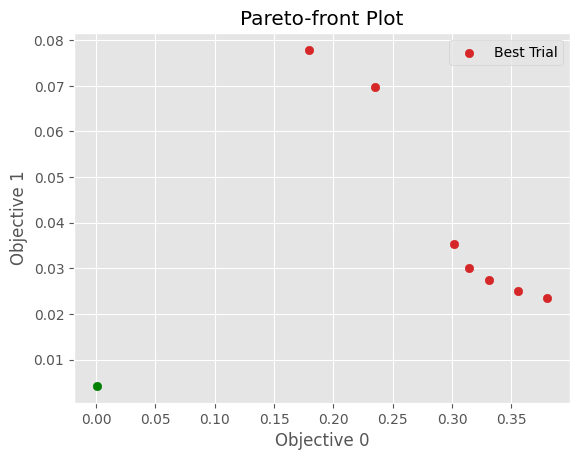

In [116]:
optuna.visualization.matplotlib.plot_pareto_front(opt_trial.study, include_dominated_trials=False)
#plt.xscale('log')
#plt.yscale('log')
plt.scatter(centroid_ground, sigma_ground, color='green')

In [117]:
for t in opt_trial.study.best_trials:
    params = t.params
    vals = t.values
    print(np.sum(np.array(vals)**2)**0.5)

0.3032871232426274
0.35618802199976984
0.33242441526813027
0.38112163669816673
0.3155699941852022
0.24532141675798094
0.19565312706438404


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-4467/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-4467/Downstream_HKB_bender_profile.dat written to disk.


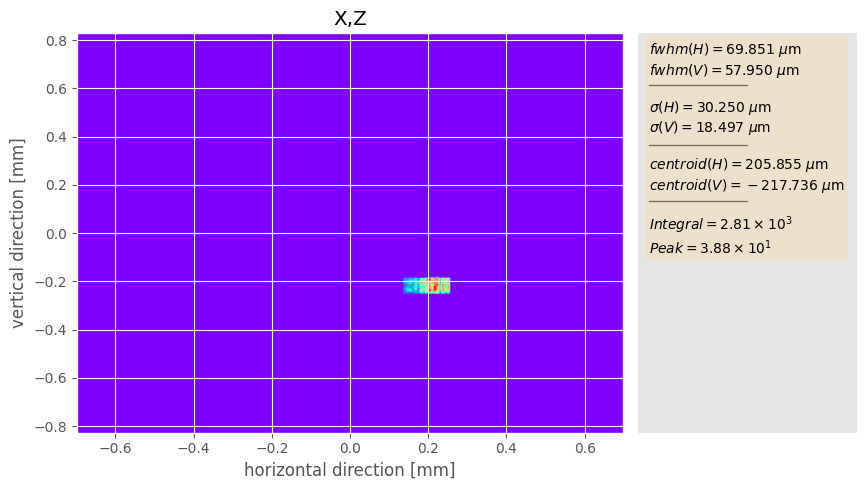

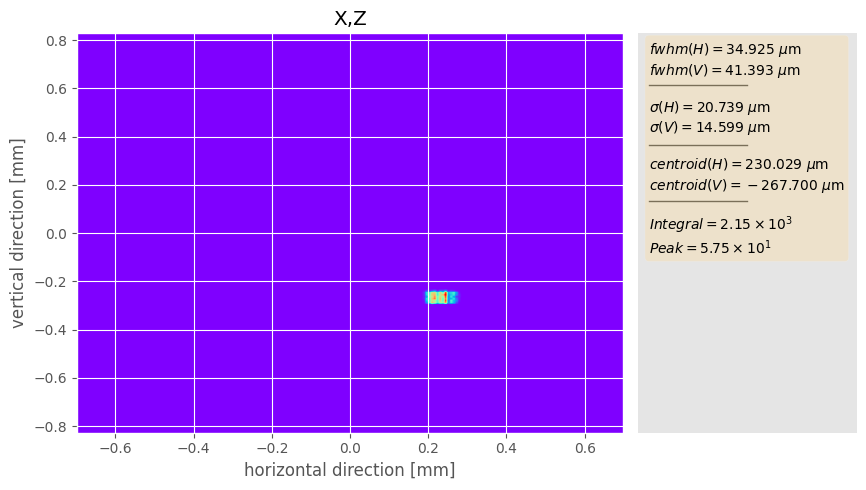

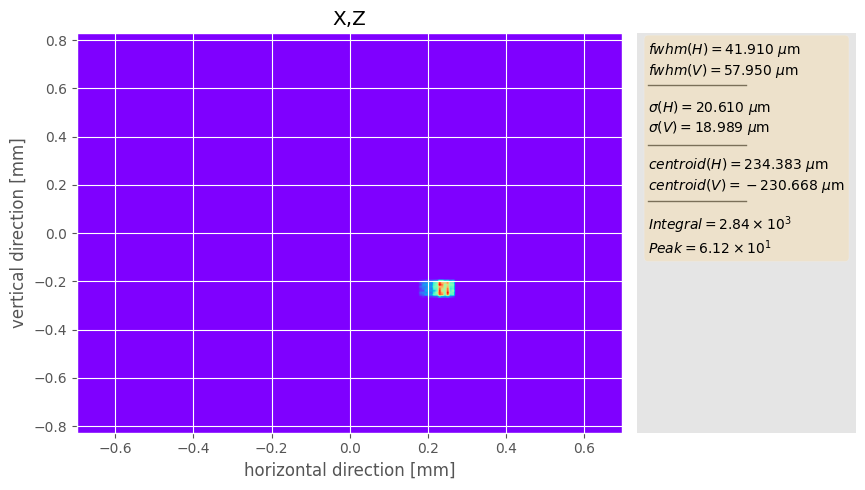

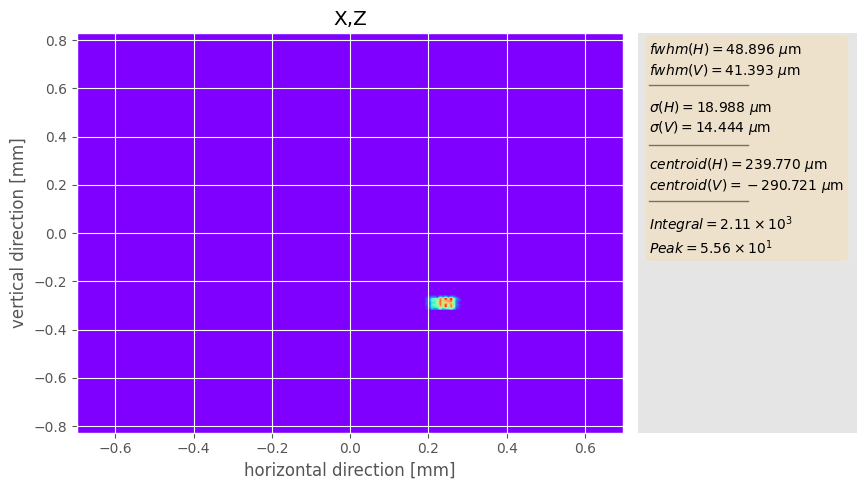

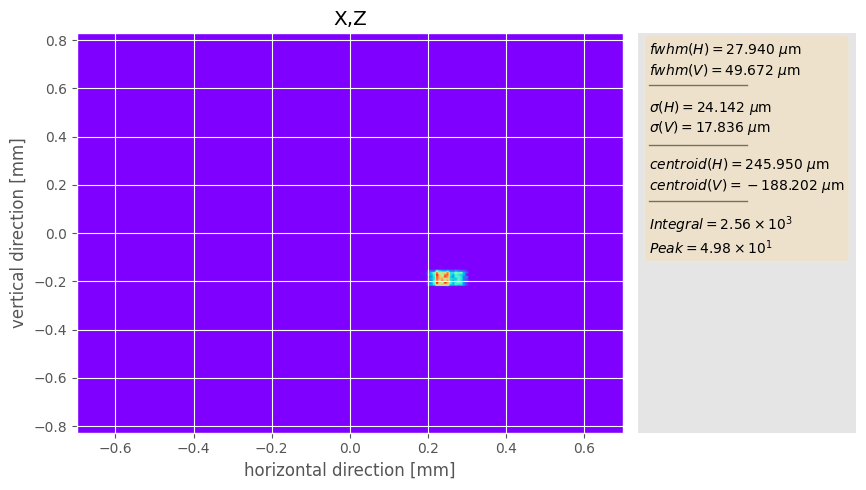

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-4467/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-4467/Downstream_HKB_bender_profile.dat written to disk.


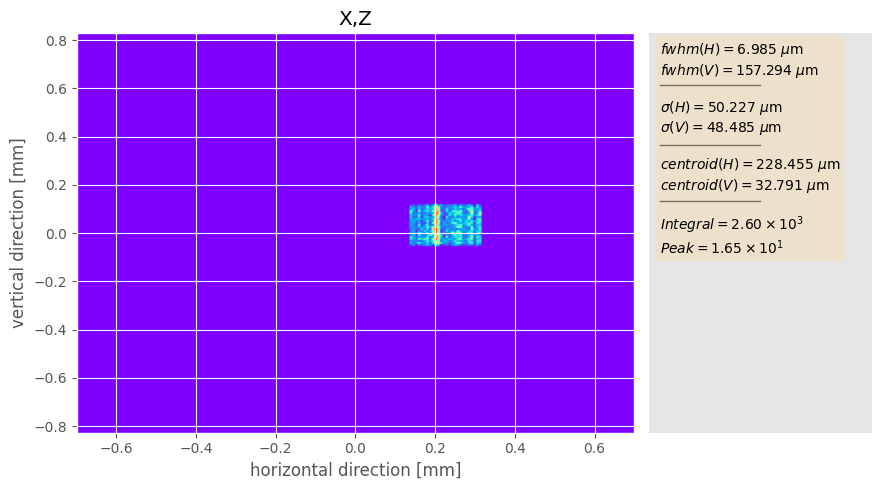

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-4467/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-4467/Downstream_HKB_bender_profile.dat written to disk.


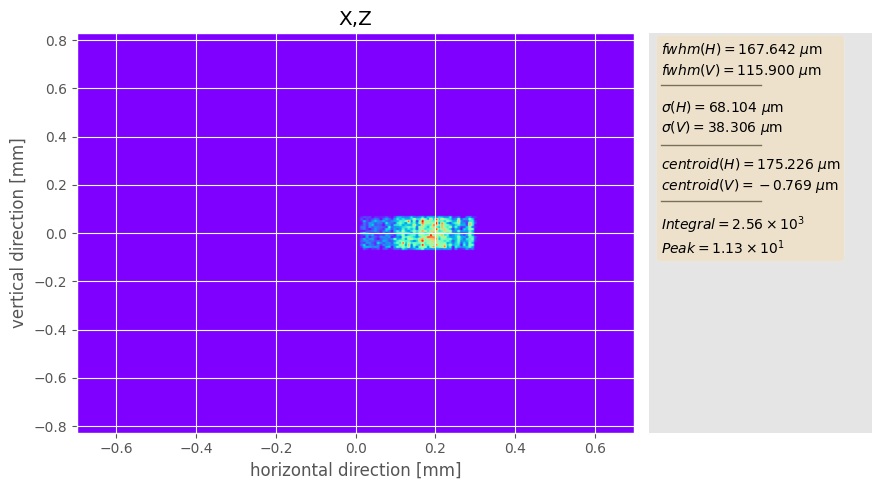

In [118]:
for t in opt_trial.study.best_trials:
    params = t.params
    vals = t.values
    current_params = []
    for mot in opt_trial.motor_types:
        current_params.append(params[mot])
    opt_trial._loss_fn_this(current_params)
    plot_shadow_beam_spatial_distribution(opt_trial.beam_state.photon_beam, xrange=opt_trial._camera_xrange, yrange=opt_trial._camera_yrange)